<center> <img src="https://miro.medium.com/v2/resize:fit:1250/format:webp/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width=25% > </center>

<br><br>

<center> 
    <font size="6">Final Lab (Part 1): Keypoint Detection, Bag of Visual Words and Image Classification</font>
</center>
<center> 
    <font size="4">Computer Vision 1 University of Amsterdam</font> 
</center>
<center> 
    <font size="4">Due 23:59PM, 24th October, 2025 (Amsterdam time)</font> 
</center>

<br><br>

***

<br><br>

<center>

Student1 ID:  14339617\
Student1 Name: Andor Károly Bodgál

Student2 ID: Robert-Ștefan Sofroni\
Student2 Name: 16300645

Student3 ID: 16124006\
Student3 Name: Ippokratis Pantelidis

</center>

### **General Guidelines**

Your code must be handed in this Jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Final Lab (Part 1) Assignment. Please also fill out your names and IDs above.

For full credit, make sure your notebook follows these guidelines:

- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Understand the problem as much as you can. When answering a question, provide evidence (qualitative and/or quantitative results, references to papers, figures, etc.) to support your arguments. Not everything might be explicitly asked for, so think about what might strengthen your arguments to make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Add a number, a title, and, if applicable, the name and unit of variables in a table, and name and unit of axes and legends in a figure.

**Late submissions are not allowed.** Assignments submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance to avoid last-minute system failure issues.

**Environment:** Since this is a project-based assignment, you are free to use any feature descriptor and machine learning tools (e.g., K-means, SVM). You should use Python for your implementation. You are free to use any Python library for this assignment, but make sure to provide a conda environment file!

**Plagiarism Note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious offense and any misconduct will be addressed according to university regulations. This includes using generative tools such as ChatGPT.

**Ensure that you save all results/answers to the questions (even if you reuse some code).**

### **Report Preparation**

Your tasks include the following:

1. **Report Preparation:** For both parts of the final project, students are expected to prepare a report. The report should include all details on implementation approaches, analysis of results for different settings, and visualizations illustrating experiments and performance of your implementation. Grading will be based on the report, so it should be as self-contained as possible. If the report contains faulty results or ambiguities, TAs can refer to your code for clarification. Only section 10 of this notebook should **not** be included in the report.

2. **Explanation of Results:** Do not just provide numbers without explanation. Discuss different settings to show your understanding of the material and processes involved.

3. **Quantitative Evaluation:** For quantitative evaluation, you are expected to provide the results based on the mAP (mean Average Precision) metric. You should report the mAP for each experimental setup. 

4. **Qualitative Evaluation:** For qualitative evaluation, you are expected to visualize the top-5 and bottom-5 ranked test images (based on classifier confidence for the target class) per setup. Provide a figure for each experimental setup Visual elements such as charts, graphs, and plots are always useful. Keep this in mind while writing your reports.

5. **Aim:** Understand the basic Image Classification pipeline using a traditional Bag of Visual Words method.

6. **Working on Assignments:** Students should work in assigned groups for **two** weeks. Any questions can be discussed on ED.

    - **Submission:** Submit your source code and report together in a zip file (`ID1_ID2_ID3_part1.zip`). The report should be a maximum of 10 pages (single-column, including tables and figures, excluding references and appendix). Express thoughts concisely. Tables and figures must be accompanied by a description. Number them and, if applicable, name variables in tables, and label axes in figures.

7. **Hyperparameter Search:** In your experiments, remember to perform a hyperparameter search to find the optimal settings for your classifier. Clearly document the search process, the parameters you explored, and how they influenced the performance of your model.

8. **Format and Testing:** The report should be in **PDF format**, and the code in **.ipynb format**. Test that all functionality works as expected in the notebook.

### **Overview**

- [Section 1: Data Preparation (0 points)](#section-1)
- [Section 2: Keypoint Detection and Feature Extraction (3 points)](#section-2)
- [Section 3: Building the Visual Vocabulary (3 points)](#section-3)
- [Section 4: Encoding Train Image Features (3 points)](#section-4)
- [Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)](#section-5)
- [Section 6: Encoding Test Image Features (0 points)](#section-6)
- [Section 7: Training the Classifiers (5 points)](#section-7)
- [Section 8: Evaluating the Classifiers (12 points)](#section-8)
- [Section 9: Hyperparameter Search (16 points)](#section-9)
- [Section 10: Using CLIP for Image Classification (5 points)](#section-10)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

### **Section 1: Data Preparation (0 points)**

The goal of this lab is to implement an image classification system that can identify objects from a given set of classes. You will perform a 5-class image classification using a bag-of-words approach ([reference](http://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf)). The classes for this task are:

1. **Frog**
2. **Automobile**
3. **Bird**
4. **Cat**
5. **Deer**

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) will be used for this task. This dataset contains 32x32 pixel RGB images, divided into sub-directories with 5000 training images and 1000 test images for each class.

The dataset will be automatically downloaded using the code provided in this notebook. You will need to perform training on the training set, which will later be divided into two subsets: one for building the visual vocabulary and another for training the classifier. Using more samples for training generally results in better performance. However, if computational resources are limited, you may use fewer training images to save time, as long as at least 500 images per class are included.

The system must be tested using the specified subset of test images. Use all 1000 test images (per class) to observe the full performance of the model. Ensure that test images are excluded from training to maintain a fair comparison.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

Filtered train data: torch.Size([5000, 32, 32, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([1000, 32, 32, 3])
Filtered test labels: torch.Size([1000])


<a id="section-2"></a>
### **Section 2: Keypoint Detection and Feature Extraction (3 points)**

In this section, you will work on detecting keypoints and extracting features from the dataset. Your task is to use **two different feature extraction techniques** to identify keypoints in the images. Visualize two images from each of the five classes (Frog, Automobile, Bird, Cat, Deer) for both feature extraction techniques. For each image, draw circles around the detected keypoints that represent their size.

This step is essential to understand how different feature extractors behave across various classes, setting the foundation for further analysis and classification in later steps.

**Hint:** You can use the OpenCV library to detect keypoints and extract features. You can also upscale the images to improve the visualization of the keypoints.

Randomly Selected Indices: [3191, 535, 96, 3996, 1361, 1241, 1184, 763, 3723, 525]
Class: Frog, Image #1
SIFT: |Keypoints: 65| Descriptor Shape: (65, 128)|
ORB: |Keypoints: 17| Descriptor Shape: (17, 32)|
------------------------------------------------------------
Class: Frog, Image #2
SIFT: |Keypoints: 33| Descriptor Shape: (33, 128)|
ORB: |Keypoints: 27| Descriptor Shape: (27, 32)|
------------------------------------------------------------
Class: Automobile, Image #1
SIFT: |Keypoints: 50| Descriptor Shape: (50, 128)|
ORB: |Keypoints: 36| Descriptor Shape: (36, 32)|
------------------------------------------------------------
Class: Automobile, Image #2
SIFT: |Keypoints: 42| Descriptor Shape: (42, 128)|
ORB: |Keypoints: 62| Descriptor Shape: (62, 32)|
------------------------------------------------------------
Class: Bird, Image #1
SIFT: |Keypoints: 14| Descriptor Shape: (14, 128)|
ORB: |Keypoints: 22| Descriptor Shape: (22, 32)|
---------------------------------------------------

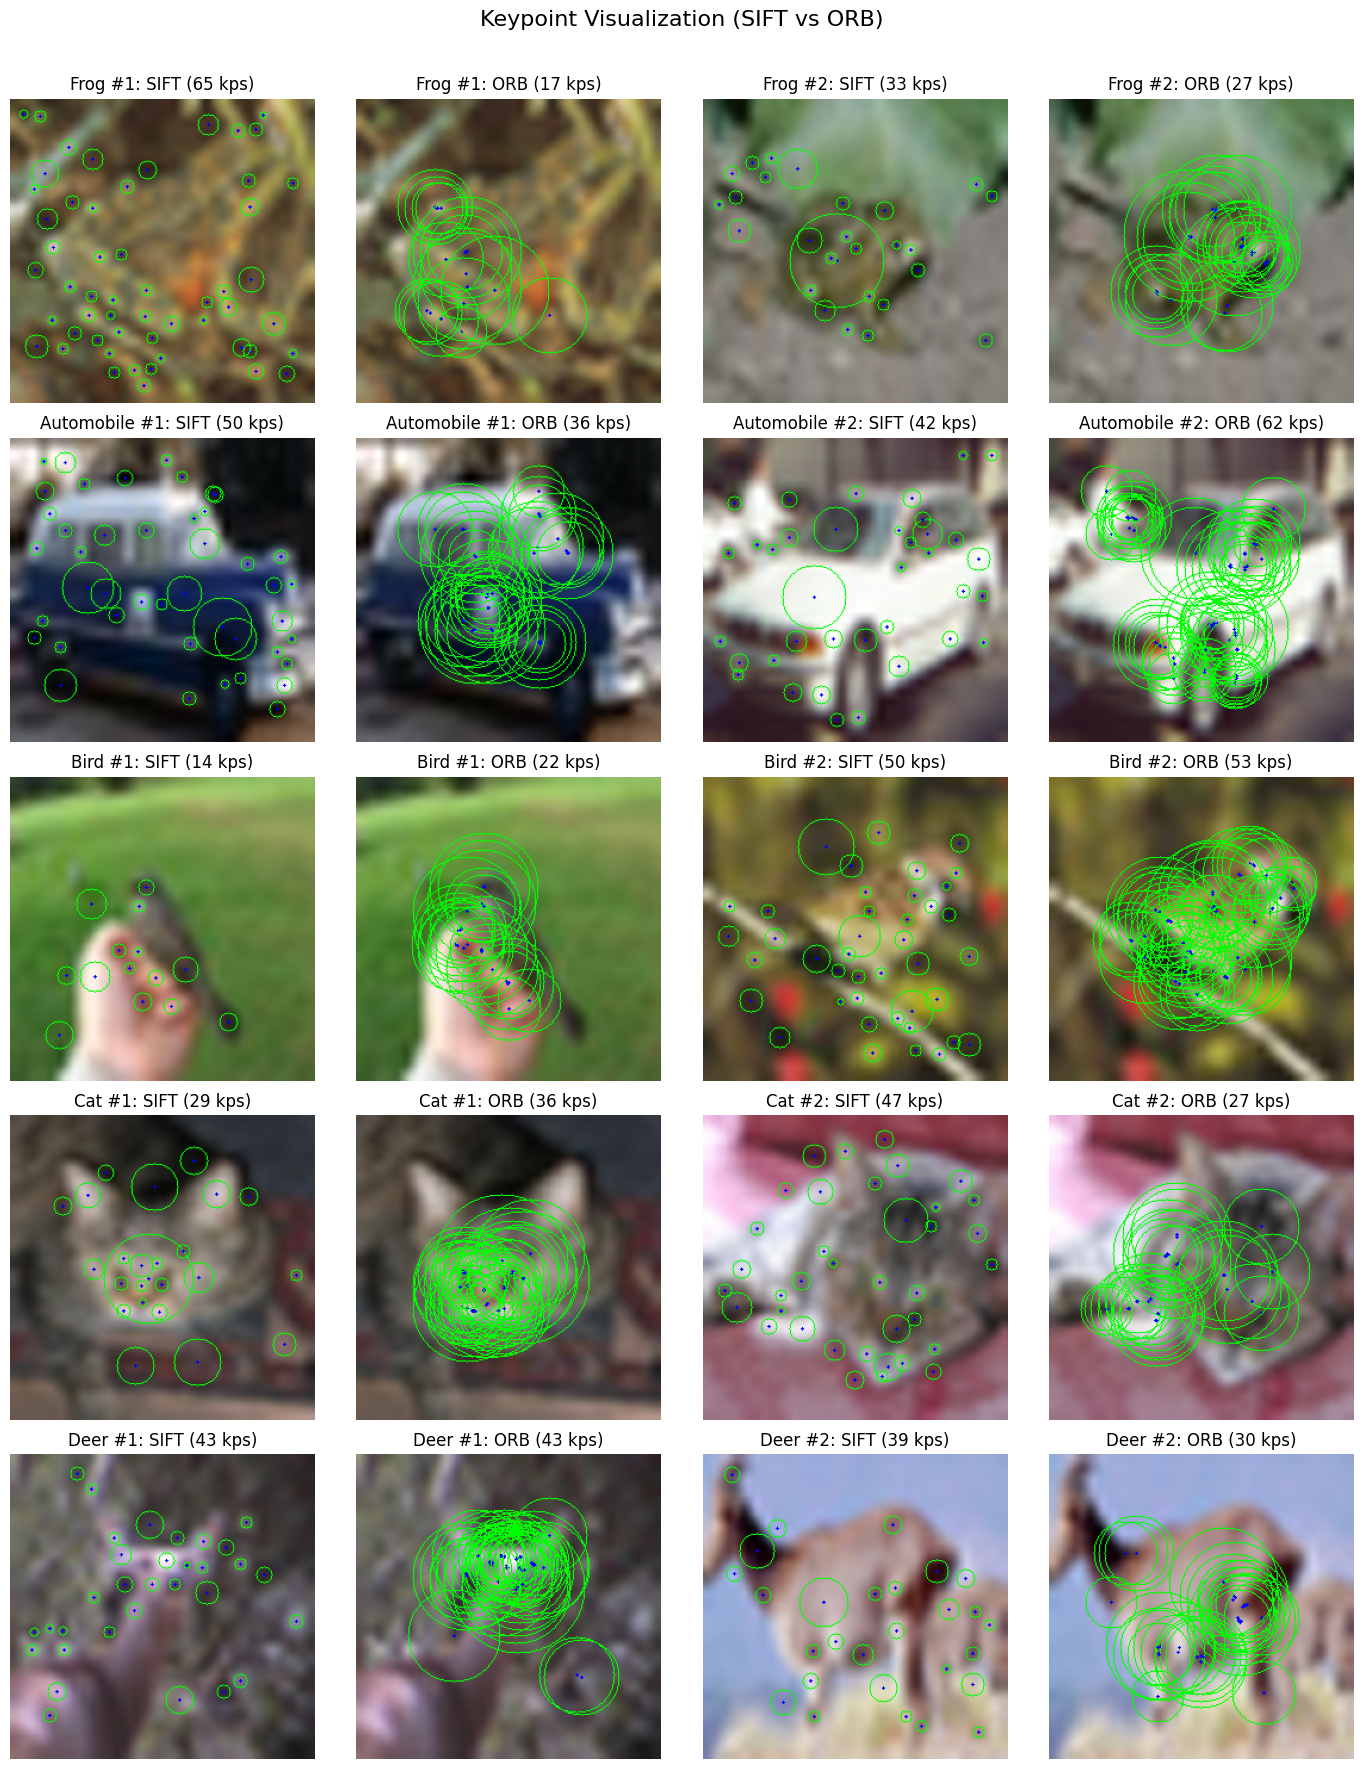

In [ ]:
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# The Feature Extractors: SIFT and ORB
sift = cv2.SIFT_create(nfeatures = 500, contrastThreshold = 0.05)
orb = cv2.ORB_create(nfeatures = 500, fastThreshold = 20)

# Turn Tensor to RGB
def tensor_to_rgb(tensor_image):
    img = tensor_image.clone().cpu()
    img = img * 0.5 + 0.5
    img = (img * 255).clamp(0, 255).byte()
    img = img.permute(1,2,0).numpy()
    return img

# Select the indices per class 
def sample_per_class(labels):
    class_to_indices = {}
    sampled = []
    
    for idx, label in enumerate (labels):
        class_to_indices.setdefault(label, []).append(idx)

    for label in sorted(class_to_indices.keys()):
        sampled.extend(random.sample(class_to_indices[label], 2))
    return sampled

# # Select the images (randomly)
sample_indices = sample_per_class(train_mapped_labels)
print(f"Randomly Selected Indices: {sample_indices}")

# Get top N keypoints 
def top_keypoints (kps, des, N = 150):
    if len(kps) == 0:
        return [], None

    order = np.argsort([-kp.response for kp in kps])[:N]
    top_kps = [kps[i] for i in order]
    top_des = des[order] if des is not None else None
    return top_kps, top_des

# Draw circles around the keypoints
def draw_kps (img_rgb, keypoints, max_to_draw = 150):
    out = img_rgb.copy()
    for kp in keypoints[:max_to_draw]:
        x,y = int(round(kp.pt[0])), int(round(kp.pt[1]))
        radius = max(1, int(round(kp.size / 2)))
        cv2.circle(out, (x,y), radius, (0, 255, 0), 1)
        cv2.circle(out, (x,y), 1, (0,0,255), -1)
    return out

# Visualization

# Grid
fig, axes = plt.subplots(5, 4, figsize=(14, 18))
fig.suptitle("Keypoint Visualization (SIFT vs ORB)", fontsize=16)

class_names = ["Frog", "Automobile", "Bird", "Cat", "Deer"]
image_count = 0

for class_idx, class_name in enumerate(class_names):
    class_samples = [i for i in sample_indices if train_mapped_labels[i] == class_idx]
    for j, idx in enumerate(class_samples):
        tensor_img, _ = filtered_train_set[idx]
        rgb_img = tensor_to_rgb(tensor_img)
        up = cv2.resize(rgb_img, (256, 256), interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(up, cv2.COLOR_RGB2GRAY)

        # Detect keypoints
        kp_sift, des_sift = sift.detectAndCompute(gray, None)
        kp_orb, des_orb = orb.detectAndCompute(gray, None)

        # Keep top keypoints
        kp_sift, des_sift = top_keypoints(kp_sift, des_sift, 150)
        kp_orb, des_orb = top_keypoints(kp_orb, des_orb, 150)

        # Draw
        vis_sift = draw_kps(up, kp_sift)
        vis_orb = draw_kps(up, kp_orb)

        # Display in grid
        row = class_idx
        col_base = j * 2
        axes[row, col_base].imshow(vis_sift)
        axes[row, col_base].set_title(f"{class_name} #{j+1}: SIFT ({len(kp_sift)} kps)")
        axes[row, col_base+1].imshow(vis_orb)
        axes[row, col_base+1].set_title(f"{class_name} #{j+1}: ORB ({len(kp_orb)} kps)")

        for c in [col_base, col_base+1]:
            axes[row, c].axis("off")

        # Stats
        print(f"Class: {class_name}, Image #{j+1}")
        print(f"SIFT: |Keypoints: {len(kp_sift)}| Descriptor Shape: {None if des_sift is None else des_sift.shape}|")
        print(f"ORB: |Keypoints: {len(kp_orb)}| Descriptor Shape: {None if des_orb is None else des_orb.shape}|")
        print("-"*60)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<a id="section-3"></a>
### **Section 3: Building the Visual Vocabulary (3 points)**

In this section, the task is to create a visual vocabulary by clustering feature descriptors extracted from the images using K-Means. Each cluster center in this vocabulary will represent a visual word. Use the two different extraction techniques you implemented to extract descriptors from a subset of training images that includes all categories, and then apply K-Means clustering to build the vocabulary. The number of clusters is fixed at 1000, but you can experiment with different values when you are tuning the hyperparameters in section 9.

To examine the effect of different amounts of training data, build separate visual vocabularies using 30%, 40%, and 50% subsets of the training images. For faster clustering, the `faiss` library can be used, as it provides an efficient implementation of K-Means. Then, visualize the first 10 clusters for each feature extraction technique and each subset size using PCA to reduce the dimensions to 2D.

**Hints:**
1. Begin by debugging the code with a small number of input images to ensure it functions correctly before running it on larger datasets.
2. If the `faiss` library is not available, K-Means clustering can also be performed using the `sklearn` or `scipy` libraries.
3. For visualization, use PCA from `sklearn.decomposition` to reduce the high-dimensional descriptors to 2D. Display up to 10 clusters in the scatter plot to maintain clarity.

Building Vocabularies for SIFT

Processing 1500 images (30%) for SIFT.


Extracting SIFT features: 100%|██████████| 1500/1500 [00:03<00:00, 384.71img/s]


Total descriptors collected: (59929, 128)
Processing Kmeans with 1000 clusters, dim = 128.
Vocabulary built for SIFT (30%) -> (1000, 128)

Processing 2000 images (40%) for SIFT.


Extracting SIFT features: 100%|██████████| 2000/2000 [00:05<00:00, 393.05img/s]


Total descriptors collected: (79256, 128)
Processing Kmeans with 1000 clusters, dim = 128.
Vocabulary built for SIFT (40%) -> (1000, 128)

Processing 2500 images (50%) for SIFT.


Extracting SIFT features: 100%|██████████| 2500/2500 [00:05<00:00, 417.45img/s]


Total descriptors collected: (99319, 128)
Processing Kmeans with 1000 clusters, dim = 128.
Vocabulary built for SIFT (50%) -> (1000, 128)
Building Vocabularies for ORB

Processing 1500 images (30%) for ORB.


Extracting ORB features: 100%|██████████| 1500/1500 [00:01<00:00, 1216.54img/s]


Total descriptors collected: (39063, 32)
Processing Kmeans with 1000 clusters, dim = 32.
Vocabulary built for ORB (30%) -> (1000, 32)

Processing 2000 images (40%) for ORB.


Extracting ORB features: 100%|██████████| 2000/2000 [00:01<00:00, 1219.34img/s]


Total descriptors collected: (51840, 32)
Processing Kmeans with 1000 clusters, dim = 32.
Vocabulary built for ORB (40%) -> (1000, 32)

Processing 2500 images (50%) for ORB.


Extracting ORB features: 100%|██████████| 2500/2500 [00:01<00:00, 1251.78img/s]


Total descriptors collected: (66433, 32)
Processing Kmeans with 1000 clusters, dim = 32.
Vocabulary built for ORB (50%) -> (1000, 32)


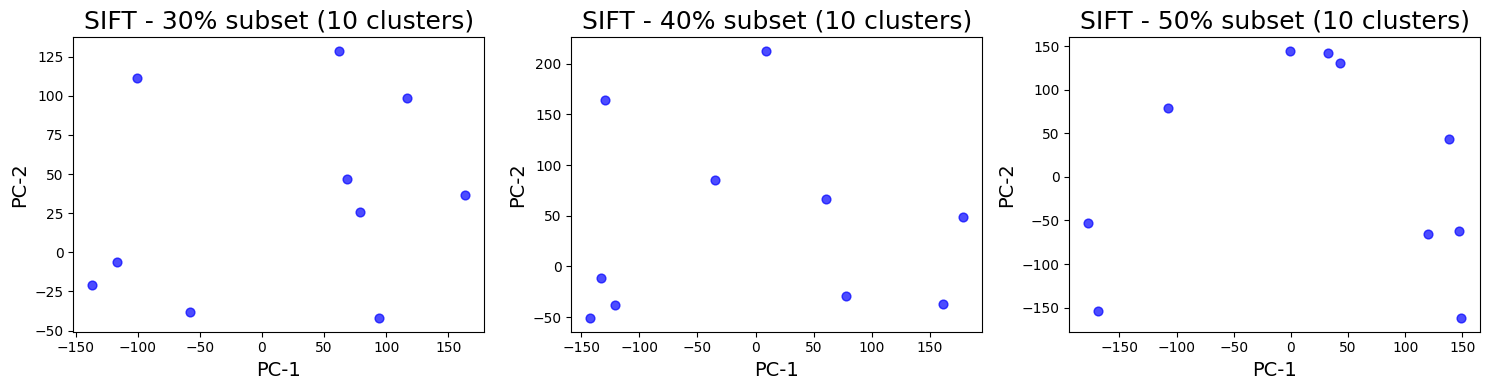

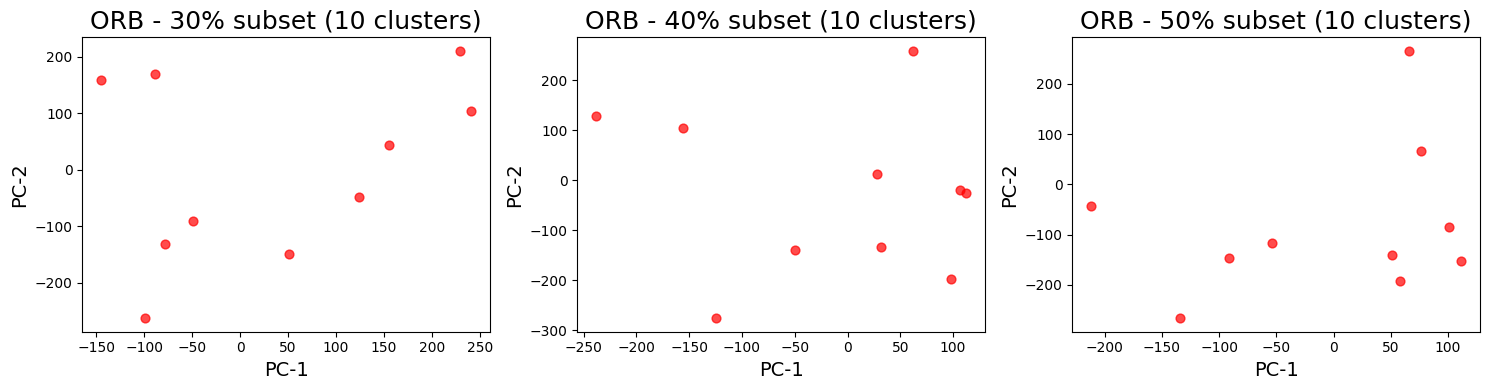


All vocabularies built and visualized!


In [ ]:
import faiss
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt

# The Feature Extractors: SIFT and ORB
sift = cv2.SIFT_create(nfeatures=500, contrastThreshold=0.05)
orb = cv2.ORB_create(nfeatures=500, fastThreshold=20)

# Vocabulary Build Configuration
subset_fracs = [0.3, 0.4, 0.5]
num_clusters = 1000
max_descriptors = 100000
total_train_images = len(filtered_train_set)

vocabs = {"SIFT": {},
          "ORB": {}}

# First, build all vocabularies
for method in ["SIFT", "ORB"]:
    print(f"Building Vocabularies for {method}")

    # Iterate over each subset fraction
    for frac in subset_fracs:
        subset_size = int(frac * total_train_images)
        subset_indices = random.sample(range(total_train_images), subset_size)
        print(f"\nProcessing {subset_size} images ({int(frac*100)}%) for {method}.")

        # Extract Descriptors
        descriptor_list = []
        for idx in tqdm(subset_indices, desc=f"Extracting {method} features", unit="img"):
            tensor_img, _ = filtered_train_set[idx]
            rgb_img = tensor_to_rgb(tensor_img)
            up = cv2.resize(rgb_img, (128, 128), interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(up, cv2.COLOR_RGB2GRAY)

            # Get keypoints and compute descriptors based on method (SIFT/ORB)
            if method == "SIFT":
                _, des = sift.detectAndCompute(gray, None)
            else:
                _, des = orb.detectAndCompute(gray, None)

            if des is not None:
                des = des.astype(np.float32)
                descriptor_list.append(des)

        if not descriptor_list:
            print(f"No descriptor for {method} ({int(frac*100)}%) subset.")
            continue

        # Stack descriptors 
        all_des = np.vstack(descriptor_list).astype(np.float32)
        print(f"Total descriptors collected: {all_des.shape}")

        # Descriptor dimension
        dim = all_des.shape[1]
        print(f"Processing Kmeans with {num_clusters} clusters, dim = {dim}.")

        # Train using FAISS
        kmeans = faiss.Kmeans(dim, num_clusters, niter=100, verbose=True, seed=42)
        kmeans.train(all_des)

        # Extract cluster centers
        vocab = kmeans.centroids
        vocabs[method][frac] = vocab
        print(f"Vocabulary built for {method} ({int(frac*100)}%) -> {vocab.shape}")

# Create side-by-side plots for SIFT
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, frac in enumerate(subset_fracs):
    if frac in vocabs["SIFT"]:
        vocab = vocabs["SIFT"][frac]
        
        # Use PCA to reduce dimensionality
        pca = PCA(n_components=2)
        vocab_2d = pca.fit_transform(vocab)
        
        # Sample up to 10 clusters
        n_samples = min(10, vocab_2d.shape[0])
        sampled_idxs = np.random.choice(vocab_2d.shape[0], n_samples, replace=False)
        sample_points = vocab_2d[sampled_idxs]
        
        # Plot
        axes[idx].scatter(sample_points[:, 0], sample_points[:, 1], c='blue', s=40, alpha=0.7)
        axes[idx].set_title(f"SIFT - {int(frac*100)}% subset ({n_samples} clusters)", fontsize = 18)
        axes[idx].set_xlabel("PC-1", fontsize = 14)
        axes[idx].set_ylabel("PC-2", fontsize = 14)
        
plt.tight_layout()
plt.show()

# Create side-by-side plots for ORB
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, frac in enumerate(subset_fracs):
    if frac in vocabs["ORB"]:
        vocab = vocabs["ORB"][frac]
        
        # Use PCA to reduce dimensionality
        pca = PCA(n_components=2)
        vocab_2d = pca.fit_transform(vocab)
        
        # Sample up to 10 clusters
        n_samples = min(10, vocab_2d.shape[0])
        sampled_idxs = np.random.choice(vocab_2d.shape[0], n_samples, replace=False)
        sample_points = vocab_2d[sampled_idxs]
        
        # Plot
        axes[idx].scatter(sample_points[:, 0], sample_points[:, 1], c='red', s=40, alpha=0.7)
        axes[idx].set_title(f"ORB - {int(frac*100)}% subset ({n_samples} clusters)",fontsize = 18)
        axes[idx].set_xlabel("PC-1", fontsize = 14)
        axes[idx].set_ylabel("PC-2", fontsize = 14)
        
plt.tight_layout()
plt.show()

print("\nAll vocabularies built and visualized!")

<a id="section-4"></a>
### **Section 4: Encoding Train Image Features (3 points)**

In this section, the task is to encode image features using the visual vocabulary created earlier. Each image will be represented as a histogram of visual words, reflecting the frequency of each visual word in the image. This representation will allow for comparing images based on their visual content.

To encode an image, identify the nearest visual word (cluster center) for each feature descriptor extracted from the image. Construct a histogram that counts the occurrences of each visual word within the image. The final output will be a collection of histograms, one for each image, where each histogram serves as the feature representation of that image. Once again,  Use the two different extraction techniques you implemented to extract descriptors from the images. Then, encode the images using the visual vocabulary created in the previous step.

**Hint:** Utilize the `faiss` library for efficient nearest neighbor search when assigning each descriptor to the nearest cluster center in the visual dictionary. If `faiss` is not available, consider using other libraries, such as `scikit-learn`, for this step. Once the histograms are obtained, they will be used for further tasks, such as training a classifier. For now, perform the encoding only for the training set.

In [ ]:
subset_frac = 0.5
num_clusters = vocabs["SIFT"][subset_frac].shape[0]

faiss_index_sift = faiss.IndexFlatL2(vocabs["SIFT"][subset_frac].shape[1])
faiss_index_sift.add(vocabs["SIFT"][subset_frac])

faiss_index_orb = faiss.IndexFlatL2(vocabs["ORB"][subset_frac].shape[1])
faiss_index_orb.add(vocabs["ORB"][subset_frac])

# The Feature Extractors: SIFT and ORB
sift = cv2.SIFT_create(nfeatures = 500, contrastThreshold = 0.05)
orb = cv2.ORB_create(nfeatures = 500, fastThreshold = 20)

def compute_bow_histogram(descriptors, faiss_index, num_clusters):
    hist = np.zeros(num_clusters, dtype = np.float32)
    if descriptors is not None and len(descriptors) > 0:
        descriptors = descriptors.astype(np.float32)
        _, indices = faiss_index.search(descriptors, 1)
        for idx in indices:
            hist[idx[0]] += 1

    if np.sum(hist) > 0:
        hist = hist / np.sum(hist)
    return hist

train_hist_sift = []
train_hist_orb = []

print("Encoding training images in BOW histograms...")

for i, (tensor_img, _) in enumerate(tqdm(filtered_train_set, 
                                        desc="Encoding images", 
                                        unit="img")):
    
    rgb_img = tensor_to_rgb(tensor_img)
    up = cv2.resize(rgb_img, (128, 128), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(up, cv2.COLOR_RGB2GRAY)
 
    _, des_sift = sift.detectAndCompute(gray, None)
    hist_sift = compute_bow_histogram(des_sift, faiss_index_sift, num_clusters)
    train_hist_sift.append(hist_sift)
    
    _, des_orb = orb.detectAndCompute(gray, None)
    hist_orb = compute_bow_histogram(des_orb, faiss_index_orb, num_clusters)
    train_hist_orb.append(hist_orb)

train_hist_sift = np.vstack(train_hist_sift)
train_hist_orb = np.vstack(train_hist_orb)
train_label = np.array(train_mapped_labels)

print("Encode Done.")
print(f"SIFT Histograms: {train_hist_sift.shape}")
print(f"ORB Histograms: {train_hist_orb.shape}")
print(f"Train Labels: {train_labels.shape}")

Encoding training images in BOW histograms...


Encoding images: 100%|██████████| 5000/5000 [00:34<00:00, 145.92img/s]

Encode Done.
SIFT Histograms: (5000, 1000)
ORB Histograms: (5000, 1000)
Train Labels: torch.Size([5000])


<a id="section-5"></a>
### **Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)**

In this section, the task is to visualize the Bag of Visual Words for each class using the histograms generated in the previous step. The goal is to plot the mean histogram of visual words for each class, showing the distribution of visual words across the different categories in the training set.

Use the two different extraction techniques you implemented for this visualization. For each technique, calculate the mean histogram for each class and create a bar plot to display these histograms. Ensure that the plots are labeled clearly with the class names and feature descriptor types.

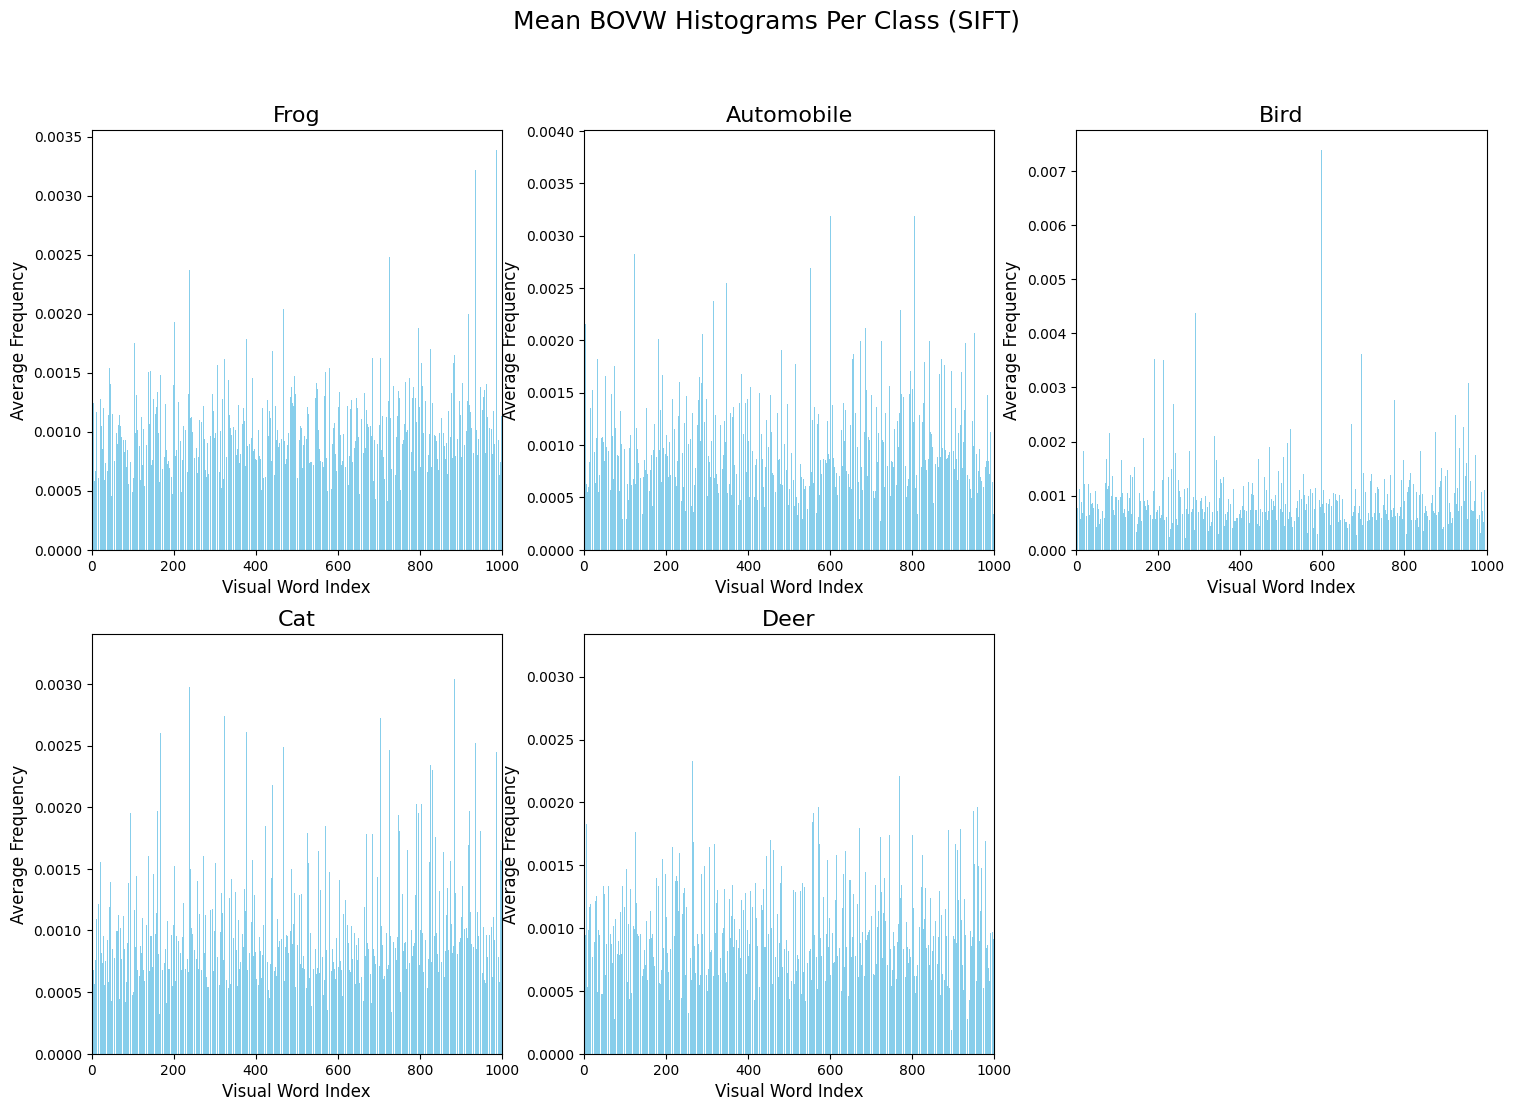

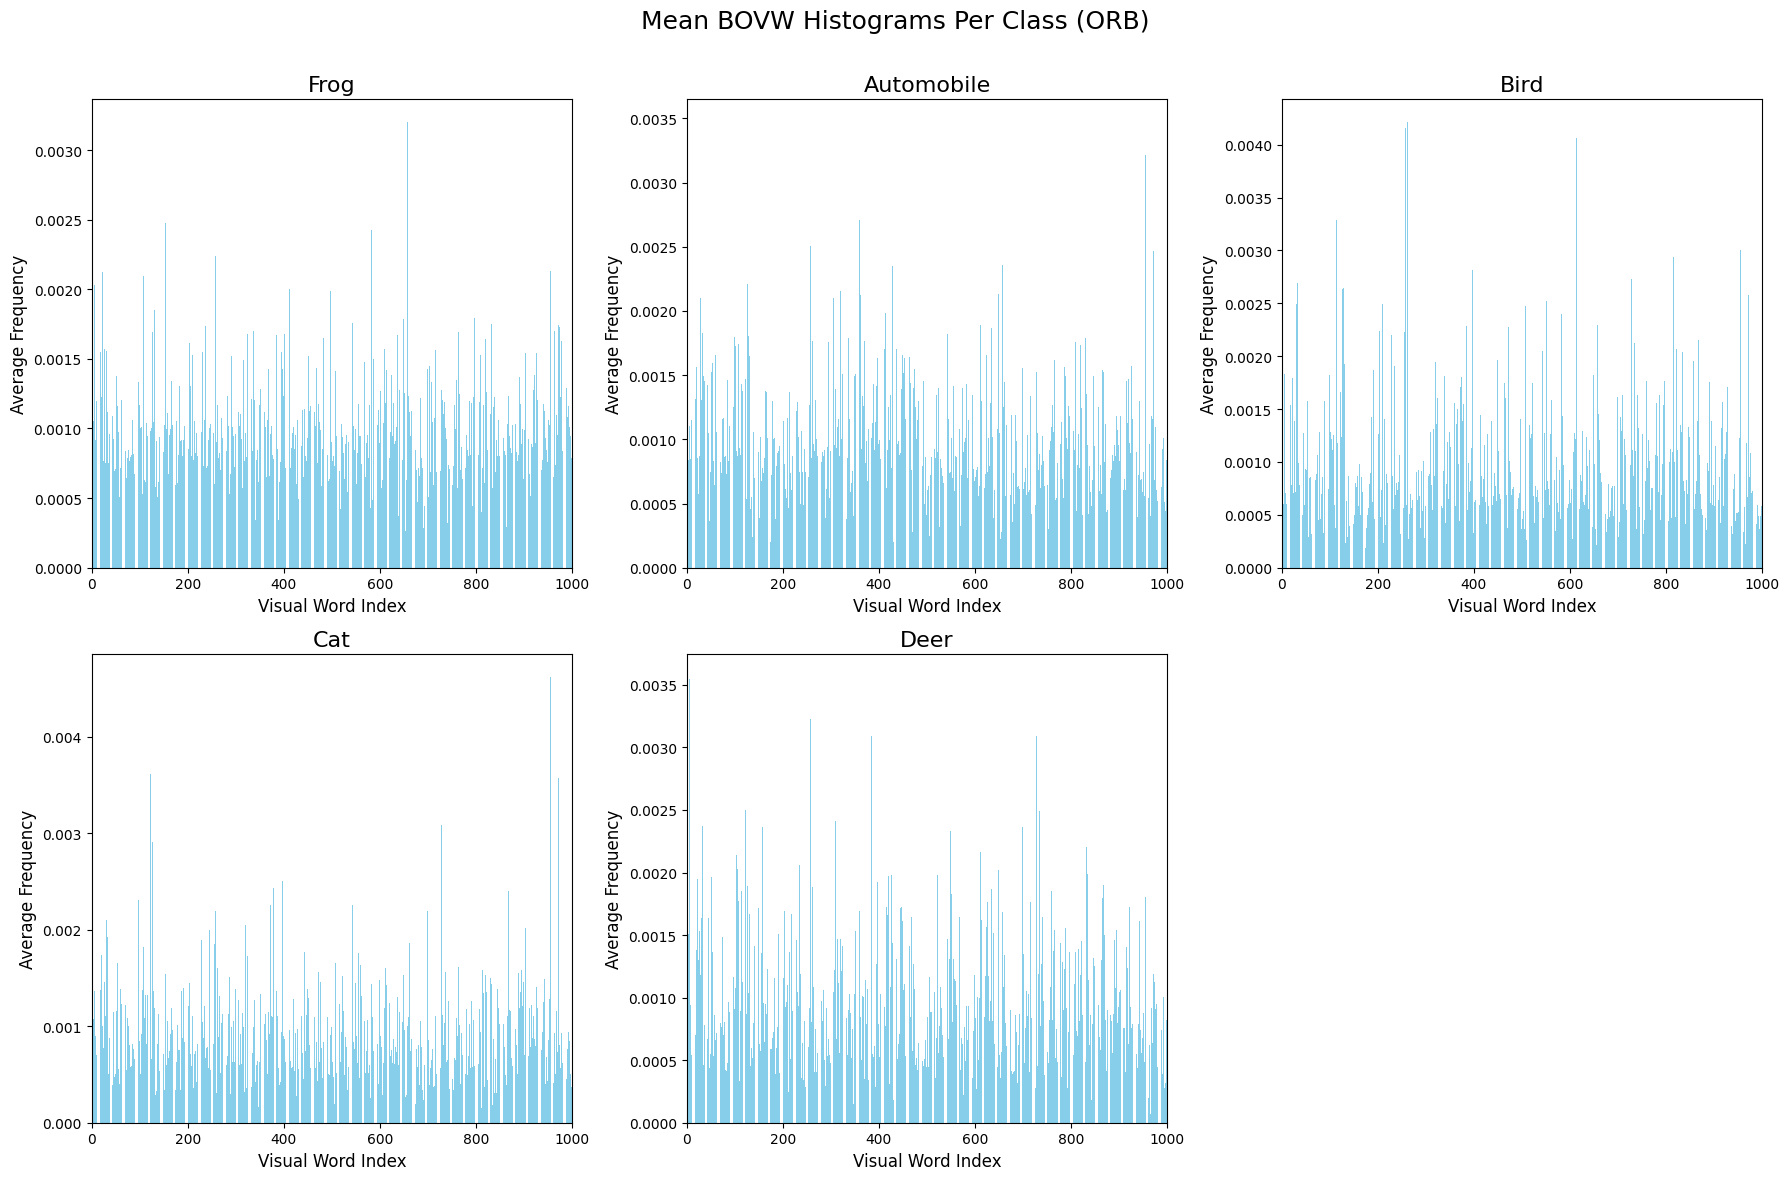

In [ ]:
class_names = ["Frog", "Automobile", "Bird", "Cat", "Deer"]
num_classes = len(class_names)
num_clusters = train_hist_sift.shape[1]

for method, histograms in [("SIFT", train_hist_sift), ("ORB", train_hist_orb)]:
    plt.figure(figsize = (18, 12))
    plt.suptitle(f"Mean BOVW Histograms Per Class ({method})", fontsize = 18)

    for class_idx, class_name in enumerate(class_names):

        class_hist = histograms[train_labels == class_idx]
        mean_hist = np.mean(class_hist, axis = 0)

        ax = plt.subplot(2,3, class_idx + 1)
        ax.bar(np.arange(num_clusters), mean_hist, color = "skyblue")
        ax.set_title(class_name, fontsize = 16)
        ax.set_xlabel("Visual Word Index", fontsize = 12)
        ax.set_ylabel("Average Frequency", fontsize = 12)
        ax.set_xlim([0, num_clusters])
        
plt.tight_layout(rect = [0,0,1,0.97])
plt.show()

<a id="section-6"></a>
### **Section 6: Encoding Test Image Features (0 points)**

In this section, the task is to encode the test image features using the visual vocabulary created from the training set. Similar to the previous encoding step, each test image will be represented as a histogram of visual words, which will then be used for evaluating classification performance.

Use the same two feature extraction techniques you selected earlier. Extract keypoints and descriptors for the test images, then encode these images using the visual vocabulary. This will allow you to compare the encoded features of test images against those of the training set.

**Hint:** Reuse the functions developed earlier for extracting keypoints, descriptors, and encoding images. Ensure that you use the visual vocabulary constructed with the training images for consistency.

In [ ]:
test_des_sift = []
test_des_orb = []

sift = cv2.SIFT_create(nfeatures = 500, contrastThreshold = 0.03)
orb = cv2.ORB_create(nfeatures = 500, fastThreshold = 20)

# Visual Vocabs using 50% of training data
vocab_sift = vocabs["SIFT"][0.5]
vocab_orb  = vocabs["ORB"][0.5]

print("Encoding test images.")

# Get descriptors 
for img in test_images:

    # Convert tensor to numpy
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        
    # Convert back to pixel space + RGB -> BGR -> Gray
    img = ((img * 0.5 + 0.5) * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and compute descriptors (SIFT/ORB)
    _, des_sift = sift.detectAndCompute(gray, None)
    _, des_orb = orb.detectAndCompute(gray, None)

    if des_sift is not None:
        des_sift = des_sift.astype(np.float32)
    if des_orb is not None:
        des_orb = des_orb.astype(np.float32)

    # Append descriptors
    test_des_sift.append(des_sift)
    test_des_orb.append(des_orb)

print("Features Extracted.")

def encode_images (descriptor_list, vocab):

    num_clusters = vocab.shape[0] # Number of visual words (cluster)
    dim = vocab.shape[1] # Descriptor dimension

    index = faiss.IndexFlatL2(dim)
    index.add(vocab) # Add center to the index
        
    histograms = [] 
    for des in descriptor_list:
        if des is None:
            histograms.append(np.zeros(num_clusters))
            continue

        # Find nearest cluster center for each descriptor
        distances, assignments = index.search(des, 1) 

        # Build histogram (how many descriptors per cluster) and normalize it
        histogram, _ = np.histogram(assignments, bins = np.arange(num_clusters + 1))
        histogram = histogram.astype(np.float32)
        histogram /= (np.sum(histogram) + 1e-7)
        histograms.append(histogram)
    return np.array(histograms, dtype = np.float32)

# Encode and Test
print("Encoding Complete!")
test_hist_sift = encode_images(test_des_sift, vocab_sift)
test_hist_orb  = encode_images(test_des_orb, vocab_orb)

print(f"SIFT Histograms: {test_hist_sift.shape}")
print(f"ORB Histograms: {test_hist_orb.shape}")

Encoding test images.
Features Extracted.
Encoding Complete!
SIFT Histograms: (1000, 1000)
ORB Histograms: (1000, 1000)


<a id="section-7"></a>
### **Section 7: Training the Classifiers (5 points)**

In this section, the task is to create two one-vs-rest (OvR) SVM classifiers using the 50% of the training data that was **not** used for creating the visual dictionary. This ensures that the classifiers are trained on a different subset of data, providing a more robust evaluation of the visual vocabulary's effectiveness.

For each of the two selected feature extraction techniques, create one-vs-rest classifiers for all classes. For now, use default parameter values when training the classifiers; you will experiment with different hyperparameters in later steps.

**Note:** Training an OvR classifier can take around 5 to 7 minutes. Therefore, it's advisable to first test your code with a smaller subset of the training data to verify that your implementation works correctly before running it on the full dataset.

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

features_sift = np.array(train_hist_sift)
features_orb = np.array(train_hist_orb)
labels = np.array(train_labels)

# Split 50% for SVM training
features_sift_dict, features_sift_svm, labels_dict, labels_svm = train_test_split(
    features_sift, labels, test_size=0.5, random_state=42, stratify=labels
)

features_orb_dict, features_orb_svm, _, _ = train_test_split(
    features_orb, labels, test_size=0.5, random_state=42, stratify=labels
)

labels_svm = labels_svm.reshape(-1)  # ensure 1D array

# Train SVM classifiers
print("Training Start...")

print("Train for SIFT")
svm_sift = SVC(kernel='linear', decision_function_shape='ovr', probability=True, random_state=42)
svm_sift.fit(features_sift_svm, labels_svm)

print("Train for ORB")
svm_orb = SVC(kernel='linear', decision_function_shape='ovr', probability=True, random_state=42)
svm_orb.fit(features_orb_svm, labels_svm)

print("SVM Trained")

Training Start...
Train for SIFT


C:\Users\bodga\AppData\Local\Temp\ipykernel_7924\4060825944.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(train_labels)


Train for ORB
SVM Trained


<a id="section-8"></a>
### **Section 8: Evaluating the Classifiers (12 points)**

In this section, you will evaluate the performance of your one-vs-rest (OvR) SVM classifiers on the test data. The goal is to classify each test image using each binary classifier and rank the images based on the classification scores, resulting in a ranked list of images for each class. Ideally, images belonging to the target class should appear at the top of the respective list. To conduct this evaluation, use the test image histograms generated earlier for the two selected feature extraction techniques. Classify each test image with each classifier, rank them based on their confidence scores, and then compute the Mean Average Precision (mAP) across all classes. The mAP for a single class $c$ is defined as:

$
\text{mAP}_c = \frac{1}{m_c} \sum_{i=1}^{n} \frac{f_c(x_i)}{i}
$

where:
- $n$ is the total number of images ($n = 50 \times 5 = 250$),
- $m_c$ is the number of images of class $c$ ($m_c = 50$),
- $x_i$ is the $i^{th}$ image in the ranked list $X = \{ x_1, x_2, \dots, x_n \}$,
- $f_c$ is a function that returns the number of images of class $c$ in the first $i$ images if $x_i$ is of class $c$, and 0 otherwise.

For instance, if you are retrieving images of class "R" and the sequence of ranked images is $[R, R, T, R, T, T, R, T]$, then $n = 8$, $m_c = 4$, and:

$
AP = \frac{1}{4} \left( \frac{1}{1} + \frac{2}{2} + \frac{0}{3} + \frac{3}{4} + \frac{0}{5} + \frac{0}{6} + \frac{4}{7} + \frac{0}{8} \right).
$

In addition to the quantitative analysis, perform a qualitative analysis by visualizing the top-5 and bottom-5 ranked test images.

Evaluating SIFT...
AP for Frog:  0.2573
AP for Automobile:  0.5014
AP for Bird:  0.3809
AP for Cat:  0.2639
AP for Deer:  0.2530
Mean Average Precision (mAP): 0.3313

Evaluating ORB...
AP for Frog:  0.2097
AP for Automobile:  0.1925
AP for Bird:  0.2017
AP for Cat:  0.2108
AP for Deer:  0.2108
Mean Average Precision (mAP): 0.2051


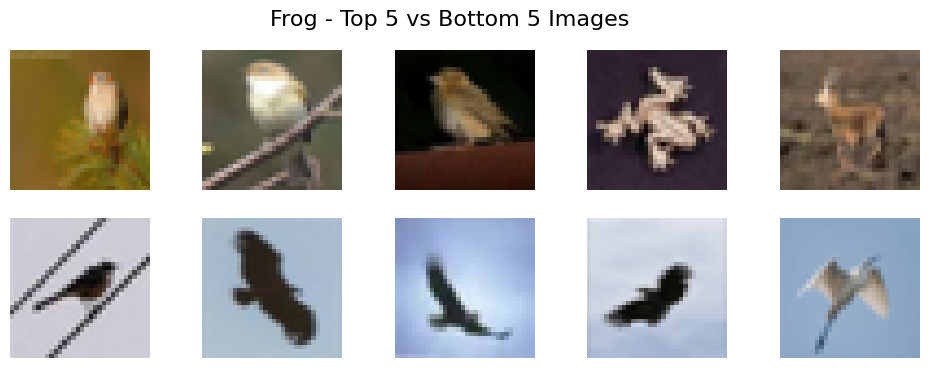

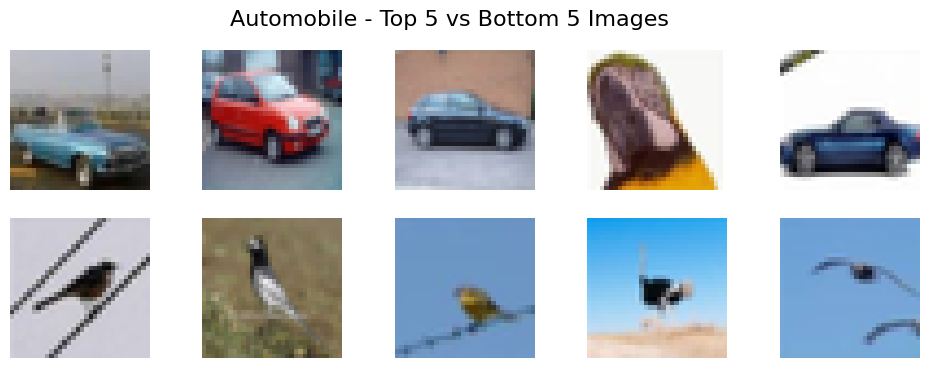

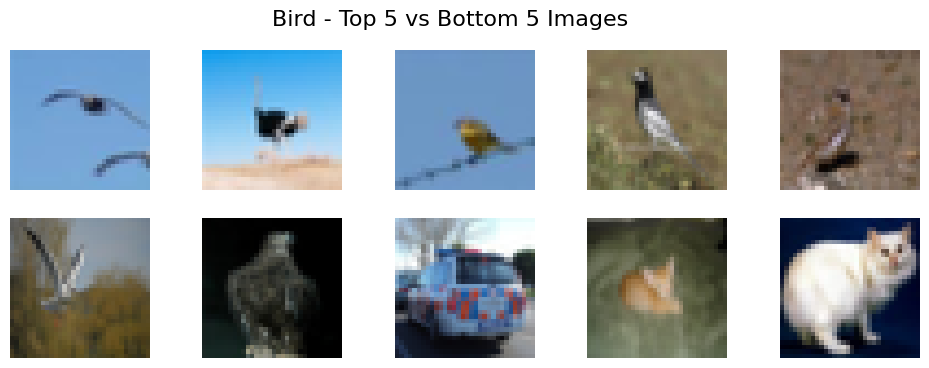

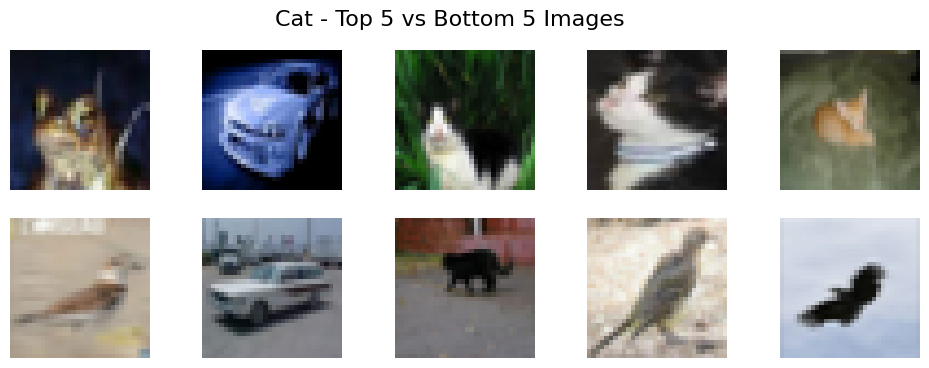

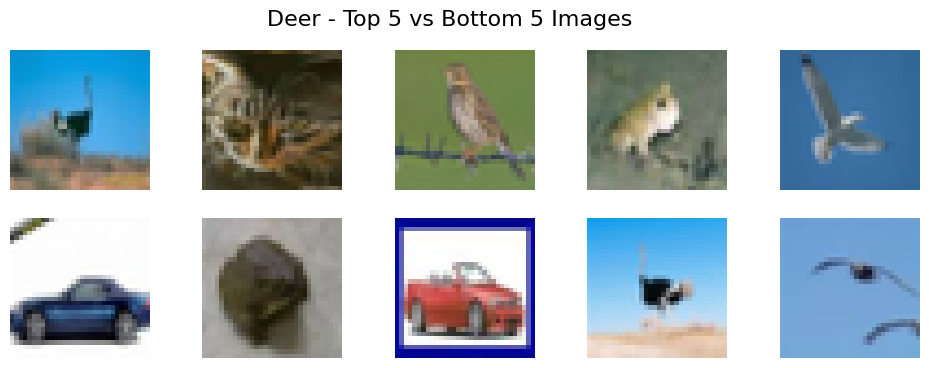

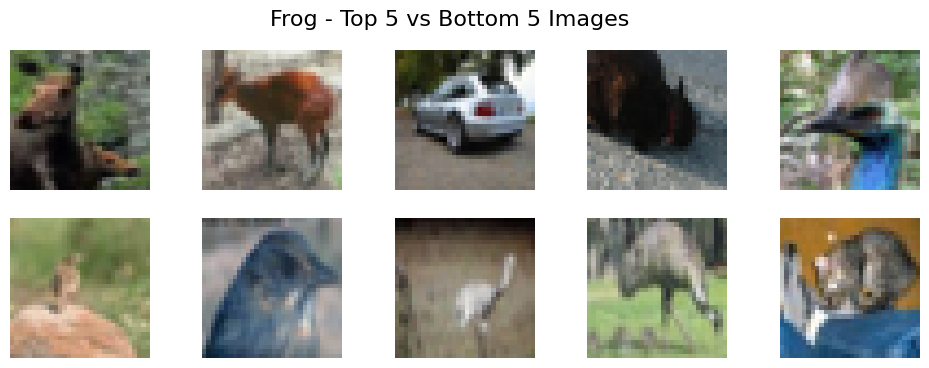

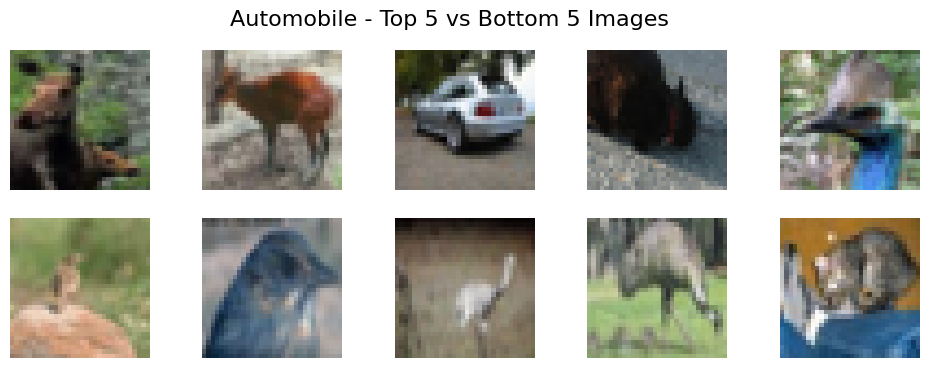

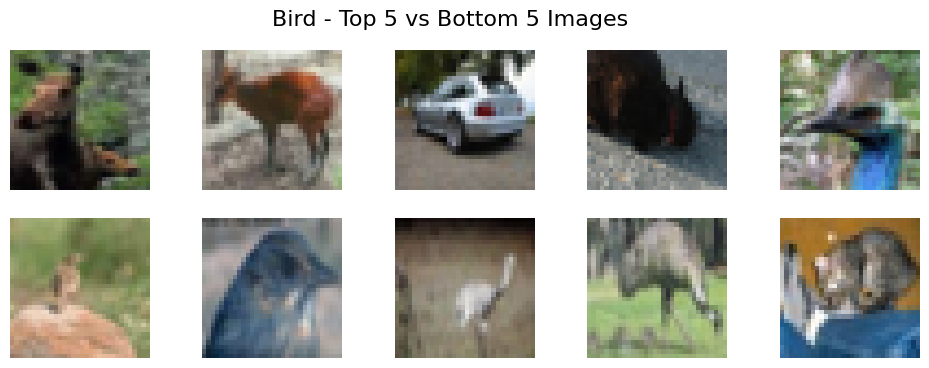

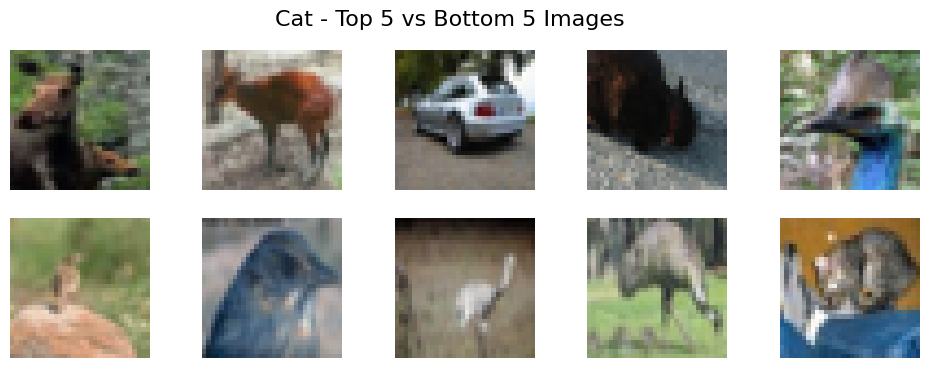

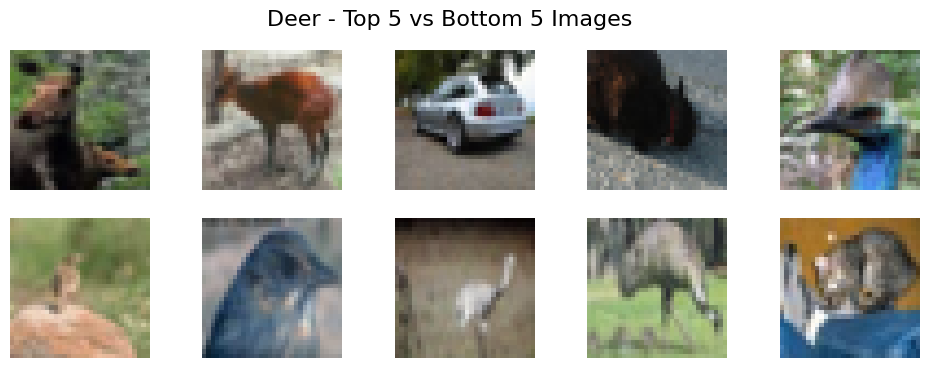

In [ ]:
# Compute Average Precision (AP) for one class
def compute_ap(scores, labels, target_class):

    # Rank images by descending classifier confidence
    ranked_idx = np.argsort(-scores)
    ranked_labels = labels[ranked_idx]

    # Number of images belonging to class
    m_c = np.sum(ranked_labels == target_class)
    if m_c == 0:
        return 0

    num_correct = 0
    ap_sum = 0

    # Go through the ranked list and compute the precision at each true positive
    for i, label in enumerate(ranked_labels, start = 1):
        if label == target_class:
            num_correct += 1
            ap_sum += num_correct / i

    # Average precision = mean of precisions at all true positive ranks 
    return ap_sum / m_c

# Evaluate mAP (Mean Average Precision) for all classes
def evaluate_map(svm_model, test_features, test_labels, class_names):

    # Get decision function scores (one per class per test image)
    scores = svm_model.decision_function(test_features)
    num_classes = len(class_names)
    aps = []

    # Get AP per class
    for c in range(num_classes):
        ap = compute_ap(scores[:, c], test_labels, c)
        aps.append(ap)
        print(f"AP for {class_names[c]}: {ap: .4f}")

    # Get mAP
    mAP = np.mean(aps)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    return aps, mAP, scores

print("Evaluating SIFT...")
aps_sift, map_sift, scores_sift = evaluate_map(svm_sift, test_hist_sift, test_labels.numpy(), class_names)

print("\nEvaluating ORB...")
aps_orb, map_orb, scores_orb = evaluate_map(svm_orb, test_hist_orb, test_labels.numpy(), class_names)

# Visualize top-5 and bottom-5 
def visualize_top_bottom(scores, test_images, test_labels, class_names, top_k = 5):
    
    for c, class_name in enumerate(class_names):
        # Rank test images for class
        ranked_idx = np.argsort(-scores[:, c])
        top_idx = ranked_idx[:top_k]
        bottom_idx = ranked_idx[-top_k:]

        plt.figure(figsize = (12, 4))
        plt.suptitle(f"{class_name} - Top {top_k} vs Bottom {top_k} Images", fontsize = 16)

        # Top-ranked
        for i, idx in enumerate(top_idx):
            plt.subplot(2, top_k, i + 1)
            img = ((test_images[idx].numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
            plt.imshow(img)
            plt.axis('off')
            if i == 0: plt.ylabel("Top", fontsize = 12)

        # Bottom-ranked
        for i, idx in enumerate(bottom_idx):
            plt.subplot(2, top_k, top_k + i + 1)
            img = ((test_images[idx].numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
            plt.imshow(img)
            plt.axis('off')
            if i == 0: plt.ylabel("Top", fontsize = 12)

visualize_top_bottom(scores_sift, test_images, test_labels, class_names, top_k=5)
visualize_top_bottom(scores_orb, test_images, test_labels, class_names, top_k=5)

<a id="section-9"></a>
### **Section 9: Hyperparameter Search (16 points)**

In this section, the task is to perform an extensive hyperparameter search to optimize the performance of your classifiers. You will experiment with various parameters, including the number of visual words (e.g., 500, 1000, 1500), different training subset sizes (e.g., 30%, 40%, 50%), SVM parameters (e.g., kernel types like 'linear' or 'rbf', regularization parameter $C$ values such as 0.1, 1, 10, and gamma settings like 'scale' or specific values such as 0.01, 0.001), and settings of the feature extractors (e.g., the number of keypoints or scale levels). Start by testing your code on the smallest subset to ensure it functions correctly before proceeding with a full hyperparameter search. Once validated, conduct the search using larger subsets and systematically iterate through the different parameter combinations, potentially using nested loops or grid search. Be sure to record the performance results for each combination to identify the best settings based on metrics like the Mean Average Precision (mAP).

In [13]:
# First, we define helper functions used for the hyperparameter tuning pipeline

# 1., Building on the feature extraction method we create a helper function responsible for extracting the features used for the BoW representation, with the method as a setable parameter and the number of features extracted (max)

# Because of errors when subsampling with the tensor transform, we are making the function more robust for different dimensions:
def tensor_to_rgb(tensor_image):
    img = tensor_image.clone().cpu() if isinstance(tensor_image, torch.Tensor) else tensor_image.copy()
    img = img * 0.5 + 0.5
    img = (img * 255).clamp(0, 255).byte() if isinstance(img, torch.Tensor) else (img * 255).astype(np.uint8)

    if isinstance(img, torch.Tensor):
        if img.ndim == 3 and img.shape[0] == 3:
            img = img.permute(1,2,0).numpy()
        else:
            img = img.numpy()
    else:
        if img.shape[0] == 3:
            img = np.transpose(img, (1,2,0))
    return img

# Feature extractor function
def extract_features(images, method="SIFT", top_n=150):
    """
    Extract feature descriptors from a list of images using SIFT or ORB.
    """
    # we initialize feature extractor
    if method == "SIFT":
        extractor = cv2.SIFT_create(nfeatures=500, contrastThreshold=0.03)
    elif method == "ORB":
        extractor = cv2.ORB_create(nfeatures=500, fastThreshold=20)
    else:
        raise ValueError("Method must be 'SIFT' or 'ORB'")  # safeguard against other non-implemented methods

    descriptors_list = []

    for img_tensor in images:   # we follow the lofic implemented in the previous section
        # we convert tensor to rgb with the helper function defined in Section 2
        rgb_img = tensor_to_rgb(img_tensor)
        up = cv2.resize(rgb_img, (256, 256), interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(up, cv2.COLOR_RGB2GRAY)
        kps, des = extractor.detectAndCompute(gray, None)
        kps, des = top_keypoints(kps, des, top_n)
        descriptors_list.append(des)

    return descriptors_list

# 2., we construct the visual vcabulary for the Bag of Words representation using the helper functionf from Section 3, and the previously defined extract_features function. We can set the hyperparameters subset_frac, method, and num_visual_words

def build_vocabulary(images, method="SIFT", num_visual_words=1000, subset_frac=0.5, top_n=150):
    """
    Build a visual vocabulary using a subset of images and a specified feature extraction method.
    Hyperparameters:
        method (str): "SIFT" or "ORB".
        num_visual_words (int): Number of visual words used for cunstructing the vocabulary.
        subset_frac (float): Fraction of images to use for vocabulary.
    """
    total_images = len(images)
    subset_size = int(subset_frac * total_images)
    subset_indices = random.sample(range(total_images), subset_size)
    subset_images = [images[i] for i in subset_indices]

    # we extract descriptors using the previously defined extract_features function
    descriptor_list = extract_features(subset_images, method=method, top_n=top_n)
    descriptor_list = [des for des in descriptor_list if des is not None]   # Remove any None descriptors


    all_descriptors = np.vstack(descriptor_list).astype(np.float32)

    # KMeans clustering with the FAISS library
    dim = all_descriptors.shape[1]
    kmeans = faiss.Kmeans(dim, num_visual_words, niter=20, verbose=True, seed=42)
    kmeans.train(all_descriptors)

    vocab = kmeans.centroids
    return vocab

# 3., we create the next step of the pipeline, where we create the histograms of the provided images using a given vocabulary, based on Section 5.
def encode_images_bow(images, vocab, method="SIFT", top_n=150):
    """
    Encodes a list of images into Bag-of-Visual-Words histograms using a given vocabulary.
    """
    num_visual_words = vocab.shape[0]

    # we create FAISS index for nn
    faiss_index = faiss.IndexFlatL2(vocab.shape[1])
    faiss_index.add(vocab.astype(np.float32))

    histograms = []

    for img_tensor in tqdm(images, desc=f"Encoding images ({method})", unit="img"):
        # we extract descriptors
        descriptors_list = extract_features([img_tensor], method=method, top_n=top_n)
        des = descriptors_list[0]  # extract_features returns a list

        # we initialize the histogram
        hist = np.zeros(num_visual_words, dtype=np.float32)

        if des is not None and len(des) > 0:
            des = des.astype(np.float32)
            _, indices = faiss_index.search(des, 1)  # find nearest visual word for each descriptor
            for idx in indices:
                hist[idx[0]] += 1

        # to normalize the histogram
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)

        histograms.append(hist)

    return np.vstack(histograms)

#4., we create a helper function based on Section 7, to train the classifier (SVM)

def train_svm_classifier(train_features, train_labels, method="SIFT", kernel="linear", C=1.0, gamma="scale"):
    """
    It trains an SVM classifier on Bag-of-Visual-Words histograms.
    Hyperparameters:
        method (str): Feature extraction method (SIFT or ORB), for logging.
        kernel (str): SVM kernel type ('linear', 'rbf', 'poly', etc).
        C (float): Regularization parameter C.
        gamma (str or float): Kernel coefficient ('scale', 0.01, 0.001).
    """

    # we convert the labels to numpy
    if isinstance(train_labels, torch.Tensor):
        train_labels = train_labels.numpy()

    # we initialize and train SVM
    svm_model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        decision_function_shape='ovr',
        probability=True,
        random_state=42
    )

    svm_model.fit(train_features, train_labels)

    return svm_model

# 5., at last, we wrap the whole pipline into one, single function to run

def bow_pipeline(
    train_images,
    train_labels,
    test_images,
    test_labels,
    class_names,
    method="SIFT",
    num_visual_words=1000,
    subset_frac=0.5,
    top_n=150,
    kernel="linear",
    C=1.0,
    gamma="scale"
):
    """
    Steps:
        1. Build visual vocabulary
        2. Encode images into BoVW histograms
        3. Train SVM classifier
        4. Evaluate with mean Average Precision (mAP)

    Hyperparameters:
        method (str): Feature extraction method ('SIFT' or 'ORB').
        num_visual_words (int): Number of visual words for vocabulary.
        subset_frac (float): Fraction of training images to build vocabulary.
        top_n (int): Number of top keypoints to retain per image.
        kernel (str): SVM kernel type.
        C (float): SVM regularization parameter.
        gamma (str or float): Kernel coefficient.

    Returns:
        dict: containing:
            - "svm_model": trained SVM model
            - "aps": per-class Average Precision
            - "mAP": mean Average Precision
            - "hyperparameters": dict of used settings
    """
    print(f"Building Visual Vocabulary using {method}...")
    vocab = build_vocabulary(
        train_images,
        method=method,
        num_visual_words=num_visual_words,
        subset_frac=subset_frac,
        top_n=top_n
    )

    print(f"Encoding Training Images ({method})...")
    train_hist = encode_images_bow(train_images, vocab, method=method, top_n=top_n)

    print(f"Encoding Test Images ({method})...")
    test_hist = encode_images_bow(test_images, vocab, method=method, top_n=top_n)

    print(f"Training SVM Classifier ({method})...")
    svm_model = train_svm_classifier(
        train_hist,
        train_labels,
        kernel=kernel,
        C=C,
        gamma=gamma
    )

    print(f"Evaluating on Test Set ({method})...")
    aps, mAP, scores = evaluate_map(
        svm_model,
        test_hist,
        test_labels.numpy(),
        class_names
    )

    print(f"Pipeline Completed | Method: {method} | mAP: {mAP:.4f}\n")

    # Return summary (without vocabulary)
    return {
        "svm_model": svm_model,
        "aps": aps,
        "mAP": mAP,
        "hyperparameters": {
            "method": method,
            "num_visual_words": num_visual_words,
            "subset_frac": subset_frac,
            "top_n": top_n,
            "kernel": kernel,
            "C": C,
            "gamma": gamma
        }
    }

In [15]:
import pandas as pd
import itertools
import random
import numpy as np

# For evaluating the whole hyperparameter space, we follow a structured approach. First, we evaluate all possible configurations on a small dataset size, then we retain the top performing ones, and evaluate them on the whole dataset to derive the optimal hyperparameter setting.

# for this, we write a function that does stratified sampling with respect to our classes
def subsample_dataset(images, labels, n_per_class=10, num_classes=5):
    """
    Randomly subsample n_per_class images per class.
    """
    class_to_indices = {c: [] for c in range(num_classes)}
    for idx, label in enumerate(labels):
        class_to_indices[label.item()].append(idx)
    sampled_indices = []
    for c in range(num_classes):
        sampled_indices.extend(random.sample(class_to_indices[c], min(n_per_class, len(class_to_indices[c]))))
    sub_images = [images[i] for i in sampled_indices]
    sub_labels = labels[sampled_indices] if isinstance(labels, torch.Tensor) else [labels[i] for i in sampled_indices]

    return sub_images, sub_labels

# Then, we start by choosing the evaluated hyperparameters with specific values

methods = ["SIFT", "ORB"]
num_vocabulary_list = [500, 1000, 1500]
subset_sizes = [0.3, 0.4, 0.5]
kernels = ["linear", "rbf"]
c_values = [0.1, 1, 10]
gammas = ['scale', 0.01, 0.001]
top_ns = [50, 100, 150]

# Third, we initialize the full datasets
full_train_images = train_images
full_train_labels = train_labels
full_test_images = test_images
full_test_labels = test_labels

# Fourth, given the limited resources and the vast hyperparameter space, we evaluate the configurations first only on a small subsample of 20 per class, evaluated on 15 images per class from the test set

def evaluate_on_subset(train_images, train_labels, test_images, test_labels, class_names, top_n_configs=10):
    # Subsample training and test sets
    sub_train_images, sub_train_labels = subsample_dataset(train_images, train_labels, n_per_class=20, num_classes=len(class_names))
    sub_test_images, sub_test_labels = subsample_dataset(test_images, test_labels, n_per_class=15, num_classes=len(class_names))

    results = []

    for method, num_visual_words, subset_frac, kernel, C, gamma, top_n in itertools.product(
        methods, num_vocabulary_list, subset_sizes, kernels, c_values, gammas, top_ns
    ):
        # we filter out the incompatible combinations
        if kernel == "linear" and gamma != 'scale':
            continue

        try:
            print(f"\nRunning pipeline (subset) with: method={method}, vocab={num_visual_words}, "
                  f"subset={subset_frac}, kernel={kernel}, C={C}, gamma={gamma}, top_n={top_n}")

            pipeline_results = bow_pipeline(
                train_images=sub_train_images,
                train_labels=sub_train_labels,
                test_images=sub_test_images,
                test_labels=sub_test_labels,
                class_names=class_names,
                method=method,
                num_visual_words=num_visual_words,
                subset_frac=subset_frac,
                top_n=top_n,
                kernel=kernel,
                C=C,
                gamma=gamma
            )

            results.append({
                "method": method,
                "num_visual_words": num_visual_words,
                "subset_frac": subset_frac,
                "top_n": top_n,
                "kernel": kernel,
                "C": C,
                "gamma": gamma,
                "mAP": pipeline_results['mAP']
            })

        except Exception as e:
            print(f"Skipping combination due to error: {e}")

    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by="mAP", ascending=False).reset_index(drop=True)

    # we return top configurations
    top_configs = df_results.head(top_n_configs)
    return top_configs, df_results

# At last, we evaluate the top configurations on the whole dataset
def evaluate_top_on_full_dataset(top_configs, train_images, train_labels, test_images, test_labels, class_names):
    full_results = []

    for idx, row in top_configs.iterrows():
        try:
            print(f"\nRunning pipeline (full) with: {dict(row)}")
            pipeline_results = bow_pipeline(
                train_images=train_images,
                train_labels=train_labels,
                test_images=test_images,
                test_labels=test_labels,
                class_names=class_names,
                method=row['method'],
                num_visual_words=row['num_visual_words'],
                subset_frac=row['subset_frac'],
                top_n=row['top_n'],
                kernel=row['kernel'],
                C=row['C'],
                gamma=row['gamma']
            )
            full_results.append({**row.to_dict(), "mAP_full": pipeline_results['mAP']})
        except Exception as e:
            print(f"Skipping full dataset combination due to error: {e}")

    df_full_results = pd.DataFrame(full_results)
    return df_full_results


top_configs, subset_results = evaluate_on_subset(train_images, train_labels, test_images, test_labels, class_names)
full_results = evaluate_top_on_full_dataset(top_configs, train_images, train_labels, test_images, test_labels, class_names)
full_results.to_csv("bow_top_configs_full_dataset.csv", index=False)
print(full_results)


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.62img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 85.95img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3747
AP for Automobile:  0.2519
AP for Bird:  0.2923
AP for Cat:  0.2732
AP for Deer:  0.3200
Mean Average Precision (mAP): 0.3024
Pipeline Completed | Method: SIFT | mAP: 0.3024


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.55img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 60.49img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2565
AP for Automobile:  0.3445
AP for Bird:  0.3987
AP for Cat:  0.2706
AP for Deer:  0.2204
Mean Average Precision (mAP): 0.2982
Pipeline Completed | Method: SIFT | mAP: 0.2982


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 64.91img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.29img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2543
AP for Automobile:  0.2634
AP for Bird:  0.3216
AP for Cat:  0.2293
AP for Deer:  0.2154
Mean Average Precision (mAP): 0.2568
Pipeline Completed | Method: SIFT | mAP: 0.2568


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 81.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3681
AP for Automobile:  0.2096
AP for Bird:  0.2217
AP for Cat:  0.2056
AP for Deer:  0.2994
Mean Average Precision (mAP): 0.2608
Pipeline Completed | Method: SIFT | mAP: 0.2608


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 81.16img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 79.75img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2902
AP for Automobile:  0.3191
AP for Bird:  0.3901
AP for Cat:  0.2455
AP for Deer:  0.3940
Mean Average Precision (mAP): 0.3278
Pipeline Completed | Method: SIFT | mAP: 0.3278


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 78.76img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.33img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2597
AP for Automobile:  0.2894
AP for Bird:  0.3302
AP for Cat:  0.3357
AP for Deer:  0.2460
Mean Average Precision (mAP): 0.2922
Pipeline Completed | Method: SIFT | mAP: 0.2922


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.82img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 79.75img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2605
AP for Automobile:  0.2630
AP for Bird:  0.3276
AP for Cat:  0.2681
AP for Deer:  0.2669
Mean Average Precision (mAP): 0.2772
Pipeline Completed | Method: SIFT | mAP: 0.2772


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 79.40img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.18img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2657
AP for Automobile:  0.3233
AP for Bird:  0.4851
AP for Cat:  0.2834
AP for Deer:  0.2340
Mean Average Precision (mAP): 0.3183
Pipeline Completed | Method: SIFT | mAP: 0.3183


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.93img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.89img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2408
AP for Automobile:  0.2570
AP for Bird:  0.2548
AP for Cat:  0.3147
AP for Deer:  0.2569
Mean Average Precision (mAP): 0.2648
Pipeline Completed | Method: SIFT | mAP: 0.2648


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.91img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 81.07img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2241
AP for Automobile:  0.3728
AP for Bird:  0.4905
AP for Cat:  0.3434
AP for Deer:  0.2505
Mean Average Precision (mAP): 0.3363
Pipeline Completed | Method: SIFT | mAP: 0.3363


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 78.95img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 80.99img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3769
AP for Automobile:  0.2464
AP for Bird:  0.4282
AP for Cat:  0.3247
AP for Deer:  0.1984
Mean Average Precision (mAP): 0.3149
Pipeline Completed | Method: SIFT | mAP: 0.3149


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 81.20img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 78.78img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5650
AP for Automobile:  0.4050
AP for Bird:  0.5253
AP for Cat:  0.3916
AP for Deer:  0.3536
Mean Average Precision (mAP): 0.4481
Pipeline Completed | Method: SIFT | mAP: 0.4481


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 77.67img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.51img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3059
AP for Automobile:  0.2335
AP for Bird:  0.2920
AP for Cat:  0.3002
AP for Deer:  0.2892
Mean Average Precision (mAP): 0.2842
Pipeline Completed | Method: SIFT | mAP: 0.2842


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.95img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 81.17img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2359
AP for Automobile:  0.2490
AP for Bird:  0.3086
AP for Cat:  0.2319
AP for Deer:  0.2037
Mean Average Precision (mAP): 0.2458
Pipeline Completed | Method: SIFT | mAP: 0.2458


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.15img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.91img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2105
AP for Automobile:  0.3624
AP for Bird:  0.4110
AP for Cat:  0.3371
AP for Deer:  0.2774
Mean Average Precision (mAP): 0.3197
Pipeline Completed | Method: SIFT | mAP: 0.3197


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.39img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 79.18img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2470
AP for Automobile:  0.2020
AP for Bird:  0.2237
AP for Cat:  0.3523
AP for Deer:  0.2293
Mean Average Precision (mAP): 0.2509
Pipeline Completed | Method: SIFT | mAP: 0.2509


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 79.95img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 82.80img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3120
AP for Automobile:  0.3091
AP for Bird:  0.4174
AP for Cat:  0.2466
AP for Deer:  0.2335
Mean Average Precision (mAP): 0.3037
Pipeline Completed | Method: SIFT | mAP: 0.3037


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 80.57img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 83.70img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2917
AP for Automobile:  0.2652
AP for Bird:  0.3537
AP for Cat:  0.4049
AP for Deer:  0.3186
Mean Average Precision (mAP): 0.3268
Pipeline Completed | Method: SIFT | mAP: 0.3268


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 82.73img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 84.75img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2590
AP for Automobile:  0.3647
AP for Bird:  0.5758
AP for Cat:  0.3000
AP for Deer:  0.2911
Mean Average Precision (mAP): 0.3582
Pipeline Completed | Method: SIFT | mAP: 0.3582


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.93img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 85.12img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3816
AP for Automobile:  0.3821
AP for Bird:  0.5604
AP for Cat:  0.3170
AP for Deer:  0.3681
Mean Average Precision (mAP): 0.4019
Pipeline Completed | Method: SIFT | mAP: 0.4019


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.83img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 79.74img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5550
AP for Automobile:  0.3755
AP for Bird:  0.5325
AP for Cat:  0.4558
AP for Deer:  0.3905
Mean Average Precision (mAP): 0.4619
Pipeline Completed | Method: SIFT | mAP: 0.4619


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 84.89img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 85.89img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2309
AP for Automobile:  0.2759
AP for Bird:  0.3768
AP for Cat:  0.2529
AP for Deer:  0.2512
Mean Average Precision (mAP): 0.2775
Pipeline Completed | Method: SIFT | mAP: 0.2775


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.69img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 84.05img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3835
AP for Automobile:  0.2944
AP for Bird:  0.5099
AP for Cat:  0.2978
AP for Deer:  0.3003
Mean Average Precision (mAP): 0.3572
Pipeline Completed | Method: SIFT | mAP: 0.3572


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 84.15img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 85.21img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2965
AP for Automobile:  0.2278
AP for Bird:  0.4928
AP for Cat:  0.3632
AP for Deer:  0.2192
Mean Average Precision (mAP): 0.3199
Pipeline Completed | Method: SIFT | mAP: 0.3199


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 84.32img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 85.94img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4162
AP for Automobile:  0.2856
AP for Bird:  0.4127
AP for Cat:  0.2506
AP for Deer:  0.3882
Mean Average Precision (mAP): 0.3507
Pipeline Completed | Method: SIFT | mAP: 0.3507


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 84.74img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 82.74img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2599
AP for Automobile:  0.2697
AP for Bird:  0.2354
AP for Cat:  0.2459
AP for Deer:  0.2870
Mean Average Precision (mAP): 0.2596
Pipeline Completed | Method: SIFT | mAP: 0.2596


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 81.44img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 82.41img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3935
AP for Automobile:  0.2745
AP for Bird:  0.3518
AP for Cat:  0.2915
AP for Deer:  0.3571
Mean Average Precision (mAP): 0.3337
Pipeline Completed | Method: SIFT | mAP: 0.3337


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 81.76img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 80.51img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2767
AP for Automobile:  0.3658
AP for Bird:  0.3905
AP for Cat:  0.2083
AP for Deer:  0.2910
Mean Average Precision (mAP): 0.3065
Pipeline Completed | Method: SIFT | mAP: 0.3065


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 82.52img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 83.58img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4846
AP for Automobile:  0.2916
AP for Bird:  0.5534
AP for Cat:  0.3859
AP for Deer:  0.2461
Mean Average Precision (mAP): 0.3923
Pipeline Completed | Method: SIFT | mAP: 0.3923


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 60.56img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3712
AP for Automobile:  0.2889
AP for Bird:  0.4958
AP for Cat:  0.3030
AP for Deer:  0.4081
Mean Average Precision (mAP): 0.3734
Pipeline Completed | Method: SIFT | mAP: 0.3734


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 60.55img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 59.93img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2836
AP for Automobile:  0.2896
AP for Bird:  0.2849
AP for Cat:  0.2897
AP for Deer:  0.2634
Mean Average Precision (mAP): 0.2822
Pipeline Completed | Method: SIFT | mAP: 0.2822


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.01img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 61.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5896
AP for Automobile:  0.2393
AP for Bird:  0.2991
AP for Cat:  0.2625
AP for Deer:  0.3293
Mean Average Precision (mAP): 0.3440
Pipeline Completed | Method: SIFT | mAP: 0.3440


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 63.14img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 61.57img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3136
AP for Automobile:  0.2555
AP for Bird:  0.5514
AP for Cat:  0.2424
AP for Deer:  0.3297
Mean Average Precision (mAP): 0.3385
Pipeline Completed | Method: SIFT | mAP: 0.3385


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.50img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 60.74img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2978
AP for Automobile:  0.2248
AP for Bird:  0.3215
AP for Cat:  0.2041
AP for Deer:  0.2570
Mean Average Precision (mAP): 0.2611
Pipeline Completed | Method: SIFT | mAP: 0.2611


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.00img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 61.23img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3155
AP for Automobile:  0.3043
AP for Bird:  0.2360
AP for Cat:  0.2729
AP for Deer:  0.4633
Mean Average Precision (mAP): 0.3184
Pipeline Completed | Method: SIFT | mAP: 0.3184


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 61.50img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 61.18img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3206
AP for Automobile:  0.2835
AP for Bird:  0.3881
AP for Cat:  0.2335
AP for Deer:  0.3134
Mean Average Precision (mAP): 0.3078
Pipeline Completed | Method: SIFT | mAP: 0.3078


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 61.02img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 60.00img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3973
AP for Automobile:  0.2398
AP for Bird:  0.3182
AP for Cat:  0.2458
AP for Deer:  0.3069
Mean Average Precision (mAP): 0.3016
Pipeline Completed | Method: SIFT | mAP: 0.3016


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 60.88img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 60.26img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2024
AP for Automobile:  0.2534
AP for Bird:  0.3291
AP for Cat:  0.2404
AP for Deer:  0.2789
Mean Average Precision (mAP): 0.2608
Pipeline Completed | Method: SIFT | mAP: 0.2608


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 59.32img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 54.80img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3154
AP for Automobile:  0.4349
AP for Bird:  0.2960
AP for Cat:  0.3855
AP for Deer:  0.3408
Mean Average Precision (mAP): 0.3545
Pipeline Completed | Method: SIFT | mAP: 0.3545


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 60.16img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 58.51img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3646
AP for Automobile:  0.2754
AP for Bird:  0.3818
AP for Cat:  0.2177
AP for Deer:  0.2557
Mean Average Precision (mAP): 0.2990
Pipeline Completed | Method: SIFT | mAP: 0.2990


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 59.01img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 57.57img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2849
AP for Automobile:  0.2463
AP for Bird:  0.3630
AP for Cat:  0.2193
AP for Deer:  0.3682
Mean Average Precision (mAP): 0.2963
Pipeline Completed | Method: SIFT | mAP: 0.2963


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 58.76img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 58.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2842
AP for Automobile:  0.3409
AP for Bird:  0.2689
AP for Cat:  0.2025
AP for Deer:  0.3163
Mean Average Precision (mAP): 0.2826
Pipeline Completed | Method: SIFT | mAP: 0.2826


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.13img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2636
AP for Automobile:  0.2282
AP for Bird:  0.5168
AP for Cat:  0.1965
AP for Deer:  0.2628
Mean Average Precision (mAP): 0.2936
Pipeline Completed | Method: SIFT | mAP: 0.2936


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.46img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.95img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2685
AP for Automobile:  0.2813
AP for Bird:  0.3395
AP for Cat:  0.3223
AP for Deer:  0.2705
Mean Average Precision (mAP): 0.2964
Pipeline Completed | Method: SIFT | mAP: 0.2964


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.21img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.15img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3130
AP for Automobile:  0.2659
AP for Bird:  0.4103
AP for Cat:  0.3581
AP for Deer:  0.2578
Mean Average Precision (mAP): 0.3210
Pipeline Completed | Method: SIFT | mAP: 0.3210


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.18img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.13img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3458
AP for Automobile:  0.3799
AP for Bird:  0.5450
AP for Cat:  0.2960
AP for Deer:  0.2623
Mean Average Precision (mAP): 0.3658
Pipeline Completed | Method: SIFT | mAP: 0.3658


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.58img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.36img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4361
AP for Automobile:  0.2699
AP for Bird:  0.4461
AP for Cat:  0.4334
AP for Deer:  0.2399
Mean Average Precision (mAP): 0.3651
Pipeline Completed | Method: SIFT | mAP: 0.3651


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.57img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5423
AP for Automobile:  0.3194
AP for Bird:  0.5098
AP for Cat:  0.3183
AP for Deer:  0.4195
Mean Average Precision (mAP): 0.4219
Pipeline Completed | Method: SIFT | mAP: 0.4219


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.52img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.22img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3047
AP for Automobile:  0.2528
AP for Bird:  0.3959
AP for Cat:  0.3221
AP for Deer:  0.2343
Mean Average Precision (mAP): 0.3020
Pipeline Completed | Method: SIFT | mAP: 0.3020


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.24img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.74img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2892
AP for Automobile:  0.2476
AP for Bird:  0.3247
AP for Cat:  0.3920
AP for Deer:  0.2522
Mean Average Precision (mAP): 0.3011
Pipeline Completed | Method: SIFT | mAP: 0.3011


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.51img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.49img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2429
AP for Automobile:  0.2208
AP for Bird:  0.4465
AP for Cat:  0.2952
AP for Deer:  0.2527
Mean Average Precision (mAP): 0.2916
Pipeline Completed | Method: SIFT | mAP: 0.2916


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.67img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.42img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3166
AP for Automobile:  0.2592
AP for Bird:  0.3528
AP for Cat:  0.3935
AP for Deer:  0.3796
Mean Average Precision (mAP): 0.3403
Pipeline Completed | Method: SIFT | mAP: 0.3403


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 81.90img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 80.45img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3155
AP for Automobile:  0.2952
AP for Bird:  0.2864
AP for Cat:  0.3192
AP for Deer:  0.2690
Mean Average Precision (mAP): 0.2971
Pipeline Completed | Method: SIFT | mAP: 0.2971


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 84.92img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 83.25img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3347
AP for Automobile:  0.3161
AP for Bird:  0.3461
AP for Cat:  0.2870
AP for Deer:  0.2229
Mean Average Precision (mAP): 0.3014
Pipeline Completed | Method: SIFT | mAP: 0.3014


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.56img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 82.67img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3469
AP for Automobile:  0.2631
AP for Bird:  0.5320
AP for Cat:  0.2277
AP for Deer:  0.2442
Mean Average Precision (mAP): 0.3228
Pipeline Completed | Method: SIFT | mAP: 0.3228


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 82.98img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 82.48img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4198
AP for Automobile:  0.2560
AP for Bird:  0.5006
AP for Cat:  0.2112
AP for Deer:  0.2491
Mean Average Precision (mAP): 0.3273
Pipeline Completed | Method: SIFT | mAP: 0.3273


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.18img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 81.54img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4885
AP for Automobile:  0.3004
AP for Bird:  0.4955
AP for Cat:  0.2588
AP for Deer:  0.2808
Mean Average Precision (mAP): 0.3648
Pipeline Completed | Method: SIFT | mAP: 0.3648


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 82.82img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 77.27img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2908
AP for Automobile:  0.2453
AP for Bird:  0.4377
AP for Cat:  0.2659
AP for Deer:  0.2586
Mean Average Precision (mAP): 0.2997
Pipeline Completed | Method: SIFT | mAP: 0.2997


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.50img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 82.11img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2967
AP for Automobile:  0.2940
AP for Bird:  0.3136
AP for Cat:  0.3192
AP for Deer:  0.2796
Mean Average Precision (mAP): 0.3006
Pipeline Completed | Method: SIFT | mAP: 0.3006


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 83.77img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 82.70img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2291
AP for Automobile:  0.2307
AP for Bird:  0.3565
AP for Cat:  0.2670
AP for Deer:  0.2366
Mean Average Precision (mAP): 0.2640
Pipeline Completed | Method: SIFT | mAP: 0.2640


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 82.00img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 77.67img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4330
AP for Automobile:  0.2729
AP for Bird:  0.4044
AP for Cat:  0.2668
AP for Deer:  0.2950
Mean Average Precision (mAP): 0.3344
Pipeline Completed | Method: SIFT | mAP: 0.3344


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 78.05img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.83img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3208
AP for Automobile:  0.2818
AP for Bird:  0.3558
AP for Cat:  0.3414
AP for Deer:  0.2759
Mean Average Precision (mAP): 0.3151
Pipeline Completed | Method: SIFT | mAP: 0.3151


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 77.49img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 77.71img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2649
AP for Automobile:  0.2305
AP for Bird:  0.4003
AP for Cat:  0.3427
AP for Deer:  0.2359
Mean Average Precision (mAP): 0.2949
Pipeline Completed | Method: SIFT | mAP: 0.2949


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 77.40img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.28img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4038
AP for Automobile:  0.4309
AP for Bird:  0.5784
AP for Cat:  0.2195
AP for Deer:  0.3522
Mean Average Precision (mAP): 0.3969
Pipeline Completed | Method: SIFT | mAP: 0.3969


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.30img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.49img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5056
AP for Automobile:  0.2924
AP for Bird:  0.5796
AP for Cat:  0.4773
AP for Deer:  0.2161
Mean Average Precision (mAP): 0.4142
Pipeline Completed | Method: SIFT | mAP: 0.4142


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.64img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.46img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4633
AP for Automobile:  0.2568
AP for Bird:  0.4957
AP for Cat:  0.3739
AP for Deer:  0.3457
Mean Average Precision (mAP): 0.3871
Pipeline Completed | Method: SIFT | mAP: 0.3871


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.60img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 77.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3518
AP for Automobile:  0.2720
AP for Bird:  0.2315
AP for Cat:  0.2261
AP for Deer:  0.3672
Mean Average Precision (mAP): 0.2897
Pipeline Completed | Method: SIFT | mAP: 0.2897


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.90img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.95img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3759
AP for Automobile:  0.2413
AP for Bird:  0.4391
AP for Cat:  0.2993
AP for Deer:  0.2641
Mean Average Precision (mAP): 0.3239
Pipeline Completed | Method: SIFT | mAP: 0.3239


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.82img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.97img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2725
AP for Automobile:  0.2313
AP for Bird:  0.4712
AP for Cat:  0.2635
AP for Deer:  0.2125
Mean Average Precision (mAP): 0.2902
Pipeline Completed | Method: SIFT | mAP: 0.2902


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.77img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.67img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3425
AP for Automobile:  0.2442
AP for Bird:  0.4010
AP for Cat:  0.2284
AP for Deer:  0.2972
Mean Average Precision (mAP): 0.3026
Pipeline Completed | Method: SIFT | mAP: 0.3026


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.61img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.06img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2748
AP for Automobile:  0.3055
AP for Bird:  0.2648
AP for Cat:  0.2798
AP for Deer:  0.2421
Mean Average Precision (mAP): 0.2734
Pipeline Completed | Method: SIFT | mAP: 0.2734


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.26img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.06img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3801
AP for Automobile:  0.2280
AP for Bird:  0.2038
AP for Cat:  0.2741
AP for Deer:  0.2380
Mean Average Precision (mAP): 0.2648
Pipeline Completed | Method: SIFT | mAP: 0.2648


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.57img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.67img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3652
AP for Automobile:  0.3177
AP for Bird:  0.2888
AP for Cat:  0.1881
AP for Deer:  0.2152
Mean Average Precision (mAP): 0.2750
Pipeline Completed | Method: SIFT | mAP: 0.2750


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.83img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3182
AP for Automobile:  0.2717
AP for Bird:  0.3552
AP for Cat:  0.3606
AP for Deer:  0.3382
Mean Average Precision (mAP): 0.3288
Pipeline Completed | Method: SIFT | mAP: 0.3288


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.98img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.28img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2209
AP for Automobile:  0.2130
AP for Bird:  0.3490
AP for Cat:  0.2460
AP for Deer:  0.2314
Mean Average Precision (mAP): 0.2520
Pipeline Completed | Method: SIFT | mAP: 0.2520


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.80img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.93img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3672
AP for Automobile:  0.3379
AP for Bird:  0.3595
AP for Cat:  0.1983
AP for Deer:  0.2123
Mean Average Precision (mAP): 0.2950
Pipeline Completed | Method: SIFT | mAP: 0.2950


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.71img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.25img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2883
AP for Automobile:  0.2599
AP for Bird:  0.3383
AP for Cat:  0.2370
AP for Deer:  0.2790
Mean Average Precision (mAP): 0.2805
Pipeline Completed | Method: SIFT | mAP: 0.2805


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.31img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.49img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2014
AP for Automobile:  0.3174
AP for Bird:  0.3588
AP for Cat:  0.2989
AP for Deer:  0.3854
Mean Average Precision (mAP): 0.3124
Pipeline Completed | Method: SIFT | mAP: 0.3124


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.10img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.71img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3601
AP for Automobile:  0.2439
AP for Bird:  0.3330
AP for Cat:  0.2293
AP for Deer:  0.2863
Mean Average Precision (mAP): 0.2905
Pipeline Completed | Method: SIFT | mAP: 0.2905


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.15img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.04img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2395
AP for Automobile:  0.2724
AP for Bird:  0.2867
AP for Cat:  0.2946
AP for Deer:  0.2618
Mean Average Precision (mAP): 0.2710
Pipeline Completed | Method: SIFT | mAP: 0.2710


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.45img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 62.21img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3212
AP for Automobile:  0.2747
AP for Bird:  0.3930
AP for Cat:  0.3113
AP for Deer:  0.3245
Mean Average Precision (mAP): 0.3250
Pipeline Completed | Method: SIFT | mAP: 0.3250


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.37img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.26img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4150
AP for Automobile:  0.3502
AP for Bird:  0.5381
AP for Cat:  0.2880
AP for Deer:  0.3483
Mean Average Precision (mAP): 0.3879
Pipeline Completed | Method: SIFT | mAP: 0.3879


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.54img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.22img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4672
AP for Automobile:  0.4010
AP for Bird:  0.4876
AP for Cat:  0.3898
AP for Deer:  0.3054
Mean Average Precision (mAP): 0.4102
Pipeline Completed | Method: SIFT | mAP: 0.4102


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.10img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5476
AP for Automobile:  0.3350
AP for Bird:  0.5523
AP for Cat:  0.3245
AP for Deer:  0.2436
Mean Average Precision (mAP): 0.4006
Pipeline Completed | Method: SIFT | mAP: 0.4006


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.05img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.32img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3708
AP for Automobile:  0.3701
AP for Bird:  0.4257
AP for Cat:  0.2674
AP for Deer:  0.3441
Mean Average Precision (mAP): 0.3556
Pipeline Completed | Method: SIFT | mAP: 0.3556


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.51img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.78img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2542
AP for Automobile:  0.3101
AP for Bird:  0.3454
AP for Cat:  0.2862
AP for Deer:  0.3144
Mean Average Precision (mAP): 0.3021
Pipeline Completed | Method: SIFT | mAP: 0.3021


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.87img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 59.44img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3286
AP for Automobile:  0.2335
AP for Bird:  0.4252
AP for Cat:  0.2776
AP for Deer:  0.2844
Mean Average Precision (mAP): 0.3099
Pipeline Completed | Method: SIFT | mAP: 0.3099


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.67img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.78img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3831
AP for Automobile:  0.3307
AP for Bird:  0.3876
AP for Cat:  0.3018
AP for Deer:  0.3157
Mean Average Precision (mAP): 0.3438
Pipeline Completed | Method: SIFT | mAP: 0.3438


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.01img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.55img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3119
AP for Automobile:  0.2782
AP for Bird:  0.3132
AP for Cat:  0.2067
AP for Deer:  0.2709
Mean Average Precision (mAP): 0.2761
Pipeline Completed | Method: SIFT | mAP: 0.2761


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.85img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2567
AP for Automobile:  0.2433
AP for Bird:  0.2222
AP for Cat:  0.2226
AP for Deer:  0.2460
Mean Average Precision (mAP): 0.2382
Pipeline Completed | Method: SIFT | mAP: 0.2382


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.33img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.46img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3352
AP for Automobile:  0.3551
AP for Bird:  0.5785
AP for Cat:  0.2232
AP for Deer:  0.4003
Mean Average Precision (mAP): 0.3785
Pipeline Completed | Method: SIFT | mAP: 0.3785


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 64.83img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.58img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4246
AP for Automobile:  0.4237
AP for Bird:  0.4798
AP for Cat:  0.2262
AP for Deer:  0.3783
Mean Average Precision (mAP): 0.3865
Pipeline Completed | Method: SIFT | mAP: 0.3865


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.60img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5478
AP for Automobile:  0.3535
AP for Bird:  0.5904
AP for Cat:  0.3573
AP for Deer:  0.3610
Mean Average Precision (mAP): 0.4420
Pipeline Completed | Method: SIFT | mAP: 0.4420


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.84img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.42img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3060
AP for Automobile:  0.2788
AP for Bird:  0.3820
AP for Cat:  0.2567
AP for Deer:  0.2588
Mean Average Precision (mAP): 0.2965
Pipeline Completed | Method: SIFT | mAP: 0.2965


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.60img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.01img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3164
AP for Automobile:  0.2690
AP for Bird:  0.3829
AP for Cat:  0.2834
AP for Deer:  0.4383
Mean Average Precision (mAP): 0.3380
Pipeline Completed | Method: SIFT | mAP: 0.3380


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.54img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.33img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2028
AP for Automobile:  0.2408
AP for Bird:  0.3340
AP for Cat:  0.2358
AP for Deer:  0.2403
Mean Average Precision (mAP): 0.2507
Pipeline Completed | Method: SIFT | mAP: 0.2507


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.40img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3472
AP for Automobile:  0.2395
AP for Bird:  0.2785
AP for Cat:  0.2885
AP for Deer:  0.3639
Mean Average Precision (mAP): 0.3035
Pipeline Completed | Method: SIFT | mAP: 0.3035


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.43img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.96img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2807
AP for Automobile:  0.3330
AP for Bird:  0.3420
AP for Cat:  0.3573
AP for Deer:  0.2257
Mean Average Precision (mAP): 0.3077
Pipeline Completed | Method: SIFT | mAP: 0.3077


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.27img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.33img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2820
AP for Automobile:  0.2502
AP for Bird:  0.2207
AP for Cat:  0.3514
AP for Deer:  0.2347
Mean Average Precision (mAP): 0.2678
Pipeline Completed | Method: SIFT | mAP: 0.2678


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.37img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3760
AP for Automobile:  0.2648
AP for Bird:  0.4850
AP for Cat:  0.3390
AP for Deer:  0.3747
Mean Average Precision (mAP): 0.3679
Pipeline Completed | Method: SIFT | mAP: 0.3679


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.44img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.38img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4105
AP for Automobile:  0.2854
AP for Bird:  0.5054
AP for Cat:  0.4119
AP for Deer:  0.2900
Mean Average Precision (mAP): 0.3806
Pipeline Completed | Method: SIFT | mAP: 0.3806


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.05img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 75.00img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4826
AP for Automobile:  0.3974
AP for Bird:  0.5503
AP for Cat:  0.3389
AP for Deer:  0.2862
Mean Average Precision (mAP): 0.4111
Pipeline Completed | Method: SIFT | mAP: 0.4111


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.86img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.99img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4438
AP for Automobile:  0.2300
AP for Bird:  0.3195
AP for Cat:  0.2537
AP for Deer:  0.3238
Mean Average Precision (mAP): 0.3141
Pipeline Completed | Method: SIFT | mAP: 0.3141


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.44img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.44img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3445
AP for Automobile:  0.2611
AP for Bird:  0.3340
AP for Cat:  0.3764
AP for Deer:  0.2087
Mean Average Precision (mAP): 0.3049
Pipeline Completed | Method: SIFT | mAP: 0.3049


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.66img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.65img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2787
AP for Automobile:  0.2817
AP for Bird:  0.2689
AP for Cat:  0.2952
AP for Deer:  0.2672
Mean Average Precision (mAP): 0.2783
Pipeline Completed | Method: SIFT | mAP: 0.2783


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.36img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.62img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3010
AP for Automobile:  0.2994
AP for Bird:  0.2884
AP for Cat:  0.2414
AP for Deer:  0.2038
Mean Average Precision (mAP): 0.2668
Pipeline Completed | Method: SIFT | mAP: 0.2668


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.05img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.72img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.1868
AP for Automobile:  0.2339
AP for Bird:  0.3335
AP for Cat:  0.2866
AP for Deer:  0.2805
Mean Average Precision (mAP): 0.2642
Pipeline Completed | Method: SIFT | mAP: 0.2642


Running pipeline (subset) with: method=SIFT, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.54img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.87img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2680
AP for Automobile:  0.2472
AP for Bird:  0.3630
AP for Cat:  0.2773
AP for Deer:  0.3739
Mean Average Precision (mAP): 0.3059
Pipeline Completed | Method: SIFT | mAP: 0.3059


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.88img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.61img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2802
AP for Automobile:  0.3756
AP for Bird:  0.4463
AP for Cat:  0.2986
AP for Deer:  0.5111
Mean Average Precision (mAP): 0.3824
Pipeline Completed | Method: SIFT | mAP: 0.3824


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.71img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.71img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3144
AP for Automobile:  0.2227
AP for Bird:  0.3112
AP for Cat:  0.2979
AP for Deer:  0.3078
Mean Average Precision (mAP): 0.2908
Pipeline Completed | Method: SIFT | mAP: 0.2908


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.96img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.02img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2680
AP for Automobile:  0.2261
AP for Bird:  0.3409
AP for Cat:  0.3267
AP for Deer:  0.3335
Mean Average Precision (mAP): 0.2991
Pipeline Completed | Method: SIFT | mAP: 0.2991


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.23img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2457
AP for Automobile:  0.2315
AP for Bird:  0.3084
AP for Cat:  0.3198
AP for Deer:  0.2282
Mean Average Precision (mAP): 0.2667
Pipeline Completed | Method: SIFT | mAP: 0.2667


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.56img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.67img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3222
AP for Automobile:  0.2523
AP for Bird:  0.3816
AP for Cat:  0.2767
AP for Deer:  0.2487
Mean Average Precision (mAP): 0.2963
Pipeline Completed | Method: SIFT | mAP: 0.2963


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.46img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.97img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2847
AP for Automobile:  0.2641
AP for Bird:  0.4121
AP for Cat:  0.2035
AP for Deer:  0.2694
Mean Average Precision (mAP): 0.2868
Pipeline Completed | Method: SIFT | mAP: 0.2868


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.41img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.50img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3449
AP for Automobile:  0.3661
AP for Bird:  0.2943
AP for Cat:  0.3310
AP for Deer:  0.2752
Mean Average Precision (mAP): 0.3223
Pipeline Completed | Method: SIFT | mAP: 0.3223


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.48img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.1902
AP for Automobile:  0.2469
AP for Bird:  0.4022
AP for Cat:  0.2395
AP for Deer:  0.2133
Mean Average Precision (mAP): 0.2584
Pipeline Completed | Method: SIFT | mAP: 0.2584


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.93img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.95img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3065
AP for Automobile:  0.2495
AP for Bird:  0.4109
AP for Cat:  0.3504
AP for Deer:  0.2413
Mean Average Precision (mAP): 0.3117
Pipeline Completed | Method: SIFT | mAP: 0.3117


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.17img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.73img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4228
AP for Automobile:  0.3737
AP for Bird:  0.5300
AP for Cat:  0.3938
AP for Deer:  0.3178
Mean Average Precision (mAP): 0.4076
Pipeline Completed | Method: SIFT | mAP: 0.4076


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.72img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.26img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4309
AP for Automobile:  0.4411
AP for Bird:  0.4834
AP for Cat:  0.3815
AP for Deer:  0.3278
Mean Average Precision (mAP): 0.4129
Pipeline Completed | Method: SIFT | mAP: 0.4129


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.25img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4443
AP for Automobile:  0.2398
AP for Bird:  0.4859
AP for Cat:  0.2813
AP for Deer:  0.3266
Mean Average Precision (mAP): 0.3556
Pipeline Completed | Method: SIFT | mAP: 0.3556


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.18img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.40img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4008
AP for Automobile:  0.2166
AP for Bird:  0.4325
AP for Cat:  0.3010
AP for Deer:  0.2497
Mean Average Precision (mAP): 0.3201
Pipeline Completed | Method: SIFT | mAP: 0.3201


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.21img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.02img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3044
AP for Automobile:  0.3515
AP for Bird:  0.5053
AP for Cat:  0.2348
AP for Deer:  0.3036
Mean Average Precision (mAP): 0.3399
Pipeline Completed | Method: SIFT | mAP: 0.3399


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.29img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.06img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2934
AP for Automobile:  0.2521
AP for Bird:  0.4133
AP for Cat:  0.2008
AP for Deer:  0.3505
Mean Average Precision (mAP): 0.3020
Pipeline Completed | Method: SIFT | mAP: 0.3020


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.69img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 57.40img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3189
AP for Automobile:  0.2956
AP for Bird:  0.3018
AP for Cat:  0.3262
AP for Deer:  0.3029
Mean Average Precision (mAP): 0.3091
Pipeline Completed | Method: SIFT | mAP: 0.3091


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.02img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.25img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3166
AP for Automobile:  0.2951
AP for Bird:  0.3315
AP for Cat:  0.3205
AP for Deer:  0.2523
Mean Average Precision (mAP): 0.3032
Pipeline Completed | Method: SIFT | mAP: 0.3032


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.12img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.78img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2392
AP for Automobile:  0.4303
AP for Bird:  0.4817
AP for Cat:  0.2140
AP for Deer:  0.4197
Mean Average Precision (mAP): 0.3570
Pipeline Completed | Method: SIFT | mAP: 0.3570


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.44img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.52img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3145
AP for Automobile:  0.3484
AP for Bird:  0.5406
AP for Cat:  0.3578
AP for Deer:  0.3228
Mean Average Precision (mAP): 0.3768
Pipeline Completed | Method: SIFT | mAP: 0.3768


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.75img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5197
AP for Automobile:  0.2120
AP for Bird:  0.5102
AP for Cat:  0.2685
AP for Deer:  0.2945
Mean Average Precision (mAP): 0.3610
Pipeline Completed | Method: SIFT | mAP: 0.3610


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.67img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5844
AP for Automobile:  0.4387
AP for Bird:  0.5332
AP for Cat:  0.2817
AP for Deer:  0.4600
Mean Average Precision (mAP): 0.4596
Pipeline Completed | Method: SIFT | mAP: 0.4596


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.07img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.33img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2652
AP for Automobile:  0.3138
AP for Bird:  0.3010
AP for Cat:  0.2629
AP for Deer:  0.3134
Mean Average Precision (mAP): 0.2912
Pipeline Completed | Method: SIFT | mAP: 0.2912


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.21img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.55img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2544
AP for Automobile:  0.2634
AP for Bird:  0.5301
AP for Cat:  0.2491
AP for Deer:  0.4395
Mean Average Precision (mAP): 0.3473
Pipeline Completed | Method: SIFT | mAP: 0.3473


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.77img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2402
AP for Automobile:  0.3362
AP for Bird:  0.4580
AP for Cat:  0.2108
AP for Deer:  0.2550
Mean Average Precision (mAP): 0.3000
Pipeline Completed | Method: SIFT | mAP: 0.3000


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.88img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.46img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2893
AP for Automobile:  0.3037
AP for Bird:  0.3024
AP for Cat:  0.3448
AP for Deer:  0.2541
Mean Average Precision (mAP): 0.2989
Pipeline Completed | Method: SIFT | mAP: 0.2989


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.43img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3442
AP for Automobile:  0.2996
AP for Bird:  0.3762
AP for Cat:  0.3642
AP for Deer:  0.2075
Mean Average Precision (mAP): 0.3183
Pipeline Completed | Method: SIFT | mAP: 0.3183


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.21img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.35img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2582
AP for Automobile:  0.2085
AP for Bird:  0.2414
AP for Cat:  0.3467
AP for Deer:  0.2508
Mean Average Precision (mAP): 0.2611
Pipeline Completed | Method: SIFT | mAP: 0.2611


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.97img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3717
AP for Automobile:  0.2920
AP for Bird:  0.5319
AP for Cat:  0.2257
AP for Deer:  0.2840
Mean Average Precision (mAP): 0.3411
Pipeline Completed | Method: SIFT | mAP: 0.3411


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.06img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.03img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4283
AP for Automobile:  0.3197
AP for Bird:  0.5643
AP for Cat:  0.3165
AP for Deer:  0.4337
Mean Average Precision (mAP): 0.4125
Pipeline Completed | Method: SIFT | mAP: 0.4125


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.57img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.97img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5922
AP for Automobile:  0.4060
AP for Bird:  0.5712
AP for Cat:  0.2660
AP for Deer:  0.3220
Mean Average Precision (mAP): 0.4315
Pipeline Completed | Method: SIFT | mAP: 0.4315


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.21img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.69img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2340
AP for Automobile:  0.2626
AP for Bird:  0.4809
AP for Cat:  0.4106
AP for Deer:  0.3086
Mean Average Precision (mAP): 0.3393
Pipeline Completed | Method: SIFT | mAP: 0.3393


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.41img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.98img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2983
AP for Automobile:  0.3218
AP for Bird:  0.3677
AP for Cat:  0.2791
AP for Deer:  0.3458
Mean Average Precision (mAP): 0.3225
Pipeline Completed | Method: SIFT | mAP: 0.3225


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.32img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.58img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3345
AP for Automobile:  0.3519
AP for Bird:  0.4111
AP for Cat:  0.4478
AP for Deer:  0.3145
Mean Average Precision (mAP): 0.3719
Pipeline Completed | Method: SIFT | mAP: 0.3719


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.43img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 76.35img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2945
AP for Automobile:  0.3246
AP for Bird:  0.2485
AP for Cat:  0.2766
AP for Deer:  0.2070
Mean Average Precision (mAP): 0.2702
Pipeline Completed | Method: SIFT | mAP: 0.2702


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.22img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.06img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3222
AP for Automobile:  0.4209
AP for Bird:  0.2765
AP for Cat:  0.2364
AP for Deer:  0.2960
Mean Average Precision (mAP): 0.3104
Pipeline Completed | Method: SIFT | mAP: 0.3104


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.00img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.63img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2870
AP for Automobile:  0.2607
AP for Bird:  0.3763
AP for Cat:  0.3157
AP for Deer:  0.2403
Mean Average Precision (mAP): 0.2960
Pipeline Completed | Method: SIFT | mAP: 0.2960


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.22img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.56img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5405
AP for Automobile:  0.2251
AP for Bird:  0.3207
AP for Cat:  0.2526
AP for Deer:  0.2476
Mean Average Precision (mAP): 0.3173
Pipeline Completed | Method: SIFT | mAP: 0.3173


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.12img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2275
AP for Automobile:  0.2407
AP for Bird:  0.5911
AP for Cat:  0.3013
AP for Deer:  0.3521
Mean Average Precision (mAP): 0.3425
Pipeline Completed | Method: SIFT | mAP: 0.3425


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.60img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.57img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2810
AP for Automobile:  0.2632
AP for Bird:  0.4270
AP for Cat:  0.3900
AP for Deer:  0.2846
Mean Average Precision (mAP): 0.3292
Pipeline Completed | Method: SIFT | mAP: 0.3292


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.85img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4465
AP for Automobile:  0.2785
AP for Bird:  0.1919
AP for Cat:  0.2120
AP for Deer:  0.1994
Mean Average Precision (mAP): 0.2657
Pipeline Completed | Method: SIFT | mAP: 0.2657


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.94img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.49img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3838
AP for Automobile:  0.2200
AP for Bird:  0.3257
AP for Cat:  0.2973
AP for Deer:  0.2380
Mean Average Precision (mAP): 0.2930
Pipeline Completed | Method: SIFT | mAP: 0.2930


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.95img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.85img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3293
AP for Automobile:  0.2545
AP for Bird:  0.3748
AP for Cat:  0.2493
AP for Deer:  0.2741
Mean Average Precision (mAP): 0.2964
Pipeline Completed | Method: SIFT | mAP: 0.2964


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.52img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.51img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2788
AP for Automobile:  0.3234
AP for Bird:  0.3573
AP for Cat:  0.3233
AP for Deer:  0.2593
Mean Average Precision (mAP): 0.3084
Pipeline Completed | Method: SIFT | mAP: 0.3084


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.77img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.64img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2728
AP for Automobile:  0.3407
AP for Bird:  0.5864
AP for Cat:  0.2185
AP for Deer:  0.3104
Mean Average Precision (mAP): 0.3458
Pipeline Completed | Method: SIFT | mAP: 0.3458


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.31img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.14img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2088
AP for Automobile:  0.2579
AP for Bird:  0.3762
AP for Cat:  0.2779
AP for Deer:  0.2376
Mean Average Precision (mAP): 0.2717
Pipeline Completed | Method: SIFT | mAP: 0.2717


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.77img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.80img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3786
AP for Automobile:  0.2526
AP for Bird:  0.5231
AP for Cat:  0.2726
AP for Deer:  0.2786
Mean Average Precision (mAP): 0.3411
Pipeline Completed | Method: SIFT | mAP: 0.3411


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.13img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.05img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4901
AP for Automobile:  0.3644
AP for Bird:  0.5148
AP for Cat:  0.2974
AP for Deer:  0.3766
Mean Average Precision (mAP): 0.4086
Pipeline Completed | Method: SIFT | mAP: 0.4086


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.02img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.81img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4812
AP for Automobile:  0.2321
AP for Bird:  0.4907
AP for Cat:  0.3119
AP for Deer:  0.3867
Mean Average Precision (mAP): 0.3805
Pipeline Completed | Method: SIFT | mAP: 0.3805


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.46img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2926
AP for Automobile:  0.2415
AP for Bird:  0.5116
AP for Cat:  0.2409
AP for Deer:  0.2753
Mean Average Precision (mAP): 0.3124
Pipeline Completed | Method: SIFT | mAP: 0.3124


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.49img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2621
AP for Automobile:  0.2349
AP for Bird:  0.3777
AP for Cat:  0.2275
AP for Deer:  0.2830
Mean Average Precision (mAP): 0.2770
Pipeline Completed | Method: SIFT | mAP: 0.2770


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.82img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.85img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3429
AP for Automobile:  0.2988
AP for Bird:  0.3957
AP for Cat:  0.2500
AP for Deer:  0.2099
Mean Average Precision (mAP): 0.2994
Pipeline Completed | Method: SIFT | mAP: 0.2994


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.63img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.92img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2821
AP for Automobile:  0.3271
AP for Bird:  0.4370
AP for Cat:  0.3385
AP for Deer:  0.2461
Mean Average Precision (mAP): 0.3262
Pipeline Completed | Method: SIFT | mAP: 0.3262


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.06img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3284
AP for Automobile:  0.2162
AP for Bird:  0.3249
AP for Cat:  0.2808
AP for Deer:  0.1948
Mean Average Precision (mAP): 0.2690
Pipeline Completed | Method: SIFT | mAP: 0.2690


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.50img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.95img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2296
AP for Automobile:  0.2238
AP for Bird:  0.2292
AP for Cat:  0.3349
AP for Deer:  0.3192
Mean Average Precision (mAP): 0.2673
Pipeline Completed | Method: SIFT | mAP: 0.2673


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.42img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.78img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3758
AP for Automobile:  0.3484
AP for Bird:  0.4656
AP for Cat:  0.3128
AP for Deer:  0.3501
Mean Average Precision (mAP): 0.3705
Pipeline Completed | Method: SIFT | mAP: 0.3705


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.81img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.22img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4927
AP for Automobile:  0.3356
AP for Bird:  0.4493
AP for Cat:  0.2758
AP for Deer:  0.3041
Mean Average Precision (mAP): 0.3715
Pipeline Completed | Method: SIFT | mAP: 0.3715


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.94img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.38img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5320
AP for Automobile:  0.2995
AP for Bird:  0.5511
AP for Cat:  0.2455
AP for Deer:  0.2394
Mean Average Precision (mAP): 0.3735
Pipeline Completed | Method: SIFT | mAP: 0.3735


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.04img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.76img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3096
AP for Automobile:  0.2175
AP for Bird:  0.2499
AP for Cat:  0.2327
AP for Deer:  0.2070
Mean Average Precision (mAP): 0.2434
Pipeline Completed | Method: SIFT | mAP: 0.2434


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.96img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.05img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3479
AP for Automobile:  0.2362
AP for Bird:  0.3003
AP for Cat:  0.3880
AP for Deer:  0.1941
Mean Average Precision (mAP): 0.2933
Pipeline Completed | Method: SIFT | mAP: 0.2933


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.43img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.79img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2941
AP for Automobile:  0.2876
AP for Bird:  0.3296
AP for Cat:  0.4389
AP for Deer:  0.3522
Mean Average Precision (mAP): 0.3405
Pipeline Completed | Method: SIFT | mAP: 0.3405


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.31img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.00img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3146
AP for Automobile:  0.2791
AP for Bird:  0.2967
AP for Cat:  0.3504
AP for Deer:  0.3385
Mean Average Precision (mAP): 0.3159
Pipeline Completed | Method: SIFT | mAP: 0.3159


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.75img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2017
AP for Automobile:  0.3192
AP for Bird:  0.3652
AP for Cat:  0.2056
AP for Deer:  0.2575
Mean Average Precision (mAP): 0.2698
Pipeline Completed | Method: SIFT | mAP: 0.2698


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.08img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.27img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2089
AP for Automobile:  0.2376
AP for Bird:  0.3470
AP for Cat:  0.2972
AP for Deer:  0.3763
Mean Average Precision (mAP): 0.2934
Pipeline Completed | Method: SIFT | mAP: 0.2934


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.93img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.78img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3625
AP for Automobile:  0.2203
AP for Bird:  0.5570
AP for Cat:  0.3787
AP for Deer:  0.1971
Mean Average Precision (mAP): 0.3431
Pipeline Completed | Method: SIFT | mAP: 0.3431


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.33img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.85img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5006
AP for Automobile:  0.4364
AP for Bird:  0.4912
AP for Cat:  0.2560
AP for Deer:  0.4518
Mean Average Precision (mAP): 0.4272
Pipeline Completed | Method: SIFT | mAP: 0.4272


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.76img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.85img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5460
AP for Automobile:  0.2209
AP for Bird:  0.5117
AP for Cat:  0.2672
AP for Deer:  0.3758
Mean Average Precision (mAP): 0.3843
Pipeline Completed | Method: SIFT | mAP: 0.3843


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.53img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.39img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3187
AP for Automobile:  0.2703
AP for Bird:  0.2409
AP for Cat:  0.2926
AP for Deer:  0.2816
Mean Average Precision (mAP): 0.2808
Pipeline Completed | Method: SIFT | mAP: 0.2808


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.90img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.64img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2711
AP for Automobile:  0.3775
AP for Bird:  0.4082
AP for Cat:  0.2103
AP for Deer:  0.2703
Mean Average Precision (mAP): 0.3075
Pipeline Completed | Method: SIFT | mAP: 0.3075


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.24img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.93img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2151
AP for Automobile:  0.2492
AP for Bird:  0.3713
AP for Cat:  0.2636
AP for Deer:  0.2543
Mean Average Precision (mAP): 0.2707
Pipeline Completed | Method: SIFT | mAP: 0.2707


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.54img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:00<00:00, 75.18img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3810
AP for Automobile:  0.3298
AP for Bird:  0.2691
AP for Cat:  0.2617
AP for Deer:  0.4203
Mean Average Precision (mAP): 0.3324
Pipeline Completed | Method: SIFT | mAP: 0.3324


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.65img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2830
AP for Automobile:  0.2414
AP for Bird:  0.4298
AP for Cat:  0.1904
AP for Deer:  0.3383
Mean Average Precision (mAP): 0.2966
Pipeline Completed | Method: SIFT | mAP: 0.2966


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.05img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.30img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2356
AP for Automobile:  0.2984
AP for Bird:  0.2745
AP for Cat:  0.2485
AP for Deer:  0.3142
Mean Average Precision (mAP): 0.2743
Pipeline Completed | Method: SIFT | mAP: 0.2743


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.21img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 74.52img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2501
AP for Automobile:  0.3060
AP for Bird:  0.5083
AP for Cat:  0.3035
AP for Deer:  0.2713
Mean Average Precision (mAP): 0.3278
Pipeline Completed | Method: SIFT | mAP: 0.3278


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.97img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.00img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2641
AP for Automobile:  0.2582
AP for Bird:  0.3449
AP for Cat:  0.1890
AP for Deer:  0.2514
Mean Average Precision (mAP): 0.2615
Pipeline Completed | Method: SIFT | mAP: 0.2615


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.87img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2687
AP for Automobile:  0.2342
AP for Bird:  0.4309
AP for Cat:  0.2659
AP for Deer:  0.2303
Mean Average Precision (mAP): 0.2860
Pipeline Completed | Method: SIFT | mAP: 0.2860


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.49img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.83img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2901
AP for Automobile:  0.2145
AP for Bird:  0.3068
AP for Cat:  0.3273
AP for Deer:  0.2008
Mean Average Precision (mAP): 0.2679
Pipeline Completed | Method: SIFT | mAP: 0.2679


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.40img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.40img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2697
AP for Automobile:  0.2630
AP for Bird:  0.3262
AP for Cat:  0.2320
AP for Deer:  0.2282
Mean Average Precision (mAP): 0.2638
Pipeline Completed | Method: SIFT | mAP: 0.2638


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.35img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.71img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3449
AP for Automobile:  0.3481
AP for Bird:  0.3309
AP for Cat:  0.3556
AP for Deer:  0.2016
Mean Average Precision (mAP): 0.3162
Pipeline Completed | Method: SIFT | mAP: 0.3162


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.60img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.48img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2327
AP for Automobile:  0.2910
AP for Bird:  0.3283
AP for Cat:  0.2648
AP for Deer:  0.2515
Mean Average Precision (mAP): 0.2737
Pipeline Completed | Method: SIFT | mAP: 0.2737


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.55img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3092
AP for Automobile:  0.3283
AP for Bird:  0.3581
AP for Cat:  0.3844
AP for Deer:  0.2450
Mean Average Precision (mAP): 0.3250
Pipeline Completed | Method: SIFT | mAP: 0.3250


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.53img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.27img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.1758
AP for Automobile:  0.2505
AP for Bird:  0.4229
AP for Cat:  0.2822
AP for Deer:  0.2900
Mean Average Precision (mAP): 0.2843
Pipeline Completed | Method: SIFT | mAP: 0.2843


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.04img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.46img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4308
AP for Automobile:  0.4925
AP for Bird:  0.4255
AP for Cat:  0.2237
AP for Deer:  0.2738
Mean Average Precision (mAP): 0.3693
Pipeline Completed | Method: SIFT | mAP: 0.3693


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.87img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.03img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5001
AP for Automobile:  0.4377
AP for Bird:  0.5873
AP for Cat:  0.2902
AP for Deer:  0.2986
Mean Average Precision (mAP): 0.4228
Pipeline Completed | Method: SIFT | mAP: 0.4228


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.91img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.52img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5466
AP for Automobile:  0.3302
AP for Bird:  0.5906
AP for Cat:  0.3012
AP for Deer:  0.2630
Mean Average Precision (mAP): 0.4063
Pipeline Completed | Method: SIFT | mAP: 0.4063


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.71img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.52img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3090
AP for Automobile:  0.2322
AP for Bird:  0.5089
AP for Cat:  0.3646
AP for Deer:  0.2528
Mean Average Precision (mAP): 0.3335
Pipeline Completed | Method: SIFT | mAP: 0.3335


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.60img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.02img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3039
AP for Automobile:  0.2785
AP for Bird:  0.4132
AP for Cat:  0.3398
AP for Deer:  0.2125
Mean Average Precision (mAP): 0.3096
Pipeline Completed | Method: SIFT | mAP: 0.3096


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.54img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3334
AP for Automobile:  0.1917
AP for Bird:  0.5249
AP for Cat:  0.2442
AP for Deer:  0.2285
Mean Average Precision (mAP): 0.3045
Pipeline Completed | Method: SIFT | mAP: 0.3045


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.93img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.33img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2352
AP for Automobile:  0.2443
AP for Bird:  0.4687
AP for Cat:  0.2366
AP for Deer:  0.2675
Mean Average Precision (mAP): 0.2905
Pipeline Completed | Method: SIFT | mAP: 0.2905


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.37img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.70img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2819
AP for Automobile:  0.3121
AP for Bird:  0.3602
AP for Cat:  0.2422
AP for Deer:  0.2706
Mean Average Precision (mAP): 0.2934
Pipeline Completed | Method: SIFT | mAP: 0.2934


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.85img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.81img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2165
AP for Automobile:  0.3361
AP for Bird:  0.4642
AP for Cat:  0.3148
AP for Deer:  0.2151
Mean Average Precision (mAP): 0.3093
Pipeline Completed | Method: SIFT | mAP: 0.3093


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.26img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.59img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2889
AP for Automobile:  0.3511
AP for Bird:  0.4570
AP for Cat:  0.2853
AP for Deer:  0.3032
Mean Average Precision (mAP): 0.3371
Pipeline Completed | Method: SIFT | mAP: 0.3371


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.76img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.59img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5448
AP for Automobile:  0.3578
AP for Bird:  0.5871
AP for Cat:  0.2434
AP for Deer:  0.2888
Mean Average Precision (mAP): 0.4044
Pipeline Completed | Method: SIFT | mAP: 0.4044


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.71img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.68img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5356
AP for Automobile:  0.3447
AP for Bird:  0.5766
AP for Cat:  0.2847
AP for Deer:  0.4506
Mean Average Precision (mAP): 0.4384
Pipeline Completed | Method: SIFT | mAP: 0.4384


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.79img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.22img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3368
AP for Automobile:  0.2113
AP for Bird:  0.4030
AP for Cat:  0.2865
AP for Deer:  0.2987
Mean Average Precision (mAP): 0.3073
Pipeline Completed | Method: SIFT | mAP: 0.3073


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.59img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.36img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2287
AP for Automobile:  0.2792
AP for Bird:  0.3179
AP for Cat:  0.3349
AP for Deer:  0.3303
Mean Average Precision (mAP): 0.2982
Pipeline Completed | Method: SIFT | mAP: 0.2982


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.25img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.53img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3376
AP for Automobile:  0.3194
AP for Bird:  0.3516
AP for Cat:  0.3257
AP for Deer:  0.2688
Mean Average Precision (mAP): 0.3206
Pipeline Completed | Method: SIFT | mAP: 0.3206


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.99img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.85img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2629
AP for Automobile:  0.2753
AP for Bird:  0.2916
AP for Cat:  0.2026
AP for Deer:  0.1932
Mean Average Precision (mAP): 0.2451
Pipeline Completed | Method: SIFT | mAP: 0.2451


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.34img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.72img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2644
AP for Automobile:  0.2636
AP for Bird:  0.4264
AP for Cat:  0.2444
AP for Deer:  0.3154
Mean Average Precision (mAP): 0.3028
Pipeline Completed | Method: SIFT | mAP: 0.3028


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.23img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.89img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2927
AP for Automobile:  0.3057
AP for Bird:  0.3981
AP for Cat:  0.2107
AP for Deer:  0.3287
Mean Average Precision (mAP): 0.3072
Pipeline Completed | Method: SIFT | mAP: 0.3072


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.58img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.50img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3810
AP for Automobile:  0.3431
AP for Bird:  0.4273
AP for Cat:  0.2116
AP for Deer:  0.2991
Mean Average Precision (mAP): 0.3324
Pipeline Completed | Method: SIFT | mAP: 0.3324


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.13img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.81img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3672
AP for Automobile:  0.3935
AP for Bird:  0.5224
AP for Cat:  0.3220
AP for Deer:  0.4025
Mean Average Precision (mAP): 0.4015
Pipeline Completed | Method: SIFT | mAP: 0.4015


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.73img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.25img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5387
AP for Automobile:  0.3870
AP for Bird:  0.4989
AP for Cat:  0.3016
AP for Deer:  0.3626
Mean Average Precision (mAP): 0.4178
Pipeline Completed | Method: SIFT | mAP: 0.4178


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.90img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.06img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4045
AP for Automobile:  0.3630
AP for Bird:  0.4915
AP for Cat:  0.3900
AP for Deer:  0.3266
Mean Average Precision (mAP): 0.3951
Pipeline Completed | Method: SIFT | mAP: 0.3951


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.05img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.04img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2598
AP for Automobile:  0.3379
AP for Bird:  0.2746
AP for Cat:  0.2680
AP for Deer:  0.2194
Mean Average Precision (mAP): 0.2719
Pipeline Completed | Method: SIFT | mAP: 0.2719


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 76.75img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.00img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3501
AP for Automobile:  0.3003
AP for Bird:  0.4176
AP for Cat:  0.2296
AP for Deer:  0.2119
Mean Average Precision (mAP): 0.3019
Pipeline Completed | Method: SIFT | mAP: 0.3019


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.76img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.19img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2890
AP for Automobile:  0.2653
AP for Bird:  0.3432
AP for Cat:  0.2197
AP for Deer:  0.4469
Mean Average Precision (mAP): 0.3128
Pipeline Completed | Method: SIFT | mAP: 0.3128


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.76img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.50img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2127
AP for Automobile:  0.2559
AP for Bird:  0.5251
AP for Cat:  0.1868
AP for Deer:  0.2578
Mean Average Precision (mAP): 0.2877
Pipeline Completed | Method: SIFT | mAP: 0.2877


Running pipeline (subset) with: method=SIFT, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.04img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.58img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2025
AP for Automobile:  0.2926
AP for Bird:  0.2892
AP for Cat:  0.3286
AP for Deer:  0.3418
Mean Average Precision (mAP): 0.2910
Pipeline Completed | Method: SIFT | mAP: 0.2910


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1286) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.96img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.37img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2590
AP for Automobile:  0.2664
AP for Bird:  0.5064
AP for Cat:  0.2594
AP for Deer:  0.3051
Mean Average Precision (mAP): 0.3193
Pipeline Completed | Method: SIFT | mAP: 0.3193


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1454) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void _

Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.02img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.70img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2255
AP for Automobile:  0.3080
AP for Bird:  0.4979
AP for Cat:  0.4268
AP for Deer:  0.2249
Mean Average Precision (mAP): 0.3366
Pipeline Completed | Method: SIFT | mAP: 0.3366


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.64img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.89img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3049
AP for Automobile:  0.2593
AP for Bird:  0.3183
AP for Cat:  0.2380
AP for Deer:  0.2441
Mean Average Precision (mAP): 0.2729
Pipeline Completed | Method: SIFT | mAP: 0.2729


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1332) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.14img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.40img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2194
AP for Automobile:  0.3799
AP for Bird:  0.4047
AP for Cat:  0.2057
AP for Deer:  0.3672
Mean Average Precision (mAP): 0.3154
Pipeline Completed | Method: SIFT | mAP: 0.3154


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.06img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.31img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2263
AP for Automobile:  0.2816
AP for Bird:  0.6647
AP for Cat:  0.3147
AP for Deer:  0.2808
Mean Average Precision (mAP): 0.3536
Pipeline Completed | Method: SIFT | mAP: 0.3536


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1281) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.82img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 62.41img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4655
AP for Automobile:  0.4806
AP for Bird:  0.5213
AP for Cat:  0.3085
AP for Deer:  0.2507
Mean Average Precision (mAP): 0.4053
Pipeline Completed | Method: SIFT | mAP: 0.4053


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.77img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 63.92img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5129
AP for Automobile:  0.3122
AP for Bird:  0.5015
AP for Cat:  0.2655
AP for Deer:  0.2259
Mean Average Precision (mAP): 0.3636
Pipeline Completed | Method: SIFT | mAP: 0.3636


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1283) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.67img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.93img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3846
AP for Automobile:  0.3455
AP for Bird:  0.4664
AP for Cat:  0.1797
AP for Deer:  0.3779
Mean Average Precision (mAP): 0.3508
Pipeline Completed | Method: SIFT | mAP: 0.3508


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.01img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.11img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2935
AP for Automobile:  0.3049
AP for Bird:  0.4921
AP for Cat:  0.2530
AP for Deer:  0.2849
Mean Average Precision (mAP): 0.3257
Pipeline Completed | Method: SIFT | mAP: 0.3257


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1212) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.17img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.60img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3108
AP for Automobile:  0.4320
AP for Bird:  0.4783
AP for Cat:  0.1819
AP for Deer:  0.2899
Mean Average Precision (mAP): 0.3386
Pipeline Completed | Method: SIFT | mAP: 0.3386


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.62img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.06img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3895
AP for Automobile:  0.3641
AP for Bird:  0.3802
AP for Cat:  0.2787
AP for Deer:  0.2336
Mean Average Precision (mAP): 0.3292
Pipeline Completed | Method: SIFT | mAP: 0.3292


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1359) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.75img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.03img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4649
AP for Automobile:  0.2661
AP for Bird:  0.5307
AP for Cat:  0.3001
AP for Deer:  0.2394
Mean Average Precision (mAP): 0.3603
Pipeline Completed | Method: SIFT | mAP: 0.3603


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.69img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4830
AP for Automobile:  0.2823
AP for Bird:  0.5138
AP for Cat:  0.2868
AP for Deer:  0.3616
Mean Average Precision (mAP): 0.3855
Pipeline Completed | Method: SIFT | mAP: 0.3855


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1364) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.68img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 60.99img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2865
AP for Automobile:  0.2547
AP for Bird:  0.5106
AP for Cat:  0.2653
AP for Deer:  0.2978
Mean Average Precision (mAP): 0.3230
Pipeline Completed | Method: SIFT | mAP: 0.3230


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.37img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2822
AP for Automobile:  0.2333
AP for Bird:  0.3699
AP for Cat:  0.4180
AP for Deer:  0.2138
Mean Average Precision (mAP): 0.3034
Pipeline Completed | Method: SIFT | mAP: 0.3034


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1260) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.26img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 63.39img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2313
AP for Automobile:  0.2829
AP for Bird:  0.4940
AP for Cat:  0.2732
AP for Deer:  0.2240
Mean Average Precision (mAP): 0.3011
Pipeline Completed | Method: SIFT | mAP: 0.3011


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 64.30img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 63.57img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2301
AP for Automobile:  0.3681
AP for Bird:  0.3699
AP for Cat:  0.3022
AP for Deer:  0.3329
Mean Average Precision (mAP): 0.3206
Pipeline Completed | Method: SIFT | mAP: 0.3206


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1260) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.92img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.12img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5128
AP for Automobile:  0.3777
AP for Bird:  0.4112
AP for Cat:  0.2824
AP for Deer:  0.3844
Mean Average Precision (mAP): 0.3937
Pipeline Completed | Method: SIFT | mAP: 0.3937


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.00img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.02img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5195
AP for Automobile:  0.3786
AP for Bird:  0.4598
AP for Cat:  0.3544
AP for Deer:  0.3343
Mean Average Precision (mAP): 0.4093
Pipeline Completed | Method: SIFT | mAP: 0.4093


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1224) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.31img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.06img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3000
AP for Automobile:  0.2456
AP for Bird:  0.1901
AP for Cat:  0.1986
AP for Deer:  0.2230
Mean Average Precision (mAP): 0.2314
Pipeline Completed | Method: SIFT | mAP: 0.2314


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:00<00:00, -447.20img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.26img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2139
AP for Automobile:  0.4066
AP for Bird:  0.3896
AP for Cat:  0.2530
AP for Deer:  0.2433
Mean Average Precision (mAP): 0.3013
Pipeline Completed | Method: SIFT | mAP: 0.3013


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1340) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.29img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.37img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4115
AP for Automobile:  0.2967
AP for Bird:  0.2432
AP for Cat:  0.3120
AP for Deer:  0.2222
Mean Average Precision (mAP): 0.2971
Pipeline Completed | Method: SIFT | mAP: 0.2971


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 64.93img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 59.80img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2431
AP for Automobile:  0.3647
AP for Bird:  0.4522
AP for Cat:  0.3253
AP for Deer:  0.3838
Mean Average Precision (mAP): 0.3538
Pipeline Completed | Method: SIFT | mAP: 0.3538


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.27img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.29img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4351
AP for Automobile:  0.3457
AP for Bird:  0.3047
AP for Cat:  0.2206
AP for Deer:  0.2894
Mean Average Precision (mAP): 0.3191
Pipeline Completed | Method: SIFT | mAP: 0.3191


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.44img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.60img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2192
AP for Automobile:  0.2849
AP for Bird:  0.2546
AP for Cat:  0.2250
AP for Deer:  0.2653
Mean Average Precision (mAP): 0.2498
Pipeline Completed | Method: SIFT | mAP: 0.2498


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.34img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.16img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2699
AP for Automobile:  0.2190
AP for Bird:  0.2914
AP for Cat:  0.1930
AP for Deer:  0.3095
Mean Average Precision (mAP): 0.2565
Pipeline Completed | Method: SIFT | mAP: 0.2565


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.47img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.59img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2335
AP for Automobile:  0.2342
AP for Bird:  0.2569
AP for Cat:  0.1861
AP for Deer:  0.2331
Mean Average Precision (mAP): 0.2288
Pipeline Completed | Method: SIFT | mAP: 0.2288


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.78img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2406
AP for Automobile:  0.2266
AP for Bird:  0.2778
AP for Cat:  0.2056
AP for Deer:  0.2503
Mean Average Precision (mAP): 0.2402
Pipeline Completed | Method: SIFT | mAP: 0.2402


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.41img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.00img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2508
AP for Automobile:  0.2941
AP for Bird:  0.4510
AP for Cat:  0.2296
AP for Deer:  0.2592
Mean Average Precision (mAP): 0.2969
Pipeline Completed | Method: SIFT | mAP: 0.2969


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.81img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.58img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3234
AP for Automobile:  0.3479
AP for Bird:  0.3054
AP for Cat:  0.3039
AP for Deer:  0.3507
Mean Average Precision (mAP): 0.3263
Pipeline Completed | Method: SIFT | mAP: 0.3263


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.69img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.97img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2098
AP for Automobile:  0.4043
AP for Bird:  0.3008
AP for Cat:  0.2452
AP for Deer:  0.3034
Mean Average Precision (mAP): 0.2927
Pipeline Completed | Method: SIFT | mAP: 0.2927


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.53img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.88img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2804
AP for Automobile:  0.2907
AP for Bird:  0.4925
AP for Cat:  0.3215
AP for Deer:  0.3992
Mean Average Precision (mAP): 0.3569
Pipeline Completed | Method: SIFT | mAP: 0.3569


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.09img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3084
AP for Automobile:  0.4175
AP for Bird:  0.4030
AP for Cat:  0.2228
AP for Deer:  0.2550
Mean Average Precision (mAP): 0.3213
Pipeline Completed | Method: SIFT | mAP: 0.3213


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.17img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.88img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5170
AP for Automobile:  0.3548
AP for Bird:  0.5253
AP for Cat:  0.2847
AP for Deer:  0.2117
Mean Average Precision (mAP): 0.3787
Pipeline Completed | Method: SIFT | mAP: 0.3787


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.15img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.76img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5348
AP for Automobile:  0.3438
AP for Bird:  0.4761
AP for Cat:  0.2489
AP for Deer:  0.2494
Mean Average Precision (mAP): 0.3706
Pipeline Completed | Method: SIFT | mAP: 0.3706


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.70img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.89img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3275
AP for Automobile:  0.3019
AP for Bird:  0.4590
AP for Cat:  0.2653
AP for Deer:  0.1964
Mean Average Precision (mAP): 0.3100
Pipeline Completed | Method: SIFT | mAP: 0.3100


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.02img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2120
AP for Automobile:  0.3719
AP for Bird:  0.2698
AP for Cat:  0.1596
AP for Deer:  0.2953
Mean Average Precision (mAP): 0.2617
Pipeline Completed | Method: SIFT | mAP: 0.2617


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.65img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.14img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2343
AP for Automobile:  0.2378
AP for Bird:  0.2238
AP for Cat:  0.2440
AP for Deer:  0.2799
Mean Average Precision (mAP): 0.2440
Pipeline Completed | Method: SIFT | mAP: 0.2440


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.37img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.54img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3709
AP for Automobile:  0.2218
AP for Bird:  0.3993
AP for Cat:  0.2140
AP for Deer:  0.2151
Mean Average Precision (mAP): 0.2842
Pipeline Completed | Method: SIFT | mAP: 0.2842


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.05img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.09img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3216
AP for Automobile:  0.3910
AP for Bird:  0.4341
AP for Cat:  0.2752
AP for Deer:  0.2351
Mean Average Precision (mAP): 0.3314
Pipeline Completed | Method: SIFT | mAP: 0.3314


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.94img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.04img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2326
AP for Automobile:  0.2728
AP for Bird:  0.2960
AP for Cat:  0.2370
AP for Deer:  0.2388
Mean Average Precision (mAP): 0.2554
Pipeline Completed | Method: SIFT | mAP: 0.2554


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.34img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2898
AP for Automobile:  0.4052
AP for Bird:  0.4753
AP for Cat:  0.2127
AP for Deer:  0.3420
Mean Average Precision (mAP): 0.3450
Pipeline Completed | Method: SIFT | mAP: 0.3450


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.06img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.50img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4407
AP for Automobile:  0.2903
AP for Bird:  0.4657
AP for Cat:  0.2683
AP for Deer:  0.4226
Mean Average Precision (mAP): 0.3775
Pipeline Completed | Method: SIFT | mAP: 0.3775


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.65img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.07img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5349
AP for Automobile:  0.2681
AP for Bird:  0.5924
AP for Cat:  0.2637
AP for Deer:  0.3969
Mean Average Precision (mAP): 0.4112
Pipeline Completed | Method: SIFT | mAP: 0.4112


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.32img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.41img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3795
AP for Automobile:  0.2673
AP for Bird:  0.2115
AP for Cat:  0.2196
AP for Deer:  0.2864
Mean Average Precision (mAP): 0.2729
Pipeline Completed | Method: SIFT | mAP: 0.2729


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.64img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.16img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2939
AP for Automobile:  0.2956
AP for Bird:  0.5305
AP for Cat:  0.3471
AP for Deer:  0.2705
Mean Average Precision (mAP): 0.3475
Pipeline Completed | Method: SIFT | mAP: 0.3475


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.02img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.27img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2311
AP for Automobile:  0.2660
AP for Bird:  0.5909
AP for Cat:  0.3824
AP for Deer:  0.4247
Mean Average Precision (mAP): 0.3790
Pipeline Completed | Method: SIFT | mAP: 0.3790


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.40img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.15img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3105
AP for Automobile:  0.2551
AP for Bird:  0.3500
AP for Cat:  0.3914
AP for Deer:  0.3565
Mean Average Precision (mAP): 0.3327
Pipeline Completed | Method: SIFT | mAP: 0.3327


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.74img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 58.99img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3655
AP for Automobile:  0.3482
AP for Bird:  0.3306
AP for Cat:  0.2386
AP for Deer:  0.3446
Mean Average Precision (mAP): 0.3255
Pipeline Completed | Method: SIFT | mAP: 0.3255


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.22img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.30img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3007
AP for Automobile:  0.2398
AP for Bird:  0.3701
AP for Cat:  0.1979
AP for Deer:  0.4237
Mean Average Precision (mAP): 0.3065
Pipeline Completed | Method: SIFT | mAP: 0.3065


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.04img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.25img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4757
AP for Automobile:  0.3957
AP for Bird:  0.5370
AP for Cat:  0.3077
AP for Deer:  0.3060
Mean Average Precision (mAP): 0.4044
Pipeline Completed | Method: SIFT | mAP: 0.4044


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.14img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.99img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5178
AP for Automobile:  0.3061
AP for Bird:  0.5669
AP for Cat:  0.3849
AP for Deer:  0.3803
Mean Average Precision (mAP): 0.4312
Pipeline Completed | Method: SIFT | mAP: 0.4312


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.03img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.98img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5851
AP for Automobile:  0.2524
AP for Bird:  0.4744
AP for Cat:  0.2371
AP for Deer:  0.3014
Mean Average Precision (mAP): 0.3701
Pipeline Completed | Method: SIFT | mAP: 0.3701


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 65.23img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2345
AP for Automobile:  0.3460
AP for Bird:  0.2534
AP for Cat:  0.2751
AP for Deer:  0.2322
Mean Average Precision (mAP): 0.2682
Pipeline Completed | Method: SIFT | mAP: 0.2682


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.68img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.28img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2417
AP for Automobile:  0.2540
AP for Bird:  0.3805
AP for Cat:  0.2228
AP for Deer:  0.3648
Mean Average Precision (mAP): 0.2928
Pipeline Completed | Method: SIFT | mAP: 0.2928


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.57img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.63img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3312
AP for Automobile:  0.2613
AP for Bird:  0.4215
AP for Cat:  0.2552
AP for Deer:  0.2504
Mean Average Precision (mAP): 0.3039
Pipeline Completed | Method: SIFT | mAP: 0.3039


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.89img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.55img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2751
AP for Automobile:  0.3594
AP for Bird:  0.2417
AP for Cat:  0.2945
AP for Deer:  0.3821
Mean Average Precision (mAP): 0.3106
Pipeline Completed | Method: SIFT | mAP: 0.3106


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 64.46img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2470
AP for Automobile:  0.3021
AP for Bird:  0.5278
AP for Cat:  0.2882
AP for Deer:  0.2580
Mean Average Precision (mAP): 0.3246
Pipeline Completed | Method: SIFT | mAP: 0.3246


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.50img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3024
AP for Automobile:  0.2720
AP for Bird:  0.3878
AP for Cat:  0.2711
AP for Deer:  0.2391
Mean Average Precision (mAP): 0.2945
Pipeline Completed | Method: SIFT | mAP: 0.2945


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.66img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.07img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3460
AP for Automobile:  0.2956
AP for Bird:  0.4767
AP for Cat:  0.2594
AP for Deer:  0.3290
Mean Average Precision (mAP): 0.3413
Pipeline Completed | Method: SIFT | mAP: 0.3413


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.08img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.87img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.1987
AP for Automobile:  0.3084
AP for Bird:  0.4004
AP for Cat:  0.2312
AP for Deer:  0.2184
Mean Average Precision (mAP): 0.2714
Pipeline Completed | Method: SIFT | mAP: 0.2714


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.14img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.82img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2743
AP for Automobile:  0.1806
AP for Bird:  0.3146
AP for Cat:  0.2723
AP for Deer:  0.2206
Mean Average Precision (mAP): 0.2525
Pipeline Completed | Method: SIFT | mAP: 0.2525


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.10img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.19img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2752
AP for Automobile:  0.2930
AP for Bird:  0.3133
AP for Cat:  0.2474
AP for Deer:  0.2308
Mean Average Precision (mAP): 0.2720
Pipeline Completed | Method: SIFT | mAP: 0.2720


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.69img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 71.28img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2931
AP for Automobile:  0.2920
AP for Bird:  0.3761
AP for Cat:  0.2372
AP for Deer:  0.2423
Mean Average Precision (mAP): 0.2881
Pipeline Completed | Method: SIFT | mAP: 0.2881


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.88img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.95img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2723
AP for Automobile:  0.2623
AP for Bird:  0.2899
AP for Cat:  0.2387
AP for Deer:  0.3134
Mean Average Precision (mAP): 0.2753
Pipeline Completed | Method: SIFT | mAP: 0.2753


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.86img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.03img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2980
AP for Automobile:  0.2849
AP for Bird:  0.3662
AP for Cat:  0.2008
AP for Deer:  0.2562
Mean Average Precision (mAP): 0.2812
Pipeline Completed | Method: SIFT | mAP: 0.2812


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.16img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.33img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3643
AP for Automobile:  0.2442
AP for Bird:  0.2292
AP for Cat:  0.2044
AP for Deer:  0.3133
Mean Average Precision (mAP): 0.2711
Pipeline Completed | Method: SIFT | mAP: 0.2711


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.30img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.48img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2214
AP for Automobile:  0.2407
AP for Bird:  0.3170
AP for Cat:  0.2019
AP for Deer:  0.2480
Mean Average Precision (mAP): 0.2458
Pipeline Completed | Method: SIFT | mAP: 0.2458


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 75.28img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 73.46img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3510
AP for Automobile:  0.3840
AP for Bird:  0.4839
AP for Cat:  0.3637
AP for Deer:  0.4287
Mean Average Precision (mAP): 0.4023
Pipeline Completed | Method: SIFT | mAP: 0.4023


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 74.22img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.14img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4493
AP for Automobile:  0.3021
AP for Bird:  0.4560
AP for Cat:  0.3447
AP for Deer:  0.2197
Mean Average Precision (mAP): 0.3544
Pipeline Completed | Method: SIFT | mAP: 0.3544


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.69img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 72.18img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5744
AP for Automobile:  0.2924
AP for Bird:  0.5060
AP for Cat:  0.3132
AP for Deer:  0.2372
Mean Average Precision (mAP): 0.3846
Pipeline Completed | Method: SIFT | mAP: 0.3846


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 73.16img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.60img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2382
AP for Automobile:  0.2889
AP for Bird:  0.3462
AP for Cat:  0.2255
AP for Deer:  0.1898
Mean Average Precision (mAP): 0.2577
Pipeline Completed | Method: SIFT | mAP: 0.2577


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 72.59img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.53img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2164
AP for Automobile:  0.3137
AP for Bird:  0.3924
AP for Cat:  0.2524
AP for Deer:  0.2381
Mean Average Precision (mAP): 0.2826
Pipeline Completed | Method: SIFT | mAP: 0.2826


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.68img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.32img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2226
AP for Automobile:  0.3141
AP for Bird:  0.3717
AP for Cat:  0.2362
AP for Deer:  0.3096
Mean Average Precision (mAP): 0.2908
Pipeline Completed | Method: SIFT | mAP: 0.2908


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 71.57img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 69.61img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3324
AP for Automobile:  0.2552
AP for Bird:  0.2041
AP for Cat:  0.2922
AP for Deer:  0.2979
Mean Average Precision (mAP): 0.2764
Pipeline Completed | Method: SIFT | mAP: 0.2764


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.81img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 70.40img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3108
AP for Automobile:  0.4020
AP for Bird:  0.5036
AP for Cat:  0.2060
AP for Deer:  0.2854
Mean Average Precision (mAP): 0.3416
Pipeline Completed | Method: SIFT | mAP: 0.3416


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.69img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.35img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2766
AP for Automobile:  0.2223
AP for Bird:  0.4272
AP for Cat:  0.2241
AP for Deer:  0.2322
Mean Average Precision (mAP): 0.2765
Pipeline Completed | Method: SIFT | mAP: 0.2765


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 70.37img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 68.48img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3596
AP for Automobile:  0.3708
AP for Bird:  0.5165
AP for Cat:  0.3721
AP for Deer:  0.4106
Mean Average Precision (mAP): 0.4059
Pipeline Completed | Method: SIFT | mAP: 0.4059


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.48img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.94img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5057
AP for Automobile:  0.3544
AP for Bird:  0.4831
AP for Cat:  0.2814
AP for Deer:  0.2489
Mean Average Precision (mAP): 0.3747
Pipeline Completed | Method: SIFT | mAP: 0.3747


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 68.92img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.88img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5471
AP for Automobile:  0.3255
AP for Bird:  0.5005
AP for Cat:  0.2914
AP for Deer:  0.4199
Mean Average Precision (mAP): 0.4169
Pipeline Completed | Method: SIFT | mAP: 0.4169


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 69.42img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 67.07img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3865
AP for Automobile:  0.2601
AP for Bird:  0.3504
AP for Cat:  0.3239
AP for Deer:  0.2480
Mean Average Precision (mAP): 0.3138
Pipeline Completed | Method: SIFT | mAP: 0.3138


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 64.37img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.14img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2051
AP for Automobile:  0.2276
AP for Bird:  0.2404
AP for Cat:  0.3089
AP for Deer:  0.2238
Mean Average Precision (mAP): 0.2412
Pipeline Completed | Method: SIFT | mAP: 0.2412


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 61.97img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 60.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2173
AP for Automobile:  0.2845
AP for Bird:  0.2808
AP for Cat:  0.2401
AP for Deer:  0.2995
Mean Average Precision (mAP): 0.2645
Pipeline Completed | Method: SIFT | mAP: 0.2645


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 62.33img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 63.99img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3820
AP for Automobile:  0.2206
AP for Bird:  0.2914
AP for Cat:  0.2880
AP for Deer:  0.2378
Mean Average Precision (mAP): 0.2840
Pipeline Completed | Method: SIFT | mAP: 0.2840


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.66img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.31img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.1926
AP for Automobile:  0.2365
AP for Bird:  0.4987
AP for Cat:  0.3726
AP for Deer:  0.3044
Mean Average Precision (mAP): 0.3209
Pipeline Completed | Method: SIFT | mAP: 0.3209


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.58img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.93img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2811
AP for Automobile:  0.2468
AP for Bird:  0.3108
AP for Cat:  0.2597
AP for Deer:  0.3027
Mean Average Precision (mAP): 0.2802
Pipeline Completed | Method: SIFT | mAP: 0.2802


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.20img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.53img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3054
AP for Automobile:  0.3161
AP for Bird:  0.4903
AP for Cat:  0.2363
AP for Deer:  0.2708
Mean Average Precision (mAP): 0.3238
Pipeline Completed | Method: SIFT | mAP: 0.3238


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.83img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.76img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4619
AP for Automobile:  0.4515
AP for Bird:  0.4824
AP for Cat:  0.2588
AP for Deer:  0.3202
Mean Average Precision (mAP): 0.3950
Pipeline Completed | Method: SIFT | mAP: 0.3950


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.01img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.16img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4755
AP for Automobile:  0.3647
AP for Bird:  0.5437
AP for Cat:  0.3172
AP for Deer:  0.2655
Mean Average Precision (mAP): 0.3933
Pipeline Completed | Method: SIFT | mAP: 0.3933


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.65img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.34img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2548
AP for Automobile:  0.3337
AP for Bird:  0.4337
AP for Cat:  0.2810
AP for Deer:  0.2367
Mean Average Precision (mAP): 0.3080
Pipeline Completed | Method: SIFT | mAP: 0.3080


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.70img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 64.68img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2135
AP for Automobile:  0.2110
AP for Bird:  0.4690
AP for Cat:  0.4064
AP for Deer:  0.1989
Mean Average Precision (mAP): 0.2998
Pipeline Completed | Method: SIFT | mAP: 0.2998


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 66.85img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.36img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2787
AP for Automobile:  0.3034
AP for Bird:  0.3864
AP for Cat:  0.2427
AP for Deer:  0.2352
Mean Average Precision (mAP): 0.2893
Pipeline Completed | Method: SIFT | mAP: 0.2893


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 67.23img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.41img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.3818
AP for Automobile:  0.2994
AP for Bird:  0.4358
AP for Cat:  0.3740
AP for Deer:  0.2462
Mean Average Precision (mAP): 0.3474
Pipeline Completed | Method: SIFT | mAP: 0.3474


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 64.23img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 65.85img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2750
AP for Automobile:  0.2731
AP for Bird:  0.3884
AP for Cat:  0.2042
AP for Deer:  0.2993
Mean Average Precision (mAP): 0.2880
Pipeline Completed | Method: SIFT | mAP: 0.2880


Running pipeline (subset) with: method=SIFT, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 100/100 [00:01<00:00, 63.43img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 75/75 [00:01<00:00, 66.10img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.2437
AP for Automobile:  0.3156
AP for Bird:  0.3369
AP for Cat:  0.2518
AP for Deer:  0.4032
Mean Average Precision (mAP): 0.3102
Pipeline Completed | Method: SIFT | mAP: 0.3102


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 257.47img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 252.32img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2867
AP for Automobile:  0.2015
AP for Bird:  0.2108
AP for Cat:  0.1759
AP for Deer:  0.2064
Mean Average Precision (mAP): 0.2163
Pipeline Completed | Method: ORB | mAP: 0.2163


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 265.25img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 247.91img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3165
AP for Automobile:  0.2225
AP for Bird:  0.3833
AP for Cat:  0.1863
AP for Deer:  0.2760
Mean Average Precision (mAP): 0.2769
Pipeline Completed | Method: ORB | mAP: 0.2769


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 260.75img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 247.98img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2358
AP for Automobile:  0.1884
AP for Bird:  0.3258
AP for Cat:  0.2088
AP for Deer:  0.3143
Mean Average Precision (mAP): 0.2546
Pipeline Completed | Method: ORB | mAP: 0.2546


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 261.03img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 247.02img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3156
AP for Automobile:  0.2861
AP for Bird:  0.2863
AP for Cat:  0.1846
AP for Deer:  0.2493
Mean Average Precision (mAP): 0.2644
Pipeline Completed | Method: ORB | mAP: 0.2644


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 245.95img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 235.35img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2211
AP for Automobile:  0.2296
AP for Bird:  0.2310
AP for Cat:  0.2405
AP for Deer:  0.2141
Mean Average Precision (mAP): 0.2273
Pipeline Completed | Method: ORB | mAP: 0.2273


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 260.44img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 248.71img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2931
AP for Automobile:  0.1920
AP for Bird:  0.3080
AP for Cat:  0.2331
AP for Deer:  0.3297
Mean Average Precision (mAP): 0.2712
Pipeline Completed | Method: ORB | mAP: 0.2712


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 265.25img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 255.49img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2542
AP for Automobile:  0.1930
AP for Bird:  0.3749
AP for Cat:  0.2736
AP for Deer:  0.2180
Mean Average Precision (mAP): 0.2627
Pipeline Completed | Method: ORB | mAP: 0.2627


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 264.88img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 254.08img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2093
AP for Automobile:  0.2043
AP for Bird:  0.3100
AP for Cat:  0.2203
AP for Deer:  0.2057
Mean Average Precision (mAP): 0.2299
Pipeline Completed | Method: ORB | mAP: 0.2299


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 266.51img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 253.78img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2784
AP for Automobile:  0.1699
AP for Bird:  0.5007
AP for Cat:  0.1794
AP for Deer:  0.2638
Mean Average Precision (mAP): 0.2785
Pipeline Completed | Method: ORB | mAP: 0.2785


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 259.46img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 258.15img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2432
AP for Automobile:  0.2729
AP for Bird:  0.3651
AP for Cat:  0.2979
AP for Deer:  0.2366
Mean Average Precision (mAP): 0.2831
Pipeline Completed | Method: ORB | mAP: 0.2831


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 265.12img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 250.25img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2593
AP for Automobile:  0.3757
AP for Bird:  0.4339
AP for Cat:  0.4945
AP for Deer:  0.2517
Mean Average Precision (mAP): 0.3630
Pipeline Completed | Method: ORB | mAP: 0.3630


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 265.91img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 245.28img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2632
AP for Automobile:  0.2758
AP for Bird:  0.3004
AP for Cat:  0.3803
AP for Deer:  0.2693
Mean Average Precision (mAP): 0.2978
Pipeline Completed | Method: ORB | mAP: 0.2978


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 259.85img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 254.65img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3619
AP for Automobile:  0.2324
AP for Bird:  0.3202
AP for Cat:  0.3328
AP for Deer:  0.2584
Mean Average Precision (mAP): 0.3011
Pipeline Completed | Method: ORB | mAP: 0.3011


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 267.17img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 256.33img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2372
AP for Automobile:  0.1819
AP for Bird:  0.2813
AP for Cat:  0.1529
AP for Deer:  0.3003
Mean Average Precision (mAP): 0.2307
Pipeline Completed | Method: ORB | mAP: 0.2307


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 271.14img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 258.13img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3035
AP for Automobile:  0.2827
AP for Bird:  0.2797
AP for Cat:  0.2178
AP for Deer:  0.2905
Mean Average Precision (mAP): 0.2748
Pipeline Completed | Method: ORB | mAP: 0.2748


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 271.87img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 258.18img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3278
AP for Automobile:  0.1661
AP for Bird:  0.3328
AP for Cat:  0.2019
AP for Deer:  0.1929
Mean Average Precision (mAP): 0.2443
Pipeline Completed | Method: ORB | mAP: 0.2443


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 271.02img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 259.19img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3565
AP for Automobile:  0.1937
AP for Bird:  0.3765
AP for Cat:  0.1818
AP for Deer:  0.2207
Mean Average Precision (mAP): 0.2658
Pipeline Completed | Method: ORB | mAP: 0.2658


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 268.66img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 257.91img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3389
AP for Automobile:  0.1729
AP for Bird:  0.2215
AP for Cat:  0.1913
AP for Deer:  0.2541
Mean Average Precision (mAP): 0.2357
Pipeline Completed | Method: ORB | mAP: 0.2357


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 248.30img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 241.71img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3279
AP for Automobile:  0.2540
AP for Bird:  0.3956
AP for Cat:  0.3520
AP for Deer:  0.2615
Mean Average Precision (mAP): 0.3182
Pipeline Completed | Method: ORB | mAP: 0.3182


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 274.58img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 258.12img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2331
AP for Automobile:  0.2868
AP for Bird:  0.3871
AP for Cat:  0.2234
AP for Deer:  0.2666
Mean Average Precision (mAP): 0.2794
Pipeline Completed | Method: ORB | mAP: 0.2794


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 273.82img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 252.16img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2987
AP for Automobile:  0.2492
AP for Bird:  0.3817
AP for Cat:  0.2106
AP for Deer:  0.2654
Mean Average Precision (mAP): 0.2811
Pipeline Completed | Method: ORB | mAP: 0.2811


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 276.61img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 263.36img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3216
AP for Automobile:  0.1898
AP for Bird:  0.3551
AP for Cat:  0.2235
AP for Deer:  0.2916
Mean Average Precision (mAP): 0.2764
Pipeline Completed | Method: ORB | mAP: 0.2764


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 275.55img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 260.43img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2805
AP for Automobile:  0.2263
AP for Bird:  0.3340
AP for Cat:  0.3043
AP for Deer:  0.2587
Mean Average Precision (mAP): 0.2808
Pipeline Completed | Method: ORB | mAP: 0.2808


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 277.29img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 261.74img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2479
AP for Automobile:  0.2548
AP for Bird:  0.2277
AP for Cat:  0.2253
AP for Deer:  0.2818
Mean Average Precision (mAP): 0.2475
Pipeline Completed | Method: ORB | mAP: 0.2475


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 276.81img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 260.70img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2615
AP for Automobile:  0.1612
AP for Bird:  0.1981
AP for Cat:  0.2012
AP for Deer:  0.2263
Mean Average Precision (mAP): 0.2096
Pipeline Completed | Method: ORB | mAP: 0.2096


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 277.26img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 263.16img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2269
AP for Automobile:  0.2254
AP for Bird:  0.3135
AP for Cat:  0.2128
AP for Deer:  0.1830
Mean Average Precision (mAP): 0.2323
Pipeline Completed | Method: ORB | mAP: 0.2323


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 278.71img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 267.40img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2830
AP for Automobile:  0.1951
AP for Bird:  0.3222
AP for Cat:  0.2355
AP for Deer:  0.3104
Mean Average Precision (mAP): 0.2692
Pipeline Completed | Method: ORB | mAP: 0.2692


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.02img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 266.18img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2517
AP for Automobile:  0.2299
AP for Bird:  0.2746
AP for Cat:  0.2807
AP for Deer:  0.2387
Mean Average Precision (mAP): 0.2551
Pipeline Completed | Method: ORB | mAP: 0.2551


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 281.48img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 264.62img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3349
AP for Automobile:  0.3765
AP for Bird:  0.3714
AP for Cat:  0.2728
AP for Deer:  0.2506
Mean Average Precision (mAP): 0.3213
Pipeline Completed | Method: ORB | mAP: 0.3213


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 277.91img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 257.82img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2523
AP for Automobile:  0.2051
AP for Bird:  0.2193
AP for Cat:  0.3112
AP for Deer:  0.2567
Mean Average Precision (mAP): 0.2489
Pipeline Completed | Method: ORB | mAP: 0.2489


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 261.40img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 251.01img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3744
AP for Automobile:  0.2620
AP for Bird:  0.2738
AP for Cat:  0.1891
AP for Deer:  0.3117
Mean Average Precision (mAP): 0.2822
Pipeline Completed | Method: ORB | mAP: 0.2822


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 280.70img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 264.44img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1732
AP for Automobile:  0.2457
AP for Bird:  0.4043
AP for Cat:  0.2262
AP for Deer:  0.2205
Mean Average Precision (mAP): 0.2540
Pipeline Completed | Method: ORB | mAP: 0.2540


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.47img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 265.06img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2621
AP for Automobile:  0.2355
AP for Bird:  0.2163
AP for Cat:  0.1679
AP for Deer:  0.2019
Mean Average Precision (mAP): 0.2167
Pipeline Completed | Method: ORB | mAP: 0.2167


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 283.46img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 273.06img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2812
AP for Automobile:  0.2626
AP for Bird:  0.2453
AP for Cat:  0.1706
AP for Deer:  0.2199
Mean Average Precision (mAP): 0.2359
Pipeline Completed | Method: ORB | mAP: 0.2359


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 286.26img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 270.64img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3680
AP for Automobile:  0.2210
AP for Bird:  0.2987
AP for Cat:  0.3632
AP for Deer:  0.3175
Mean Average Precision (mAP): 0.3137
Pipeline Completed | Method: ORB | mAP: 0.3137


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 287.17img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 268.90img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3707
AP for Automobile:  0.1693
AP for Bird:  0.3067
AP for Cat:  0.2495
AP for Deer:  0.2962
Mean Average Precision (mAP): 0.2785
Pipeline Completed | Method: ORB | mAP: 0.2785


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.09img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 268.12img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2578
AP for Automobile:  0.1860
AP for Bird:  0.2938
AP for Cat:  0.2423
AP for Deer:  0.2595
Mean Average Precision (mAP): 0.2479
Pipeline Completed | Method: ORB | mAP: 0.2479


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 284.13img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 270.54img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3950
AP for Automobile:  0.1647
AP for Bird:  0.2421
AP for Cat:  0.1868
AP for Deer:  0.2339
Mean Average Precision (mAP): 0.2445
Pipeline Completed | Method: ORB | mAP: 0.2445


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 284.36img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 272.58img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2565
AP for Automobile:  0.2059
AP for Bird:  0.3492
AP for Cat:  0.1821
AP for Deer:  0.2529
Mean Average Precision (mAP): 0.2493
Pipeline Completed | Method: ORB | mAP: 0.2493


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 290.08img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 271.25img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1940
AP for Automobile:  0.2504
AP for Bird:  0.2376
AP for Cat:  0.1860
AP for Deer:  0.2692
Mean Average Precision (mAP): 0.2275
Pipeline Completed | Method: ORB | mAP: 0.2275


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 259.54img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 268.56img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1854
AP for Automobile:  0.1765
AP for Bird:  0.5006
AP for Cat:  0.2824
AP for Deer:  0.2509
Mean Average Precision (mAP): 0.2792
Pipeline Completed | Method: ORB | mAP: 0.2792


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 288.36img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 268.13img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3288
AP for Automobile:  0.3155
AP for Bird:  0.2884
AP for Cat:  0.1923
AP for Deer:  0.2392
Mean Average Precision (mAP): 0.2728
Pipeline Completed | Method: ORB | mAP: 0.2728


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 289.08img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 276.12img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2095
AP for Automobile:  0.1731
AP for Bird:  0.4094
AP for Cat:  0.1733
AP for Deer:  0.2519
Mean Average Precision (mAP): 0.2435
Pipeline Completed | Method: ORB | mAP: 0.2435


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 291.29img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 261.37img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3415
AP for Automobile:  0.1964
AP for Bird:  0.2450
AP for Cat:  0.1712
AP for Deer:  0.3213
Mean Average Precision (mAP): 0.2551
Pipeline Completed | Method: ORB | mAP: 0.2551


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 283.87img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 276.61img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2221
AP for Automobile:  0.2077
AP for Bird:  0.2992
AP for Cat:  0.3272
AP for Deer:  0.2406
Mean Average Precision (mAP): 0.2594
Pipeline Completed | Method: ORB | mAP: 0.2594


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 289.70img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 276.89img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2329
AP for Automobile:  0.2487
AP for Bird:  0.3199
AP for Cat:  0.4343
AP for Deer:  0.2355
Mean Average Precision (mAP): 0.2943
Pipeline Completed | Method: ORB | mAP: 0.2943


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 286.33img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 270.72img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3058
AP for Automobile:  0.2618
AP for Bird:  0.3570
AP for Cat:  0.4328
AP for Deer:  0.2598
Mean Average Precision (mAP): 0.3234
Pipeline Completed | Method: ORB | mAP: 0.3234


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 285.61img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 269.34img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2437
AP for Automobile:  0.3998
AP for Bird:  0.3660
AP for Cat:  0.2889
AP for Deer:  0.2483
Mean Average Precision (mAP): 0.3093
Pipeline Completed | Method: ORB | mAP: 0.3093


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 287.65img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 276.27img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3453
AP for Automobile:  0.2291
AP for Bird:  0.3234
AP for Cat:  0.2244
AP for Deer:  0.3075
Mean Average Precision (mAP): 0.2859
Pipeline Completed | Method: ORB | mAP: 0.2859


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 287.56img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 267.62img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2674
AP for Automobile:  0.2558
AP for Bird:  0.3963
AP for Cat:  0.2165
AP for Deer:  0.2605
Mean Average Precision (mAP): 0.2793
Pipeline Completed | Method: ORB | mAP: 0.2793


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 285.91img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 271.19img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2358
AP for Automobile:  0.2313
AP for Bird:  0.4208
AP for Cat:  0.1916
AP for Deer:  0.2774
Mean Average Precision (mAP): 0.2714
Pipeline Completed | Method: ORB | mAP: 0.2714


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 287.46img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 271.24img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1780
AP for Automobile:  0.1940
AP for Bird:  0.3088
AP for Cat:  0.1746
AP for Deer:  0.1781
Mean Average Precision (mAP): 0.2067
Pipeline Completed | Method: ORB | mAP: 0.2067


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.16img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 270.91img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2331
AP for Automobile:  0.2417
AP for Bird:  0.3338
AP for Cat:  0.2081
AP for Deer:  0.2541
Mean Average Precision (mAP): 0.2542
Pipeline Completed | Method: ORB | mAP: 0.2542


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 283.36img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 264.05img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2978
AP for Automobile:  0.2095
AP for Bird:  0.2417
AP for Cat:  0.1721
AP for Deer:  0.2407
Mean Average Precision (mAP): 0.2324
Pipeline Completed | Method: ORB | mAP: 0.2324


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.41img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 269.94img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2337
AP for Automobile:  0.2928
AP for Bird:  0.3738
AP for Cat:  0.2451
AP for Deer:  0.2644
Mean Average Precision (mAP): 0.2820
Pipeline Completed | Method: ORB | mAP: 0.2820


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 284.36img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 267.40img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2829
AP for Automobile:  0.2738
AP for Bird:  0.3646
AP for Cat:  0.2461
AP for Deer:  0.2641
Mean Average Precision (mAP): 0.2863
Pipeline Completed | Method: ORB | mAP: 0.2863


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 281.78img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 270.83img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2679
AP for Automobile:  0.3264
AP for Bird:  0.3249
AP for Cat:  0.2828
AP for Deer:  0.2619
Mean Average Precision (mAP): 0.2928
Pipeline Completed | Method: ORB | mAP: 0.2928


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 286.77img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 268.95img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2625
AP for Automobile:  0.2065
AP for Bird:  0.3397
AP for Cat:  0.3018
AP for Deer:  0.1933
Mean Average Precision (mAP): 0.2608
Pipeline Completed | Method: ORB | mAP: 0.2608


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 280.84img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 265.15img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3148
AP for Automobile:  0.1951
AP for Bird:  0.2382
AP for Cat:  0.1889
AP for Deer:  0.1949
Mean Average Precision (mAP): 0.2264
Pipeline Completed | Method: ORB | mAP: 0.2264


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 281.69img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 266.39img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2892
AP for Automobile:  0.1778
AP for Bird:  0.4284
AP for Cat:  0.1882
AP for Deer:  0.3106
Mean Average Precision (mAP): 0.2788
Pipeline Completed | Method: ORB | mAP: 0.2788


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 284.60img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 249.67img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3323
AP for Automobile:  0.2457
AP for Bird:  0.4081
AP for Cat:  0.1909
AP for Deer:  0.2225
Mean Average Precision (mAP): 0.2799
Pipeline Completed | Method: ORB | mAP: 0.2799


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 260.97img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 264.53img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2640
AP for Automobile:  0.2662
AP for Bird:  0.3146
AP for Cat:  0.2345
AP for Deer:  0.2180
Mean Average Precision (mAP): 0.2595
Pipeline Completed | Method: ORB | mAP: 0.2595


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 281.42img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 266.92img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2341
AP for Automobile:  0.2893
AP for Bird:  0.2566
AP for Cat:  0.1911
AP for Deer:  0.2488
Mean Average Precision (mAP): 0.2440
Pipeline Completed | Method: ORB | mAP: 0.2440


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.54img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 266.37img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2474
AP for Automobile:  0.1887
AP for Bird:  0.2582
AP for Cat:  0.4109
AP for Deer:  0.2987
Mean Average Precision (mAP): 0.2807
Pipeline Completed | Method: ORB | mAP: 0.2807


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.55img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 267.74img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2628
AP for Automobile:  0.2814
AP for Bird:  0.4173
AP for Cat:  0.3059
AP for Deer:  0.2760
Mean Average Precision (mAP): 0.3087
Pipeline Completed | Method: ORB | mAP: 0.3087


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 281.86img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 263.29img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3716
AP for Automobile:  0.1875
AP for Bird:  0.2940
AP for Cat:  0.4417
AP for Deer:  0.2903
Mean Average Precision (mAP): 0.3170
Pipeline Completed | Method: ORB | mAP: 0.3170


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 281.62img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 267.15img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3616
AP for Automobile:  0.2174
AP for Bird:  0.4127
AP for Cat:  0.3137
AP for Deer:  0.3594
Mean Average Precision (mAP): 0.3329
Pipeline Completed | Method: ORB | mAP: 0.3329


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 279.35img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 264.18img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2481
AP for Automobile:  0.1979
AP for Bird:  0.4862
AP for Cat:  0.2978
AP for Deer:  0.2670
Mean Average Precision (mAP): 0.2994
Pipeline Completed | Method: ORB | mAP: 0.2994


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 278.92img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 266.40img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2464
AP for Automobile:  0.2223
AP for Bird:  0.5038
AP for Cat:  0.2520
AP for Deer:  0.2912
Mean Average Precision (mAP): 0.3031
Pipeline Completed | Method: ORB | mAP: 0.3031


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 281.13img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 268.76img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2931
AP for Automobile:  0.2565
AP for Bird:  0.4544
AP for Cat:  0.1586
AP for Deer:  0.2144
Mean Average Precision (mAP): 0.2754
Pipeline Completed | Method: ORB | mAP: 0.2754


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 278.55img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 266.31img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2078
AP for Automobile:  0.2056
AP for Bird:  0.2553
AP for Cat:  0.1791
AP for Deer:  0.2373
Mean Average Precision (mAP): 0.2170
Pipeline Completed | Method: ORB | mAP: 0.2170


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 280.43img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 265.37img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3193
AP for Automobile:  0.2217
AP for Bird:  0.3386
AP for Cat:  0.1859
AP for Deer:  0.2779
Mean Average Precision (mAP): 0.2687
Pipeline Completed | Method: ORB | mAP: 0.2687


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 280.20img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 266.73img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3394
AP for Automobile:  0.2724
AP for Bird:  0.2608
AP for Cat:  0.2385
AP for Deer:  0.2853
Mean Average Precision (mAP): 0.2793
Pipeline Completed | Method: ORB | mAP: 0.2793


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 279.70img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 262.38img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2962
AP for Automobile:  0.2766
AP for Bird:  0.5133
AP for Cat:  0.3680
AP for Deer:  0.3473
Mean Average Precision (mAP): 0.3603
Pipeline Completed | Method: ORB | mAP: 0.3603


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 279.66img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 261.34img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2703
AP for Automobile:  0.2013
AP for Bird:  0.3789
AP for Cat:  0.1598
AP for Deer:  0.2743
Mean Average Precision (mAP): 0.2569
Pipeline Completed | Method: ORB | mAP: 0.2569


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 280.85img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 264.89img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2732
AP for Automobile:  0.2554
AP for Bird:  0.3316
AP for Cat:  0.2363
AP for Deer:  0.2481
Mean Average Precision (mAP): 0.2689
Pipeline Completed | Method: ORB | mAP: 0.2689


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 277.78img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 262.35img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1914
AP for Automobile:  0.2280
AP for Bird:  0.2269
AP for Cat:  0.2444
AP for Deer:  0.2435
Mean Average Precision (mAP): 0.2268
Pipeline Completed | Method: ORB | mAP: 0.2268


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 279.16img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 263.09img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3224
AP for Automobile:  0.2126
AP for Bird:  0.3886
AP for Cat:  0.1785
AP for Deer:  0.2382
Mean Average Precision (mAP): 0.2680
Pipeline Completed | Method: ORB | mAP: 0.2680


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 280.36img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 256.77img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3370
AP for Automobile:  0.2362
AP for Bird:  0.3710
AP for Cat:  0.2723
AP for Deer:  0.2860
Mean Average Precision (mAP): 0.3005
Pipeline Completed | Method: ORB | mAP: 0.3005


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 277.31img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 260.70img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.4052
AP for Automobile:  0.1886
AP for Bird:  0.2897
AP for Cat:  0.2591
AP for Deer:  0.2947
Mean Average Precision (mAP): 0.2875
Pipeline Completed | Method: ORB | mAP: 0.2875


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 271.62img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 229.07img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2055
AP for Automobile:  0.2073
AP for Bird:  0.3453
AP for Cat:  0.3256
AP for Deer:  0.2872
Mean Average Precision (mAP): 0.2742
Pipeline Completed | Method: ORB | mAP: 0.2742


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 279.03img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 262.30img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2239
AP for Automobile:  0.2899
AP for Bird:  0.3291
AP for Cat:  0.2560
AP for Deer:  0.2357
Mean Average Precision (mAP): 0.2669
Pipeline Completed | Method: ORB | mAP: 0.2669


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 279.18img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 261.92img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2893
AP for Automobile:  0.3361
AP for Bird:  0.4281
AP for Cat:  0.4281
AP for Deer:  0.2471
Mean Average Precision (mAP): 0.3457
Pipeline Completed | Method: ORB | mAP: 0.3457


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 278.42img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 257.81img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2397
AP for Automobile:  0.3583
AP for Bird:  0.3257
AP for Cat:  0.2754
AP for Deer:  0.2606
Mean Average Precision (mAP): 0.2919
Pipeline Completed | Method: ORB | mAP: 0.2919


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 276.44img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 259.13img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2807
AP for Automobile:  0.1714
AP for Bird:  0.1791
AP for Cat:  0.2109
AP for Deer:  0.2444
Mean Average Precision (mAP): 0.2173
Pipeline Completed | Method: ORB | mAP: 0.2173


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 276.41img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 258.70img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2459
AP for Automobile:  0.2419
AP for Bird:  0.3044
AP for Cat:  0.1634
AP for Deer:  0.2733
Mean Average Precision (mAP): 0.2458
Pipeline Completed | Method: ORB | mAP: 0.2458


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 274.63img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 255.48img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3280
AP for Automobile:  0.2201
AP for Bird:  0.2574
AP for Cat:  0.1952
AP for Deer:  0.3026
Mean Average Precision (mAP): 0.2607
Pipeline Completed | Method: ORB | mAP: 0.2607


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 279.23img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 262.43img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1902
AP for Automobile:  0.2163
AP for Bird:  0.5212
AP for Cat:  0.1796
AP for Deer:  0.2500
Mean Average Precision (mAP): 0.2715
Pipeline Completed | Method: ORB | mAP: 0.2715


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 277.44img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 259.75img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2883
AP for Automobile:  0.2022
AP for Bird:  0.2778
AP for Cat:  0.2148
AP for Deer:  0.3369
Mean Average Precision (mAP): 0.2640
Pipeline Completed | Method: ORB | mAP: 0.2640


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 276.85img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 259.38img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2794
AP for Automobile:  0.2051
AP for Bird:  0.3114
AP for Cat:  0.2487
AP for Deer:  0.3189
Mean Average Precision (mAP): 0.2727
Pipeline Completed | Method: ORB | mAP: 0.2727


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 276.95img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 262.31img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2694
AP for Automobile:  0.2706
AP for Bird:  0.4078
AP for Cat:  0.3092
AP for Deer:  0.2542
Mean Average Precision (mAP): 0.3023
Pipeline Completed | Method: ORB | mAP: 0.3023


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 265.93img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 257.25img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2485
AP for Automobile:  0.2950
AP for Bird:  0.4735
AP for Cat:  0.2205
AP for Deer:  0.2621
Mean Average Precision (mAP): 0.2999
Pipeline Completed | Method: ORB | mAP: 0.2999


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 275.36img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 259.40img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2731
AP for Automobile:  0.2879
AP for Bird:  0.4404
AP for Cat:  0.2349
AP for Deer:  0.2635
Mean Average Precision (mAP): 0.3000
Pipeline Completed | Method: ORB | mAP: 0.3000


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 272.62img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 260.47img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2378
AP for Automobile:  0.2055
AP for Bird:  0.2207
AP for Cat:  0.1451
AP for Deer:  0.2042
Mean Average Precision (mAP): 0.2027
Pipeline Completed | Method: ORB | mAP: 0.2027


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 270.11img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 251.69img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2703
AP for Automobile:  0.2002
AP for Bird:  0.2901
AP for Cat:  0.2150
AP for Deer:  0.3243
Mean Average Precision (mAP): 0.2600
Pipeline Completed | Method: ORB | mAP: 0.2600


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 270.13img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 255.80img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1990
AP for Automobile:  0.1661
AP for Bird:  0.3568
AP for Cat:  0.2006
AP for Deer:  0.2995
Mean Average Precision (mAP): 0.2444
Pipeline Completed | Method: ORB | mAP: 0.2444


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 272.85img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 256.94img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3106
AP for Automobile:  0.1761
AP for Bird:  0.3290
AP for Cat:  0.2314
AP for Deer:  0.2641
Mean Average Precision (mAP): 0.2622
Pipeline Completed | Method: ORB | mAP: 0.2622


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 273.53img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 257.46img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2424
AP for Automobile:  0.2318
AP for Bird:  0.5450
AP for Cat:  0.1724
AP for Deer:  0.2231
Mean Average Precision (mAP): 0.2829
Pipeline Completed | Method: ORB | mAP: 0.2829


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 270.35img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 256.76img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2949
AP for Automobile:  0.2145
AP for Bird:  0.2290
AP for Cat:  0.1924
AP for Deer:  0.2412
Mean Average Precision (mAP): 0.2344
Pipeline Completed | Method: ORB | mAP: 0.2344


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 274.70img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 232.90img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2755
AP for Automobile:  0.1972
AP for Bird:  0.4119
AP for Cat:  0.2914
AP for Deer:  0.2597
Mean Average Precision (mAP): 0.2871
Pipeline Completed | Method: ORB | mAP: 0.2871


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 254.86img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 254.14img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3400
AP for Automobile:  0.2425
AP for Bird:  0.3634
AP for Cat:  0.2437
AP for Deer:  0.2470
Mean Average Precision (mAP): 0.2873
Pipeline Completed | Method: ORB | mAP: 0.2873


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 270.80img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 258.81img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.4290
AP for Automobile:  0.1986
AP for Bird:  0.2854
AP for Cat:  0.3141
AP for Deer:  0.2513
Mean Average Precision (mAP): 0.2957
Pipeline Completed | Method: ORB | mAP: 0.2957


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 272.92img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 256.96img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2211
AP for Automobile:  0.3084
AP for Bird:  0.4155
AP for Cat:  0.2317
AP for Deer:  0.3038
Mean Average Precision (mAP): 0.2961
Pipeline Completed | Method: ORB | mAP: 0.2961


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 267.38img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 250.55img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3055
AP for Automobile:  0.2364
AP for Bird:  0.3071
AP for Cat:  0.2170
AP for Deer:  0.2649
Mean Average Precision (mAP): 0.2662
Pipeline Completed | Method: ORB | mAP: 0.2662


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 270.33img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 253.63img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2532
AP for Automobile:  0.2071
AP for Bird:  0.2316
AP for Cat:  0.2275
AP for Deer:  0.2436
Mean Average Precision (mAP): 0.2326
Pipeline Completed | Method: ORB | mAP: 0.2326


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 269.83img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 250.20img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1916
AP for Automobile:  0.2164
AP for Bird:  0.3998
AP for Cat:  0.2584
AP for Deer:  0.2260
Mean Average Precision (mAP): 0.2584
Pipeline Completed | Method: ORB | mAP: 0.2584


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 267.78img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 246.81img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3937
AP for Automobile:  0.2126
AP for Bird:  0.3638
AP for Cat:  0.2266
AP for Deer:  0.2707
Mean Average Precision (mAP): 0.2935
Pipeline Completed | Method: ORB | mAP: 0.2935


Running pipeline (subset) with: method=ORB, vocab=500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 249.91img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 235.97img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2580
AP for Automobile:  0.1936
AP for Bird:  0.3413
AP for Cat:  0.2308
AP for Deer:  0.2573
Mean Average Precision (mAP): 0.2562
Pipeline Completed | Method: ORB | mAP: 0.2562


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (706) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 269.16img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 250.80img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2781
AP for Automobile:  0.1908
AP for Bird:  0.2705
AP for Cat:  0.2788
AP for Deer:  0.2717
Mean Average Precision (mAP): 0.2580
Pipeline Completed | Method: ORB | mAP: 0.2580


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (821) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 263.86img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 248.30img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2196
AP for Automobile:  0.2147
AP for Bird:  0.2690
AP for Cat:  0.1746
AP for Deer:  0.2204
Mean Average Precision (mAP): 0.2196
Pipeline Completed | Method: ORB | mAP: 0.2196


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (878) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl fa

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 273.38img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 248.27img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2523
AP for Automobile:  0.2668
AP for Bird:  0.3566
AP for Cat:  0.3792
AP for Deer:  0.2691
Mean Average Precision (mAP): 0.3048
Pipeline Completed | Method: ORB | mAP: 0.3048


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 257.20img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 240.77img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2686
AP for Automobile:  0.3659
AP for Bird:  0.3555
AP for Cat:  0.4696
AP for Deer:  0.2536
Mean Average Precision (mAP): 0.3427
Pipeline Completed | Method: ORB | mAP: 0.3427


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (781) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 267.58img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 246.79img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1480
AP for Automobile:  0.2327
AP for Bird:  0.2166
AP for Cat:  0.2307
AP for Deer:  0.3124
Mean Average Precision (mAP): 0.2281
Pipeline Completed | Method: ORB | mAP: 0.2281


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (890) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 266.85img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 247.10img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2519
AP for Automobile:  0.2067
AP for Bird:  0.3605
AP for Cat:  0.2335
AP for Deer:  0.3699
Mean Average Precision (mAP): 0.2845
Pipeline Completed | Method: ORB | mAP: 0.2845


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (784) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 268.37img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 248.22img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2802
AP for Automobile:  0.3336
AP for Bird:  0.2956
AP for Cat:  0.3814
AP for Deer:  0.2558
Mean Average Precision (mAP): 0.3093
Pipeline Completed | Method: ORB | mAP: 0.3093


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (856) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clus

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 264.87img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 242.50img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2303
AP for Automobile:  0.1969
AP for Bird:  0.3031
AP for Cat:  0.1872
AP for Deer:  0.2779
Mean Average Precision (mAP): 0.2391
Pipeline Completed | Method: ORB | mAP: 0.2391


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (850) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Cl

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 269.44img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 238.76img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1628
AP for Automobile:  0.1980
AP for Bird:  0.3212
AP for Cat:  0.2703
AP for Deer:  0.2199
Mean Average Precision (mAP): 0.2345
Pipeline Completed | Method: ORB | mAP: 0.2345


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 243.29img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 167.55img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2290
AP for Automobile:  0.1847
AP for Bird:  0.2080
AP for Cat:  0.2032
AP for Deer:  0.2853
Mean Average Precision (mAP): 0.2220
Pipeline Completed | Method: ORB | mAP: 0.2220


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (718) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 220.27img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 228.49img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3944
AP for Automobile:  0.1945
AP for Bird:  0.2104
AP for Cat:  0.2841
AP for Deer:  0.3379
Mean Average Precision (mAP): 0.2842
Pipeline Completed | Method: ORB | mAP: 0.2842


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.3, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 222.07img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 202.81img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.4082
AP for Automobile:  0.2645
AP for Bird:  0.5089
AP for Cat:  0.2663
AP for Deer:  0.3542
Mean Average Precision (mAP): 0.3604
Pipeline Completed | Method: ORB | mAP: 0.3604


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 229.83img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 221.30img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2571
AP for Automobile:  0.1909
AP for Bird:  0.2573
AP for Cat:  0.1857
AP for Deer:  0.2372
Mean Average Precision (mAP): 0.2256
Pipeline Completed | Method: ORB | mAP: 0.2256


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 217.38img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 220.22img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3399
AP for Automobile:  0.2261
AP for Bird:  0.2928
AP for Cat:  0.2696
AP for Deer:  0.2638
Mean Average Precision (mAP): 0.2784
Pipeline Completed | Method: ORB | mAP: 0.2784


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 222.29img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 214.59img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2962
AP for Automobile:  0.2385
AP for Bird:  0.2808
AP for Cat:  0.2709
AP for Deer:  0.2522
Mean Average Precision (mAP): 0.2677
Pipeline Completed | Method: ORB | mAP: 0.2677


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 229.54img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 214.55img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2340
AP for Automobile:  0.1609
AP for Bird:  0.2433
AP for Cat:  0.2246
AP for Deer:  0.2340
Mean Average Precision (mAP): 0.2194
Pipeline Completed | Method: ORB | mAP: 0.2194


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 225.37img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 214.49img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1780
AP for Automobile:  0.1862
AP for Bird:  0.2587
AP for Cat:  0.1962
AP for Deer:  0.2740
Mean Average Precision (mAP): 0.2186
Pipeline Completed | Method: ORB | mAP: 0.2186


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 222.43img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 212.58img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3894
AP for Automobile:  0.2027
AP for Bird:  0.3971
AP for Cat:  0.2294
AP for Deer:  0.2181
Mean Average Precision (mAP): 0.2873
Pipeline Completed | Method: ORB | mAP: 0.2873


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 229.43img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 218.30img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1932
AP for Automobile:  0.1735
AP for Bird:  0.3593
AP for Cat:  0.2754
AP for Deer:  0.3678
Mean Average Precision (mAP): 0.2738
Pipeline Completed | Method: ORB | mAP: 0.2738


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 222.96img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 213.23img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2921
AP for Automobile:  0.1752
AP for Bird:  0.2633
AP for Cat:  0.2027
AP for Deer:  0.1802
Mean Average Precision (mAP): 0.2227
Pipeline Completed | Method: ORB | mAP: 0.2227


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 221.57img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 211.30img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2274
AP for Automobile:  0.2967
AP for Bird:  0.4429
AP for Cat:  0.3419
AP for Deer:  0.3127
Mean Average Precision (mAP): 0.3243
Pipeline Completed | Method: ORB | mAP: 0.3243


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 220.93img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 213.96img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2643
AP for Automobile:  0.2464
AP for Bird:  0.4100
AP for Cat:  0.3080
AP for Deer:  0.2561
Mean Average Precision (mAP): 0.2970
Pipeline Completed | Method: ORB | mAP: 0.2970


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 224.44img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 212.73img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2574
AP for Automobile:  0.3293
AP for Bird:  0.3985
AP for Cat:  0.4286
AP for Deer:  0.2592
Mean Average Precision (mAP): 0.3346
Pipeline Completed | Method: ORB | mAP: 0.3346


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 227.44img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 208.50img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2739
AP for Automobile:  0.3442
AP for Bird:  0.4146
AP for Cat:  0.3409
AP for Deer:  0.2515
Mean Average Precision (mAP): 0.3250
Pipeline Completed | Method: ORB | mAP: 0.3250


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 232.46img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 215.03img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1673
AP for Automobile:  0.1946
AP for Bird:  0.3125
AP for Cat:  0.1831
AP for Deer:  0.2389
Mean Average Precision (mAP): 0.2193
Pipeline Completed | Method: ORB | mAP: 0.2193


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 201.32img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 207.64img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3599
AP for Automobile:  0.2208
AP for Bird:  0.1970
AP for Cat:  0.2730
AP for Deer:  0.2312
Mean Average Precision (mAP): 0.2564
Pipeline Completed | Method: ORB | mAP: 0.2564


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 211.48img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 213.54img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2871
AP for Automobile:  0.1662
AP for Bird:  0.3991
AP for Cat:  0.2055
AP for Deer:  0.2991
Mean Average Precision (mAP): 0.2714
Pipeline Completed | Method: ORB | mAP: 0.2714


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (990) should be at least as large as number of clusters (1000)

Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 235.77img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 217.68img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2550
AP for Automobile:  0.2203
AP for Bird:  0.3944
AP for Cat:  0.2477
AP for Deer:  0.1613
Mean Average Precision (mAP): 0.2557
Pipeline Completed | Method: ORB | mAP: 0.2557


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 223.14img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 213.81img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3171
AP for Automobile:  0.2165
AP for Bird:  0.4074
AP for Cat:  0.2295
AP for Deer:  0.3755
Mean Average Precision (mAP): 0.3092
Pipeline Completed | Method: ORB | mAP: 0.3092


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 225.82img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 217.49img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3359
AP for Automobile:  0.2390
AP for Bird:  0.4353
AP for Cat:  0.2231
AP for Deer:  0.2512
Mean Average Precision (mAP): 0.2969
Pipeline Completed | Method: ORB | mAP: 0.2969


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 224.45img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 204.56img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3033
AP for Automobile:  0.3484
AP for Bird:  0.3548
AP for Cat:  0.3643
AP for Deer:  0.2385
Mean Average Precision (mAP): 0.3219
Pipeline Completed | Method: ORB | mAP: 0.3219


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 226.71img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 212.96img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2567
AP for Automobile:  0.3191
AP for Bird:  0.3634
AP for Cat:  0.3553
AP for Deer:  0.2680
Mean Average Precision (mAP): 0.3125
Pipeline Completed | Method: ORB | mAP: 0.3125


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 223.68img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 226.06img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3505
AP for Automobile:  0.1829
AP for Bird:  0.2574
AP for Cat:  0.2116
AP for Deer:  0.2303
Mean Average Precision (mAP): 0.2465
Pipeline Completed | Method: ORB | mAP: 0.2465


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 221.33img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 223.79img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3076
AP for Automobile:  0.2059
AP for Bird:  0.3113
AP for Cat:  0.2741
AP for Deer:  0.3445
Mean Average Precision (mAP): 0.2887
Pipeline Completed | Method: ORB | mAP: 0.2887


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 224.88img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 216.52img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2758
AP for Automobile:  0.1899
AP for Bird:  0.2261
AP for Cat:  0.1841
AP for Deer:  0.1897
Mean Average Precision (mAP): 0.2131
Pipeline Completed | Method: ORB | mAP: 0.2131


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 218.02img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 224.86img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.4257
AP for Automobile:  0.1641
AP for Bird:  0.2153
AP for Cat:  0.2171
AP for Deer:  0.2547
Mean Average Precision (mAP): 0.2554
Pipeline Completed | Method: ORB | mAP: 0.2554


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 221.13img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 219.87img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3075
AP for Automobile:  0.1733
AP for Bird:  0.3507
AP for Cat:  0.2415
AP for Deer:  0.3193
Mean Average Precision (mAP): 0.2785
Pipeline Completed | Method: ORB | mAP: 0.2785


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 219.22img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 219.48img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3958
AP for Automobile:  0.2784
AP for Bird:  0.4618
AP for Cat:  0.2961
AP for Deer:  0.2489
Mean Average Precision (mAP): 0.3362
Pipeline Completed | Method: ORB | mAP: 0.3362


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 225.49img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 217.77img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2356
AP for Automobile:  0.2008
AP for Bird:  0.3697
AP for Cat:  0.3083
AP for Deer:  0.2461
Mean Average Precision (mAP): 0.2721
Pipeline Completed | Method: ORB | mAP: 0.2721


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 218.47img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 215.33img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3685
AP for Automobile:  0.3213
AP for Bird:  0.2867
AP for Cat:  0.3718
AP for Deer:  0.2729
Mean Average Precision (mAP): 0.3242
Pipeline Completed | Method: ORB | mAP: 0.3242


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 225.96img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 216.69img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2848
AP for Automobile:  0.2344
AP for Bird:  0.2877
AP for Cat:  0.2766
AP for Deer:  0.2612
Mean Average Precision (mAP): 0.2690
Pipeline Completed | Method: ORB | mAP: 0.2690


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 211.65img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 193.28img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2446
AP for Automobile:  0.1755
AP for Bird:  0.1792
AP for Cat:  0.1646
AP for Deer:  0.2154
Mean Average Precision (mAP): 0.1958
Pipeline Completed | Method: ORB | mAP: 0.1958


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 228.64img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 216.76img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1844
AP for Automobile:  0.1927
AP for Bird:  0.2146
AP for Cat:  0.2375
AP for Deer:  0.3374
Mean Average Precision (mAP): 0.2333
Pipeline Completed | Method: ORB | mAP: 0.2333


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 221.03img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 209.79img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3803
AP for Automobile:  0.1789
AP for Bird:  0.2552
AP for Cat:  0.1842
AP for Deer:  0.2071
Mean Average Precision (mAP): 0.2411
Pipeline Completed | Method: ORB | mAP: 0.2411


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 240.57img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 213.48img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2828
AP for Automobile:  0.2402
AP for Bird:  0.2110
AP for Cat:  0.2772
AP for Deer:  0.2344
Mean Average Precision (mAP): 0.2491
Pipeline Completed | Method: ORB | mAP: 0.2491


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 239.41img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 222.03img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1448
AP for Automobile:  0.2644
AP for Bird:  0.2673
AP for Cat:  0.2098
AP for Deer:  0.2629
Mean Average Precision (mAP): 0.2298
Pipeline Completed | Method: ORB | mAP: 0.2298


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.4, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 229.33img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 221.86img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.4453
AP for Automobile:  0.2378
AP for Bird:  0.5133
AP for Cat:  0.2227
AP for Deer:  0.2772
Mean Average Precision (mAP): 0.3393
Pipeline Completed | Method: ORB | mAP: 0.3393


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 239.54img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 227.36img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3816
AP for Automobile:  0.1928
AP for Bird:  0.1923
AP for Cat:  0.2048
AP for Deer:  0.3052
Mean Average Precision (mAP): 0.2553
Pipeline Completed | Method: ORB | mAP: 0.2553


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 231.07img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 223.68img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2754
AP for Automobile:  0.2055
AP for Bird:  0.2478
AP for Cat:  0.2265
AP for Deer:  0.2386
Mean Average Precision (mAP): 0.2388
Pipeline Completed | Method: ORB | mAP: 0.2388


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 230.69img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 226.09img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3969
AP for Automobile:  0.1874
AP for Bird:  0.3311
AP for Cat:  0.3668
AP for Deer:  0.3487
Mean Average Precision (mAP): 0.3262
Pipeline Completed | Method: ORB | mAP: 0.3262


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 238.33img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 232.29img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2782
AP for Automobile:  0.1815
AP for Bird:  0.3401
AP for Cat:  0.1683
AP for Deer:  0.1945
Mean Average Precision (mAP): 0.2325
Pipeline Completed | Method: ORB | mAP: 0.2325


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 234.51img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 228.59img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3082
AP for Automobile:  0.2148
AP for Bird:  0.3264
AP for Cat:  0.2253
AP for Deer:  0.3100
Mean Average Precision (mAP): 0.2770
Pipeline Completed | Method: ORB | mAP: 0.2770


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 224.30img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 229.27img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.4397
AP for Automobile:  0.2161
AP for Bird:  0.3350
AP for Cat:  0.2643
AP for Deer:  0.2581
Mean Average Precision (mAP): 0.3026
Pipeline Completed | Method: ORB | mAP: 0.3026


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 235.22img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 236.34img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2490
AP for Automobile:  0.2025
AP for Bird:  0.3687
AP for Cat:  0.5602
AP for Deer:  0.4062
Mean Average Precision (mAP): 0.3573
Pipeline Completed | Method: ORB | mAP: 0.3573


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 222.72img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 219.20img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2332
AP for Automobile:  0.2005
AP for Bird:  0.2855
AP for Cat:  0.2585
AP for Deer:  0.3314
Mean Average Precision (mAP): 0.2618
Pipeline Completed | Method: ORB | mAP: 0.2618


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 236.21img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 236.31img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3813
AP for Automobile:  0.1869
AP for Bird:  0.2994
AP for Cat:  0.1956
AP for Deer:  0.3233
Mean Average Precision (mAP): 0.2773
Pipeline Completed | Method: ORB | mAP: 0.2773


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 248.22img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 242.03img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2679
AP for Automobile:  0.3200
AP for Bird:  0.4180
AP for Cat:  0.3199
AP for Deer:  0.2710
Mean Average Precision (mAP): 0.3194
Pipeline Completed | Method: ORB | mAP: 0.3194


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 224.76img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 204.67img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2384
AP for Automobile:  0.2986
AP for Bird:  0.3740
AP for Cat:  0.3055
AP for Deer:  0.2470
Mean Average Precision (mAP): 0.2927
Pipeline Completed | Method: ORB | mAP: 0.2927


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 259.86img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 249.47img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2352
AP for Automobile:  0.3602
AP for Bird:  0.3573
AP for Cat:  0.4278
AP for Deer:  0.2498
Mean Average Precision (mAP): 0.3260
Pipeline Completed | Method: ORB | mAP: 0.3260


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 248.24img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 240.55img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2278
AP for Automobile:  0.1638
AP for Bird:  0.4085
AP for Cat:  0.1793
AP for Deer:  0.2037
Mean Average Precision (mAP): 0.2366
Pipeline Completed | Method: ORB | mAP: 0.2366


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 255.23img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 244.68img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3752
AP for Automobile:  0.1945
AP for Bird:  0.2796
AP for Cat:  0.2097
AP for Deer:  0.3426
Mean Average Precision (mAP): 0.2803
Pipeline Completed | Method: ORB | mAP: 0.2803


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 254.97img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 249.06img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2723
AP for Automobile:  0.1987
AP for Bird:  0.3880
AP for Cat:  0.2281
AP for Deer:  0.3382
Mean Average Precision (mAP): 0.2851
Pipeline Completed | Method: ORB | mAP: 0.2851


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 253.57img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 246.16img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2365
AP for Automobile:  0.1718
AP for Bird:  0.3842
AP for Cat:  0.3663
AP for Deer:  0.2671
Mean Average Precision (mAP): 0.2852
Pipeline Completed | Method: ORB | mAP: 0.2852


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 247.66img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 227.16img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2663
AP for Automobile:  0.2121
AP for Bird:  0.3055
AP for Cat:  0.2315
AP for Deer:  0.4613
Mean Average Precision (mAP): 0.2953
Pipeline Completed | Method: ORB | mAP: 0.2953


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 236.20img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 235.27img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2649
AP for Automobile:  0.1954
AP for Bird:  0.3000
AP for Cat:  0.2017
AP for Deer:  0.2636
Mean Average Precision (mAP): 0.2451
Pipeline Completed | Method: ORB | mAP: 0.2451


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 251.65img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 242.40img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2674
AP for Automobile:  0.2912
AP for Bird:  0.4151
AP for Cat:  0.2346
AP for Deer:  0.2618
Mean Average Precision (mAP): 0.2940
Pipeline Completed | Method: ORB | mAP: 0.2940


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 256.67img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 252.06img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3211
AP for Automobile:  0.2677
AP for Bird:  0.3031
AP for Cat:  0.2854
AP for Deer:  0.2598
Mean Average Precision (mAP): 0.2874
Pipeline Completed | Method: ORB | mAP: 0.2874


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 266.13img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 245.50img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2535
AP for Automobile:  0.2762
AP for Bird:  0.4328
AP for Cat:  0.2546
AP for Deer:  0.2426
Mean Average Precision (mAP): 0.2919
Pipeline Completed | Method: ORB | mAP: 0.2919


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 256.44img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 250.10img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2492
AP for Automobile:  0.2043
AP for Bird:  0.3759
AP for Cat:  0.2028
AP for Deer:  0.3321
Mean Average Precision (mAP): 0.2729
Pipeline Completed | Method: ORB | mAP: 0.2729


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 248.28img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 253.53img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2143
AP for Automobile:  0.2099
AP for Bird:  0.2780
AP for Cat:  0.1857
AP for Deer:  0.2102
Mean Average Precision (mAP): 0.2196
Pipeline Completed | Method: ORB | mAP: 0.2196


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 260.33img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 240.57img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2969
AP for Automobile:  0.2204
AP for Bird:  0.2184
AP for Cat:  0.1858
AP for Deer:  0.2655
Mean Average Precision (mAP): 0.2374
Pipeline Completed | Method: ORB | mAP: 0.2374


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 263.87img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 250.21img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2949
AP for Automobile:  0.2097
AP for Bird:  0.5104
AP for Cat:  0.3235
AP for Deer:  0.2525
Mean Average Precision (mAP): 0.3182
Pipeline Completed | Method: ORB | mAP: 0.3182


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 255.28img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 242.47img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2580
AP for Automobile:  0.1881
AP for Bird:  0.3309
AP for Cat:  0.3334
AP for Deer:  0.2439
Mean Average Precision (mAP): 0.2709
Pipeline Completed | Method: ORB | mAP: 0.2709


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 234.84img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 221.05img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3273
AP for Automobile:  0.1999
AP for Bird:  0.2539
AP for Cat:  0.2054
AP for Deer:  0.2438
Mean Average Precision (mAP): 0.2461
Pipeline Completed | Method: ORB | mAP: 0.2461


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 250.88img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 249.26img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2704
AP for Automobile:  0.2556
AP for Bird:  0.4346
AP for Cat:  0.3334
AP for Deer:  0.2476
Mean Average Precision (mAP): 0.3083
Pipeline Completed | Method: ORB | mAP: 0.3083


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 255.79img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 242.82img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3998
AP for Automobile:  0.1930
AP for Bird:  0.2496
AP for Cat:  0.3722
AP for Deer:  0.2429
Mean Average Precision (mAP): 0.2915
Pipeline Completed | Method: ORB | mAP: 0.2915


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 253.26img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 240.18img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3065
AP for Automobile:  0.2538
AP for Bird:  0.4022
AP for Cat:  0.3886
AP for Deer:  0.2443
Mean Average Precision (mAP): 0.3191
Pipeline Completed | Method: ORB | mAP: 0.3191


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 260.03img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 247.40img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2420
AP for Automobile:  0.2132
AP for Bird:  0.3530
AP for Cat:  0.2532
AP for Deer:  0.2387
Mean Average Precision (mAP): 0.2600
Pipeline Completed | Method: ORB | mAP: 0.2600


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 249.54img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 241.34img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2443
AP for Automobile:  0.2274
AP for Bird:  0.4138
AP for Cat:  0.3100
AP for Deer:  0.2953
Mean Average Precision (mAP): 0.2982
Pipeline Completed | Method: ORB | mAP: 0.2982


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 249.18img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 235.87img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2361
AP for Automobile:  0.1905
AP for Bird:  0.1932
AP for Cat:  0.1778
AP for Deer:  0.2080
Mean Average Precision (mAP): 0.2011
Pipeline Completed | Method: ORB | mAP: 0.2011


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 257.17img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 246.30img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2077
AP for Automobile:  0.1874
AP for Bird:  0.2807
AP for Cat:  0.2599
AP for Deer:  0.2439
Mean Average Precision (mAP): 0.2359
Pipeline Completed | Method: ORB | mAP: 0.2359


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 245.85img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 249.76img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3038
AP for Automobile:  0.2345
AP for Bird:  0.2229
AP for Cat:  0.2200
AP for Deer:  0.3209
Mean Average Precision (mAP): 0.2604
Pipeline Completed | Method: ORB | mAP: 0.2604


Running pipeline (subset) with: method=ORB, vocab=1000, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 244.13img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 228.59img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2427
AP for Automobile:  0.2044
AP for Bird:  0.3209
AP for Cat:  0.1878
AP for Deer:  0.3169
Mean Average Precision (mAP): 0.2545
Pipeline Completed | Method: ORB | mAP: 0.2545


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (981) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.3, kernel=linear, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 290.79img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 271.20img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2669
AP for Automobile:  0.3600
AP for Bird:  0.3534
AP for Cat:  0.3261
AP for Deer:  0.2475
Mean Average Precision (mAP): 0.3108
Pipeline Completed | Method: ORB | mAP: 0.3108


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1374) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.4, kernel=rbf, C=1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Cl

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 288.48img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 269.36img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2428
AP for Automobile:  0.2400
AP for Bird:  0.3148
AP for Cat:  0.2633
AP for Deer:  0.2639
Mean Average Precision (mAP): 0.2650
Pipeline Completed | Method: ORB | mAP: 0.2650


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1237) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.4, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::C

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 285.74img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 272.29img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2444
AP for Automobile:  0.2166
AP for Bird:  0.3628
AP for Cat:  0.2132
AP for Deer:  0.3221
Mean Average Precision (mAP): 0.2718
Pipeline Completed | Method: ORB | mAP: 0.2718


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=linear, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 286.02img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 255.58img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2161
AP for Automobile:  0.2129
AP for Bird:  0.1770
AP for Cat:  0.2125
AP for Deer:  0.2912
Mean Average Precision (mAP): 0.2219
Pipeline Completed | Method: ORB | mAP: 0.2219


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1354) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 297.19img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 276.05img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2397
AP for Automobile:  0.2211
AP for Bird:  0.2360
AP for Cat:  0.2186
AP for Deer:  0.2577
Mean Average Precision (mAP): 0.2346
Pipeline Completed | Method: ORB | mAP: 0.2346


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=linear, C=1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 294.07img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 270.37img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2215
AP for Automobile:  0.1648
AP for Bird:  0.2377
AP for Cat:  0.2973
AP for Deer:  0.2717
Mean Average Precision (mAP): 0.2386
Pipeline Completed | Method: ORB | mAP: 0.2386


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1253) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 296.23img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 275.00img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2683
AP for Automobile:  0.1953
AP for Bird:  0.4454
AP for Cat:  0.1920
AP for Deer:  0.2777
Mean Average Precision (mAP): 0.2757
Pipeline Completed | Method: ORB | mAP: 0.2757


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=linear, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 285.74img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 254.51img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2242
AP for Automobile:  0.1714
AP for Bird:  0.3741
AP for Cat:  0.2695
AP for Deer:  0.2819
Mean Average Precision (mAP): 0.2642
Pipeline Completed | Method: ORB | mAP: 0.2642


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1446) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 248.48img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 226.29img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2458
AP for Automobile:  0.3566
AP for Bird:  0.3288
AP for Cat:  0.3790
AP for Deer:  0.2537
Mean Average Precision (mAP): 0.3128
Pipeline Completed | Method: ORB | mAP: 0.3128


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 236.03img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 217.74img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2499
AP for Automobile:  0.3651
AP for Bird:  0.3487
AP for Cat:  0.5055
AP for Deer:  0.2403
Mean Average Precision (mAP): 0.3419
Pipeline Completed | Method: ORB | mAP: 0.3419


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1320) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 246.87img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 234.17img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1878
AP for Automobile:  0.2345
AP for Bird:  0.2330
AP for Cat:  0.2007
AP for Deer:  0.2799
Mean Average Precision (mAP): 0.2272
Pipeline Completed | Method: ORB | mAP: 0.2272


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 230.00img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 226.76img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1740
AP for Automobile:  0.2148
AP for Bird:  0.2860
AP for Cat:  0.1961
AP for Deer:  0.2574
Mean Average Precision (mAP): 0.2257
Pipeline Completed | Method: ORB | mAP: 0.2257


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1453) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 243.32img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 223.12img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3521
AP for Automobile:  0.1973
AP for Bird:  0.2685
AP for Cat:  0.3625
AP for Deer:  0.3018
Mean Average Precision (mAP): 0.2964
Pipeline Completed | Method: ORB | mAP: 0.2964


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=0.1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 234.16img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 218.14img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2615
AP for Automobile:  0.1708
AP for Bird:  0.2248
AP for Cat:  0.3302
AP for Deer:  0.2845
Mean Average Precision (mAP): 0.2544
Pipeline Completed | Method: ORB | mAP: 0.2544


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1348) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::C

Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 282.40img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 247.16img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3965
AP for Automobile:  0.2219
AP for Bird:  0.3501
AP for Cat:  0.3061
AP for Deer:  0.2312
Mean Average Precision (mAP): 0.3012
Pipeline Completed | Method: ORB | mAP: 0.3012


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 232.85img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 222.31img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.1848
AP for Automobile:  0.3509
AP for Bird:  0.2069
AP for Cat:  0.2364
AP for Deer:  0.2216
Mean Average Precision (mAP): 0.2401
Pipeline Completed | Method: ORB | mAP: 0.2401


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1316) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 250.68img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 227.24img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3313
AP for Automobile:  0.2155
AP for Bird:  0.2728
AP for Cat:  0.2329
AP for Deer:  0.1799
Mean Average Precision (mAP): 0.2465
Pipeline Completed | Method: ORB | mAP: 0.2465


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=1, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 229.45img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 202.96img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2539
AP for Automobile:  0.2161
AP for Bird:  0.3050
AP for Cat:  0.1865
AP for Deer:  0.2582
Mean Average Precision (mAP): 0.2439
Pipeline Completed | Method: ORB | mAP: 0.2439


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1406) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 247.55img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 217.02img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3617
AP for Automobile:  0.2584
AP for Bird:  0.5089
AP for Cat:  0.4209
AP for Deer:  0.2607
Mean Average Precision (mAP): 0.3621
Pipeline Completed | Method: ORB | mAP: 0.3621


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=scale, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 236.05img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 218.31img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3170
AP for Automobile:  0.2300
AP for Bird:  0.4293
AP for Cat:  0.3365
AP for Deer:  0.2572
Mean Average Precision (mAP): 0.3140
Pipeline Completed | Method: ORB | mAP: 0.3140


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1349) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 249.34img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 225.09img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3109
AP for Automobile:  0.2017
AP for Bird:  0.2754
AP for Cat:  0.2498
AP for Deer:  0.2414
Mean Average Precision (mAP): 0.2558
Pipeline Completed | Method: ORB | mAP: 0.2558


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.01, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 233.72img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 221.38img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2025
AP for Automobile:  0.2178
AP for Bird:  0.3605
AP for Cat:  0.4525
AP for Deer:  0.2941
Mean Average Precision (mAP): 0.3055
Pipeline Completed | Method: ORB | mAP: 0.3055


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=50
Building Visual Vocabulary using ORB...
Skipping combination due to error: Error in void __cdecl faiss::Clustering::train_encoded(__int64,const unsigned char *,const struct faiss::Index *,struct faiss::Index &,const float *) at D:\a\faiss-wheels\faiss-wheels\third-party\faiss\faiss\Clustering.cpp:280: Error: 'nx >= k' failed: Number of training points (1426) should be at least as large as number of clusters (1500)

Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=100
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 241.37img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 226.72img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.3228
AP for Automobile:  0.1704
AP for Bird:  0.3126
AP for Cat:  0.1731
AP for Deer:  0.2221
Mean Average Precision (mAP): 0.2402
Pipeline Completed | Method: ORB | mAP: 0.2402


Running pipeline (subset) with: method=ORB, vocab=1500, subset=0.5, kernel=rbf, C=10, gamma=0.001, top_n=150
Building Visual Vocabulary using ORB...
Encoding Training Images (ORB)...


Encoding images (ORB): 100%|██████████| 100/100 [00:00<00:00, 236.52img/s]


Encoding Test Images (ORB)...


Encoding images (ORB): 100%|██████████| 75/75 [00:00<00:00, 222.81img/s]


Training SVM Classifier (ORB)...
Evaluating on Test Set (ORB)...
AP for Frog:  0.2569
AP for Automobile:  0.1966
AP for Bird:  0.3613
AP for Cat:  0.2244
AP for Deer:  0.3873
Mean Average Precision (mAP): 0.2853
Pipeline Completed | Method: ORB | mAP: 0.2853


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 500, 'subset_frac': 0.3, 'top_n': 150, 'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'mAP': 0.4618550736266435}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:14<00:00, 67.06img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:15<00:00, 65.66img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5023
AP for Automobile:  0.6550
AP for Bird:  0.4532
AP for Cat:  0.3334
AP for Deer:  0.3854
Mean Average Precision (mAP): 0.4659
Pipeline Completed | Method: SIFT | mAP: 0.4659


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 1000, 'subset_frac': 0.3, 'top_n': 150, 'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'mAP': 0.45960937145414843}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:08<00:00, 73.00img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:16<00:00, 61.15img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5298
AP for Automobile:  0.6102
AP for Bird:  0.4972
AP for Cat:  0.3231
AP for Deer:  0.3775
Mean Average Precision (mAP): 0.4676
Pipeline Completed | Method: SIFT | mAP: 0.4676


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 500, 'subset_frac': 0.3, 'top_n': 150, 'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale', 'mAP': 0.44811156044675277}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:01<00:00, 81.08img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:16<00:00, 61.44img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5375
AP for Automobile:  0.5583
AP for Bird:  0.4740
AP for Cat:  0.3350
AP for Deer:  0.3695
Mean Average Precision (mAP): 0.4549
Pipeline Completed | Method: SIFT | mAP: 0.4549


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 500, 'subset_frac': 0.5, 'top_n': 150, 'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'mAP': 0.44199607824865766}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:03<00:00, 78.23img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:15<00:00, 63.19img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5335
AP for Automobile:  0.6335
AP for Bird:  0.4983
AP for Cat:  0.3107
AP for Deer:  0.4357
Mean Average Precision (mAP): 0.4823
Pipeline Completed | Method: SIFT | mAP: 0.4823


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 1000, 'subset_frac': 0.5, 'top_n': 150, 'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'mAP': 0.4384466105286123}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:05<00:00, 76.51img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:15<00:00, 64.73img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5163
AP for Automobile:  0.6564
AP for Bird:  0.5076
AP for Cat:  0.3564
AP for Deer:  0.3672
Mean Average Precision (mAP): 0.4808
Pipeline Completed | Method: SIFT | mAP: 0.4808


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 1000, 'subset_frac': 0.3, 'top_n': 150, 'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale', 'mAP': 0.4314551492077685}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:03<00:00, 78.66img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:15<00:00, 63.08img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4873
AP for Automobile:  0.6575
AP for Bird:  0.4483
AP for Cat:  0.3505
AP for Deer:  0.3333
Mean Average Precision (mAP): 0.4554
Pipeline Completed | Method: SIFT | mAP: 0.4554


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 1500, 'subset_frac': 0.4, 'top_n': 100, 'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale', 'mAP': 0.4311887898671329}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:04<00:00, 77.18img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:16<00:00, 62.40img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4875
AP for Automobile:  0.6560
AP for Bird:  0.4647
AP for Cat:  0.3262
AP for Deer:  0.3806
Mean Average Precision (mAP): 0.4630
Pipeline Completed | Method: SIFT | mAP: 0.4630


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 1000, 'subset_frac': 0.4, 'top_n': 100, 'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale', 'mAP': 0.4272138268039402}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:01<00:00, 81.59img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:16<00:00, 61.05img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.4397
AP for Automobile:  0.5755
AP for Bird:  0.4744
AP for Cat:  0.3429
AP for Deer:  0.3781
Mean Average Precision (mAP): 0.4421
Pipeline Completed | Method: SIFT | mAP: 0.4421


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 1000, 'subset_frac': 0.5, 'top_n': 100, 'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale', 'mAP': 0.4227804910779088}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:04<00:00, 78.07img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:16<00:00, 62.47img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5025
AP for Automobile:  0.5797
AP for Bird:  0.4592
AP for Cat:  0.3156
AP for Deer:  0.3571
Mean Average Precision (mAP): 0.4428
Pipeline Completed | Method: SIFT | mAP: 0.4428


Running pipeline (full) with: {'method': 'SIFT', 'num_visual_words': 500, 'subset_frac': 0.4, 'top_n': 150, 'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale', 'mAP': 0.4218795601961074}
Building Visual Vocabulary using SIFT...
Encoding Training Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 5000/5000 [01:06<00:00, 74.87img/s]


Encoding Test Images (SIFT)...


Encoding images (SIFT): 100%|██████████| 1000/1000 [00:16<00:00, 58.90img/s]


Training SVM Classifier (SIFT)...
Evaluating on Test Set (SIFT)...
AP for Frog:  0.5247
AP for Automobile:  0.5677
AP for Bird:  0.4799
AP for Cat:  0.3260
AP for Deer:  0.3664
Mean Average Precision (mAP): 0.4529
Pipeline Completed | Method: SIFT | mAP: 0.4529

  method  num_visual_words  subset_frac  top_n kernel     C  gamma       mAP  \
0   SIFT               500          0.3    150    rbf   1.0  scale  0.461855   
1   SIFT              1000          0.3    150    rbf   1.0  scale  0.459609   
2   SIFT               500          0.3    150    rbf   0.1  scale  0.448112   
3   SIFT               500          0.5    150    rbf   1.0  scale  0.441996   
4   SIFT              1000          0.5    150    rbf   1.0  scale  0.438447   
5   SIFT              1000          0.3    150    rbf  10.0  scale  0.431455   
6   SIFT              1500          0.4    100    rbf  10.0  scale  0.431189   
7   SIFT              1000          0.4    100    rbf  10.0  scale  0.427214   
8   SIFT         

<a id="section-10"></a>
### **Section 10: Using CLIP for Image Classification (5 points)**

**<span style="color:red">⚠️ NOTE: This section should NOT be included in the report. It is only meant to be completed in the code cells. The purpose of this task is to introduce you to a more state-of-the-art model (CLIP) compared to Bag of Visual Words (BoVW). Vision Transformers (ViT) will be covered in more detail in the Deep Learning 1 course next period!</span>**

In this section, you will use a pre-trained CLIP model for image classification. CLIP (Contrastive Language-Image Pretraining) is a vision-language transformer model trained on a large dataset of images and text. It consists of two main components: a Vision Transformer (ViT) and a text Transformer. The ViT encodes images by dividing them into patches (tokens), flattening each patch into a vector, and passing them through a sequence of Transformer layers to produce an encoded representation of the image.

For this task, you will use the visual transformer component of CLIP to extract encoded representations of the input images. While this is not the typical way to use CLIP (which involves encoding both images and text for similarity comparison), it provides an interesting application of this state-of-the-art model for image classification.

**To Install CLIP:**
```python
pip install git+https://github.com/openai/CLIP.git
```

**Additional Reading (if you're interested):**
- [OpenAI CLIP Overview](https://openai.com/clip)
- [Vision Transformer (ViT) Paper](https://arxiv.org/abs/2010.11929)
- [Tutorial on Vision Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [UvA's Deep Learning Introduction to ViTs](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)

First, create DataLoaders for both the training and test datasets by filtering the CIFAR-10 dataset to include only the selected classes: frog, automobile, bird, cat, and deer. Use a batch size of 16 for both DataLoaders, and resize the images to 224x224 to match the input size requirements for CLIP. Remember to normalize the images using the appropriate mean and standard deviation. Use a training set size of 1000 images per class and a test set size of 200 images per class.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# in order to be compatible we clip, we resize the images to 224*224, and also normalize them
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    )   # these normalization values while seem to be random, they were recommended on the git page: https://github.com/openai/CLIP/issues/20
])

# we name and filter the classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
selected_classes = ['frog', 'automobile', 'bird', 'cat', 'deer']
selected_class_indices = [class_names.index(c) for c in selected_classes]

# we load the train and test datasets
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=clip_transform)
test_dataset_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=clip_transform)

# function for stratified sampling with respect for ground truth class
def filter_subset(dataset, class_indices, samples_per_class):
    targets = np.array(dataset.targets)
    subset_indices = []
    for clas in class_indices:
        clas_indices = np.where(targets == clas)[0]
        chosen_indices = np.random.choice(clas_indices, samples_per_class, replace=False)
        subset_indices.extend(chosen_indices)
    return Subset(dataset, subset_indices)

# load the datasets, 1000/class for training, 200/class for testing
train_subset = filter_subset(train_dataset_full, selected_class_indices, 1000)
test_subset = filter_subset(test_dataset_full, selected_class_indices, 200)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2) # with the specified batch size)
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False, num_workers=2)

print(f"Train set: {len(train_subset)} images")
print(f"Test set:  {len(test_subset)} images")


Train set: 5000 images
Test set:  1000 images


Next, we load a pre-trained CLIP model, which is a vision-language transformer designed to predict the text that describes an image and vice versa. The model consists of two components: a Vision Transformer (ViT) for encoding images and a text Transformer for encoding text. 

In [21]:
import clip

# Setup the model and the preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

To extract the visual tokens using the CLIP model, start by initializing two empty lists: one for storing the image features and another for the labels. Use `tqdm` to create a progress bar that tracks the extraction process over the DataLoader. Iterate through the DataLoader, extracting images and labels. Disable gradient computation, and then encode the images with `model.encode_image(images)`. Append the encoded features and labels to their respective lists. Remember, the output from the model will have the shape `(batch_size, 512)` due to batched processing, if your are using a single you should reshape the output to `(512,)` to remove the batch dimension.

In this example, we will use the class token as the visual representation of the image. The class token is a 512-dimensional vector that represents the image. We will use this vector to train a classifier to classify the images.

**Note:** The CLIP model is quite large and may take some time to extract features from the images. You can use the `tqdm` library to create a progress bar that shows the extraction progress. It is recommended to test the code with a smaller subset of images to ensure it functions correctly before running it on the full dataset. With the default batch size of 16 and a training set size of 1000 images, the extraction process may take a 10-20 minutes.

In [22]:
from tqdm import tqdm


model.eval()  # we set the model to evaluation mode, so no updates to the weights

# empty lists for storing the image features and the labels
train_features, train_labels = [], []
test_features, test_labels = [], []


def extract_clip_features(dataloader, model, device):
    all_features, all_labels = [], []

    with torch.no_grad():   # with no gradiest calculation
        for images, labels in tqdm(dataloader, desc="Extracting CLIP features"):
            images = images.to(device)
            image_features = model.encode_image(images)
            # Normalize embeddings to unit length (CLIP default practice)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            all_features.append(image_features.cpu())
            all_labels.append(labels.cpu())
    # Stack the (batched) visual tokens extracted from the images. The resulting shape will be (number_of_images, 512).
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_features, all_labels

# We extract the features from train dataloader
train_features, train_labels = extract_clip_features(train_loader, model, device)

print(f"Extracted CLIP train features: {train_features.shape}")

Extracting CLIP features: 100%|██████████| 63/63 [00:39<00:00,  1.60it/s]

Extracted CLIP train features: torch.Size([5000, 512])
Extracted CLIP test features: torch.Size([1000, 512])


To train a classifier using the visual tokens, start by initializing an SVM classifier using `SVC()` from `scikit-learn`. You can play around with different hyperparameters such as kernel type, regularization parameter, and gamma to find the best configuration. Finally, use the `fit` method to train the classifier on the visual image features and labels.

In [ ]:
from sklearn.svm import SVC

# hyperparameters chosen after iterating with random values
kernel = "rbf"
C = 1.0
gamma = "scale"


# we initialize the SVM model
svm_clf = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)

# we fit the model on the training dataset
svm_clf.fit(train_features.numpy(), train_labels.numpy())

print("SVM training complete!")

SVM training complete!


To evaluate the classifier, start by extracting the visual tokens from the test images using the same method applied to the training set. Loop through the test DataLoader, encode each batch of images using the model (e.g., `model.encode_image(images)`), and store the results in separate lists for the features and labels. After extracting all the features, stack them into a single tensor for both the features and labels. This process will prepare the test data for use in evaluating the classifier's performance.

In [ ]:
test_features, test_labels = extract_clip_features(test_loader, model, device)
print(f"Extracted CLIP test features: {test_features.shape}")

Extracting CLIP features: 100%|██████████| 63/63 [00:45<00:00,  1.37it/s]

Extracted CLIP test features: torch.Size([1000, 512])


To evaluate the performance of your classifier, use the test set features you extracted earlier. First, generate predictions for the test set by passing the stacked test features into your trained classifier's `predict` method. Next, use the `classification_report` function from `sklearn.metrics` to create a detailed report that includes metrics such as precision, recall, and F1-score for each class. Finally, print the report to analyze how well your classifier performs across the different classes.

In [28]:
from sklearn.metrics import classification_report

# we generate the predictions
test_preds = svm_clf.predict(test_features.numpy())

# we print the classification report on the selected classes
selected_class_names = ["frog", "automobile", "bird", "cat", "deer"]

report = classification_report(
    test_labels.numpy(),
    test_preds,
    target_names=selected_class_names
)
print(report)

              precision    recall  f1-score   support

        frog       0.99      0.99      0.99       200
  automobile       0.96      0.94      0.95       200
        bird       0.95      0.94      0.94       200
         cat       0.95      0.94      0.94       200
        deer       0.92      0.96      0.94       200

    accuracy                           0.95      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.95      0.96      1000



<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name       | Contribution on Research | Contribution on Programming | Contribution on Writing |
|------------|--------------------------|-----------------------------|-------------------------|
| Andor      | 33 %                     | 33 %                        | 33 %                    |
| Robert     | 34 %                     | 34 %                        | 34 %                    |
| Ippokratis | 33 %                     | 33 %                        | 33 %                    |

### - End of Notebook -